# 0.Installation Manual

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !pip install pyspark
# !pip install dill
# !pip install fastparquet
# !pip install faiss-cpu
# !pip install tqdm


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 14.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=196a9fd9c1fa080aba20b18d02503e4c61bf45626c06e2d8f48be746705c4d6e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 48.5 MB/s eta 0:00:00


In [ ]:
# !cp -r /content/drive/MyDrive/9727/help_fun/* ./


In [ ]:
# !cp -r /content/drive/MyDrive/9727/model_MLP_full ./
# !cp -r /content/drive/MyDrive/9727/model_MLP_train_test_split ./

In [ ]:
# !cp /content/drive/MyDrive/9727/rank_mlp/mlp_high_5_active_user_features.zip ./
# !unzip mlp_high_5_active_user_features.zip

Archive:  mlp_high_5_active_user_features.zip
  inflating: mlp_high_5_active_user_features.dill  


In [ ]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType, IntegerType, DoubleType
from pyspark.ml.feature import (Word2Vec, Word2VecModel, PCA, MinMaxScaler,
                                VectorAssembler, StringIndexer, OneHotEncoder)
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml import Pipeline

# Imports related to concurrency and multiprocessing
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp

# 
from pool.game_matrix import sequence2matrix, combine_matrix
from pool.random_walk import random_walks
from embedding_tool import (build_game_sequences, parallel_game_matrix_processing,
                            build_trans_prob_matrix, build_entry_games_probs)

from data_tool import (load_all_df, init_spark_session, load_spark_df,
                       load_dill_file, save_to_dill)
import eda
importlib.reload(eda)
from eda import (numeric_rating, get_tags_map, show_tag_dist, show_rating_dist,
                 show_review_num_dist, show_user_rating_dist)
import feature_engineering
import importlib
importlib.reload(feature_engineering)
from feature_engineering import (
    process_game_df,
    process_review_df,
    generate_interactions_df,
    NumMinMaxScaler,
    TagEncoder,
)

spark = init_spark_session(app_name='game_rs')
default_path = '/content/drive/MyDrive/9727/'
print("Spark version:", spark.version)

Spark version: 3.5.1


# 1.EDA

load data

In [ ]:
game_df, review_df, user_df, game_info_df = load_all_df(folder_path = "/content/drive/MyDrive/9727/kaggle_data/")

In [ ]:
# README: 这里可选load 也可重载（）
# spark_game_df = spark.createDataFrame(game_df)
# spark_review_df = spark.createDataFrame(review_df)
# spark_user_df = spark.createDataFrame(user_df)
# spark_game_info_df = spark.createDataFrame(game_info_df)

spark_game_df = spark.read.parquet(f"{default_path}spark_data/spark_game_df.parquet")
spark_game_info_df = spark.read.parquet(f"{default_path}spark_data/spark_game_info_df.parquet")
spark_user_df = spark.read.parquet(f"{default_path}spark_data/spark_user_df.parquet")
spark_review_df = spark.read.parquet(f"{default_path}spark_data/spark_review_features_df.parquet")

Introduction to `review_df`

In [ ]:
display(review_df)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.0,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.0,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2.0,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4.0,1044289,41154792


In [ ]:
print(f"review_df contains {review_df.shape[0]} rows of user-game interaction data.")
print("--------------------------")
unique_users_count = review_df['user_id'].nunique()
unique_games_count = review_df['app_id'].nunique()
print(f"review_df includes {unique_users_count} unique users and {unique_games_count} unique games, demonstrating a many-to-many relationship.")
print("--------------------------")

print(f"Below is the description of user interaction data:\nthe user with the most reviews interacted with 6045 games\nwhile the user with the fewest reviews interacted with 1 game.")
user_game_counts = review_df.groupby('user_id')['app_id'].nunique()
user_game_counts_desc = user_game_counts.describe().round(2)
print(user_game_counts_desc)
print("--------------------------")

print(f"Below is the description of user game hours: \nthe user with the most game hours has spent 1000 hours\nwith an average of 100.6 hours.")
describe_hours = review_df['hours'].describe().round(2)
print(describe_hours)
print("--------------------------")
print(f"Structure of review_df:")
print("total records:",spark_review_df.count())
spark_review_df.printSchema()

review_df contains 41154794 rows of user-game interaction data.
--------------------------
review_df includes 13781059 unique users and 37610 unique games, demonstrating a many-to-many relationship.
--------------------------
Below is the description of user interaction data:
the user with the most reviews interacted with 6045 games
while the user with the fewest reviews interacted with 1 game.
count    13781059.00
mean            2.99
std             8.12
min             1.00
25%             1.00
50%             1.00
75%             3.00
max          6045.00
Name: app_id, dtype: float64
--------------------------
Below is the description of user game hours: 
the user with the most game hours has spent 1000 hours
with an average of 100.6 hours.
count    41154794.00
mean          100.60
std           176.17
min             0.00
25%             7.80
50%            27.30
75%            99.20
max          1000.00
Name: hours, dtype: float64
--------------------------
Structure of review_df

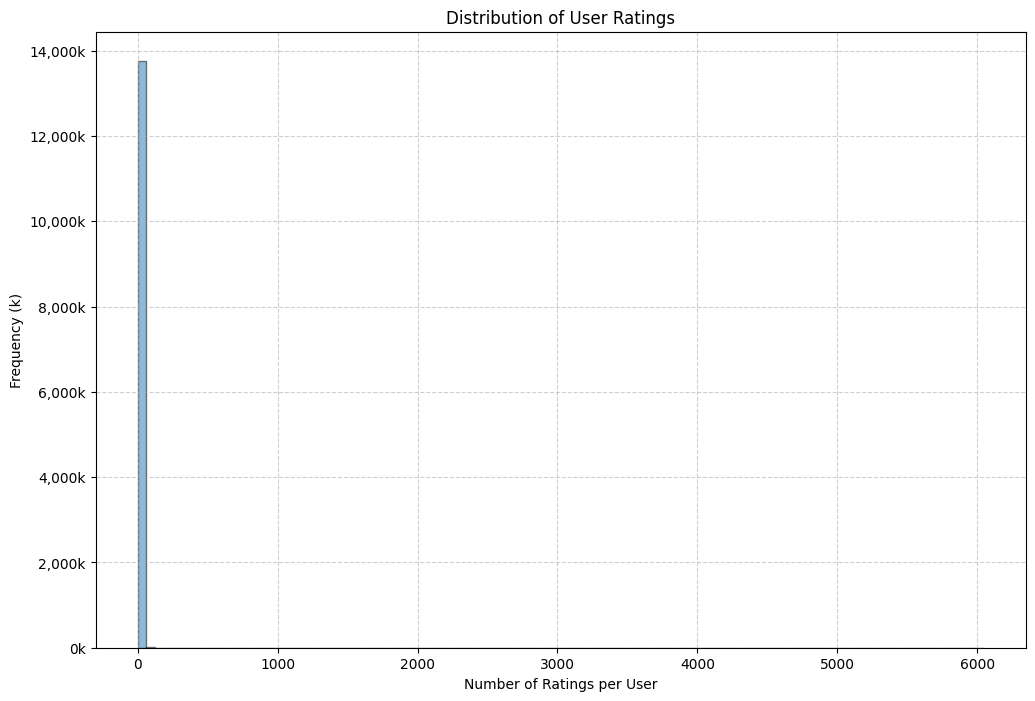

User Rating Count Description:
count    13781059.00
mean            2.99
std             8.12
min             1.00
25%             1.00
50%             1.00
75%             3.00
max          6045.00
dtype: float64


In [ ]:
# At least one user has reviewed 6,045 games.
show_user_rating_dist(review_df)

Introduction to `game_df`


In [ ]:
unique_games_count = game_df['app_id'].nunique()
print(f"game_df have unique {unique_games_count} games")
print("--------------------------")
print("game_df - rating string set\n", set(game_df['rating']))
print("--------------------------")
spark_game_df.show(2)
print("--------------------------")
print(f"Structure of game_df:")
spark_game_df.printSchema()


game_df have unique 50872 games
--------------------------
game_df - rating string set
 {'Mostly Positive', 'Mostly Negative', 'Overwhelmingly Negative', 'Very Negative', 'Overwhelmingly Positive', 'Very Positive', 'Mixed', 'Negative', 'Positive'}
--------------------------
+-------+--------------------+------------+----+-----+-----+-------------+--------------+------------+-----------+--------------+--------+----------+
| app_id|               title|date_release| win|  mac|linux|       rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+-------+--------------------+------------+----+-----+-----+-------------+--------------+------------+-----------+--------------+--------+----------+
|1541020|Kakele Online - M...|  2021-04-15|true| true| true|Very Positive|            84|         158|        0.0|           0.0|     0.0|      true|
|1566230|Turn on all the l...|  2021-03-31|true|false| true|Very Positive|            93|          60|       0.99|          0

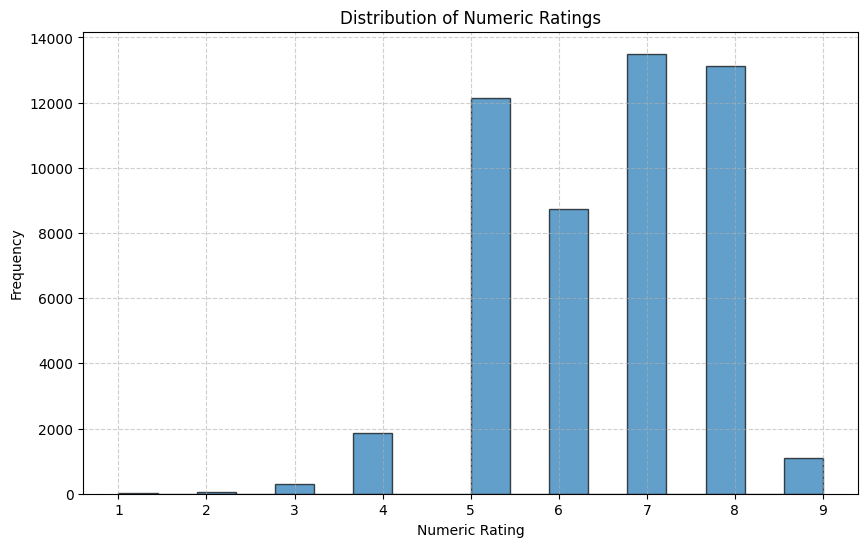

count    50872.000000
mean         6.511794
std          1.302575
min          1.000000
25%          5.000000
50%          7.000000
75%          8.000000
max          9.000000
Name: numeric_rating, dtype: float64


In [ ]:
game_df = numeric_rating(game_df)
show_rating_dist(game_df)


User Reviews:
count      50872.00
mean        1824.42
std        40073.52
min           10.00
25%           19.00
50%           49.00
75%          206.00
max      7494460.00
Name: user_reviews, dtype: float64


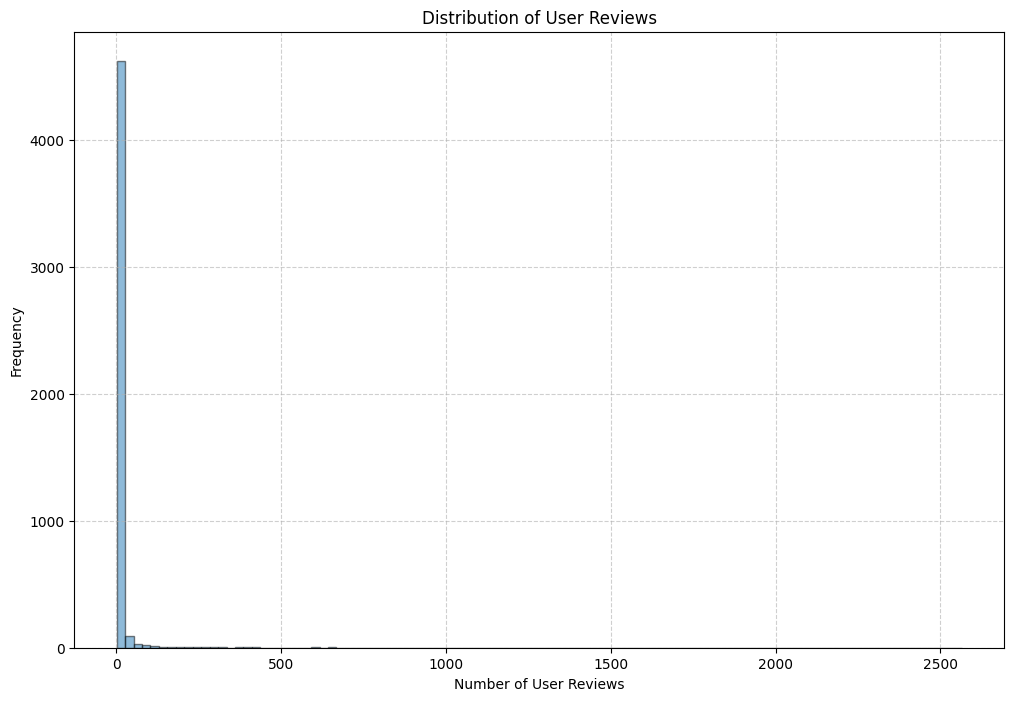

Rating Group By:
count    4847.00
mean       10.50
std        74.34
min         1.00
25%         1.00
50%         1.00
75%         3.00
max      2566.00
dtype: float64

User Reviews:
count      50872.00
mean        1824.42
std        40073.52
min           10.00
25%           19.00
50%           49.00
75%          206.00
max      7494460.00
Name: user_reviews, dtype: float64


In [ ]:
print("\nUser Reviews:")
print(game_df['user_reviews'].describe().round(2))

# Group by 'user_reviews' and count the number of entries in each group; the distribution is uneven.
show_review_num_dist(game_df)
print("\nUser Reviews:")
print(game_df['user_reviews'].describe().round(2))

Introduction to `game_info_df`

+-------+----------------------------------------+----------------------------------------+
| app_id|                             description|                                    tags|
+-------+----------------------------------------+----------------------------------------+
|1240050|AD 673. Camelot has fallen. The Round...|[Narrative, Strategy, Turn-Based Tact...|
|1263200|Fight Spartans at Brazil Island with ...|[Side Scroller, Precision Platformer,...|
|1281530|Live the life of your bird reigning i...|[Casual, Indie, Simulation, Third Per...|
|1292410|Golden Fall 2 is a single character d...|[CRPG, Exploration, Tactical RPG, Mys...|
|1292700|Starting from a homeless person who w...|[Indie, RPG, Adventure, Massively Mul...|
+-------+----------------------------------------+----------------------------------------+
only showing top 5 rows

total tag number:  441


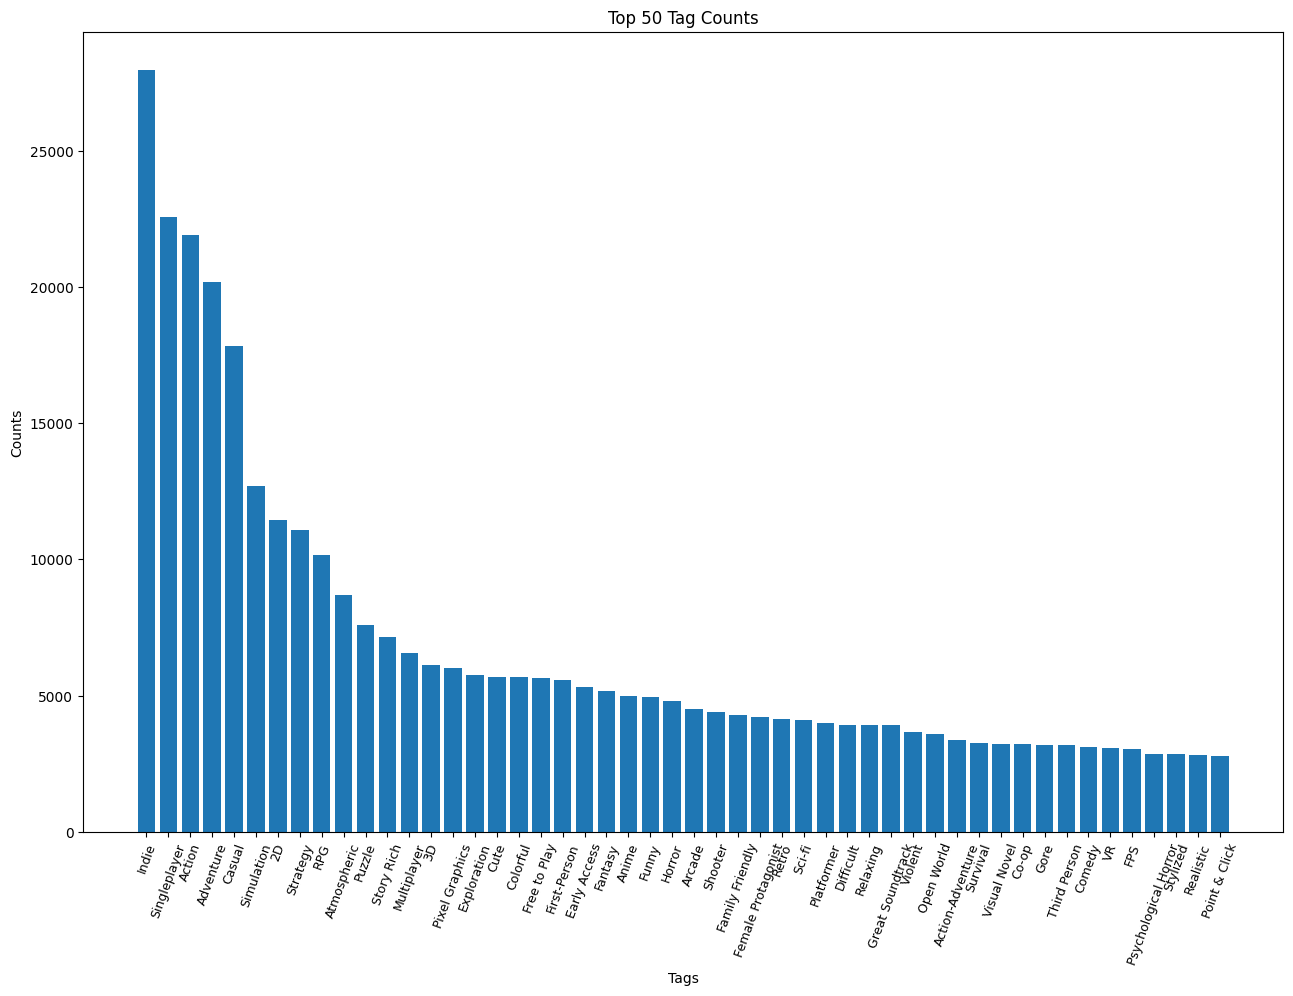

In [ ]:
tags_map = get_tags_map(game_info_df)
spark_game_info_df.show(5, truncate=40)
show_tag_dist(tags_map)

# 2.Retrival Layer

Method List
*   Embedding Based Recommendation
*   Memory CF
*   Content-Based Recommendation




## 2.1 Method: Embedding Based Recommendation

### 2.1.1 Select Training Set
In this section, I will outline why I chose this training data and show the detail methods.


#### 2.1.1.1 80% Training Set


1. Use `filter_users_with_min_interactions` to remove players with only one game record, as their information has limited reference value.

2. use `split_by_users_interactions` to split the interaction data by `user_id`. For example, if a user played 10 games, 8 game records will be included in the training set.

This way, the proportion of interaction records for each user remains consistent, which could ensure that each user has sufficient representation in both the training and test sets, allowing the model to learn the behavior patterns of all users.

In [ ]:
from sklearn.model_selection import train_test_split

def split_by_users_interactions(df, colname):
    train_df, test_df = train_test_split(
        df,
        stratify=df[colname],
        test_size=0.2,
        random_state=666
    )
    return train_df, test_df

def filter_users_with_min_interactions(df, min = 1):
  spark_lean_review_df = df.select("user_id", "app_id", "is_recommended")
  user_counts = spark_lean_review_df.groupBy("user_id").agg(F.count("*").alias("num_interactions"))
  filtered_df = user_counts.filter(F.col("num_interactions") > min).join(spark_lean_review_df, "user_id")
  return filtered_df


# filtered_lean_review_df = filter_users_with_min_interactions(spark_review_df, min=1)
# filtered_lean_review_df.write.parquet('./filtered_lean_review_df', mode='overwrite')

# direct load saved data
filtered_lean_review_df = pd.read_parquet('/content/drive/MyDrive/9727/saved_data_train_data/filtered_lean_review_df')
train_interactions_df, test_interactions_df = split_by_users_interactions(filtered_lean_review_df, "user_id")

print(f"Training set rows: train_interactions_df has {train_interactions_df['user_id'].count()} rows. It contains {train_interactions_df['user_id'].nunique()} unique users and {train_interactions_df['app_id'].nunique()} unique games.")
print(f"Test set rows: test_interactions_df has {test_interactions_df['user_id'].count()} rows. It contains {test_interactions_df['user_id'].nunique()} unique users and {test_interactions_df['app_id'].nunique()} unique games.")

Training set rows: train_interactions_df has 26865413 rows. It contains 6208032 unique users and 37480 unique games.
Test set rows: test_interactions_df has 6716354 rows. It contains 3867723 unique users and 35004 unique games.


#### 2.1.1.2 dataset of the top 10% most active users as training set

Sort the users based on the number of games they have played and select the interaction data of the most active users.

In [ ]:
def high_active_users_reviews(spark_review_features_df, top_N_percent=0.1):
  # `play_count` represents the number of interactions each user has with the games.
  user_play_counts = spark_review_features_df.groupBy("user_id").agg(F.count("app_id").alias("play_count"))
  percentile_threshold = user_play_counts.approxQuantile("play_count", [0.9], 0.0)
  top_users_data = spark_review_features_df.join(user_play_counts, "user_id").filter(user_play_counts["play_count"] >= percentile_threshold[0])
  return top_users_data

# spark_high_10_active_review_df = high_active_users_reviews(spark_review_df)
# spark_high_10_active_review_df.write.parquet("/content/drive/MyDrive/9727/spark_high_10_active_review_df.parquet")

spark_high_10_active_review_df = pd.read_parquet('/content/drive/MyDrive/9727/spark_high_10_active_review_df.parquet')
spark_high_10_active_review_df.show(2)

+-------+--------------+------+----------+-----+----------+
|user_id|is_recommended|app_id|      date|hours|play_count|
+-------+--------------+------+----------+-----+----------+
|    191|          true|322170|2021-09-03| 97.6|        15|
|    191|          true|213610|2020-10-16|  2.8|        15|
+-------+--------------+------+----------+-----+----------+
only showing top 2 rows



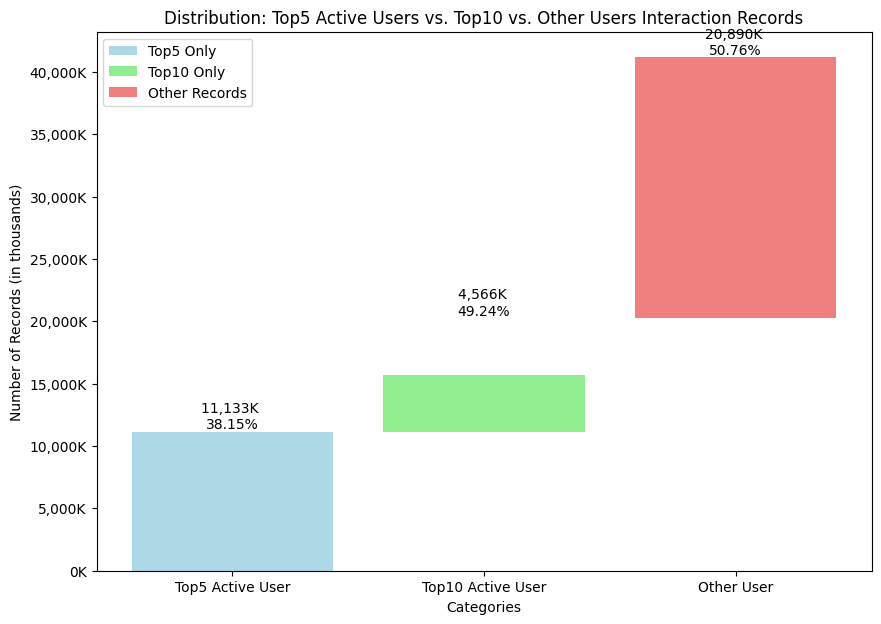

In [ ]:
import importlib
import plot_tool
importlib.reload(plot_tool)
from plot_tool import plot_interactoin_distribution

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plot_interactoin_distribution(
    total_records=41154794,
    top5_records=15698876,
    top10_records=20265202
)

#### 2.1.1.3 dataset of the top 5% most active users as training set


In [ ]:
def high_active_users_reviews(spark_review_features_df, top_N_percent=0.1):
  user_play_counts = spark_review_features_df.groupBy("user_id").agg(F.count("app_id").alias("play_count"))
  percentile_threshold = user_play_counts.approxQuantile("play_count", [1-top_N_percent], 0.0)
  top_users_data = spark_review_features_df.join(user_play_counts, "user_id").filter(user_play_counts["play_count"] >= percentile_threshold[0])
  return top_users_data

print(spark_review_df.count())
spark_high_5_active_review_df = high_active_users_reviews(spark_review_df, top_N_percent = 0.05)
spark_high_5_active_review_df.show(2)
spark_high_5_active_review_df.write.parquet("/content/drive/MyDrive/9727/spark_high_5_active_review_df.parquet")
# spark_high_5_active_review_df.count()
# 15698876

41154794
+-------+--------------+------+----------+-----+----------+
|user_id|is_recommended|app_id|      date|hours|play_count|
+-------+--------------+------+----------+-----+----------+
|    191|          true|322170|2021-09-03| 97.6|        15|
|    191|          true|213610|2020-10-16|  2.8|        15|
+-------+--------------+------+----------+-----+----------+
only showing top 2 rows



### 2.1.2 Core method code: Use DeepWalk to collect user game behavior sequences and train Word2Vec to obtain embedding vectors.

In [ ]:
from pool.game_matrix import sequence2matrix, combine_matrix
from pool.random_walk import random_walks
from embedding_tool import deep_walks, build_game_sequences, parallel_game_matrix_processing, build_trans_prob_matrix, build_entry_games_probs
from pyspark.sql.types import ArrayType, StringType, StructType, StructField


def build_word2vec_model(spark, games_habits, size = 100, iter = 15, wsize = 20, model_name = "w2v_model"):
    games_habits = [[str(app_id) for app_id in row] for row in games_habits]
    schema = ArrayType(StringType())
    habits_df = spark.createDataFrame([(row,) for row in games_habits], ['app_ids'])
    habit2vec = Word2Vec(vectorSize=size, maxIter=iter, windowSize=wsize, minCount=2, stepSize=0.025)
    habit2vec.setInputCol("app_ids")
    habit2vec.setOutputCol("app_ids_vector")
    vec_model = habit2vec.fit(habits_df)
    vec_model.save(f"{default_path}{model_name}_{size}_{iter}_{wsize}")
    return vec_model


# Construct game embedding vectors and user embedding
def build_embedding(spark_review_df, spark, sampling_times = 10000, walk_depth = 40, folder_path = "."):
    saved_path = f"{default_path}{folder_path}"
    # 1. Construct sequences of games preferred by users (preference condition: `is_recommended`).
    spark_filtered_review_df = spark_review_df.filter((F.col('is_recommended') == True)).select('user_id', 'app_id')
    user_play_sequence_df = spark_filtered_review_df.groupby('user_id').agg(F.collect_list(F.col('app_id').cast('string')).alias('app_ids'))
    user_play_sequence_df.write.mode('overwrite').parquet(f"{saved_path}user_play_sequence_df.parquet")

    # 2. Only game sequences like [[11], [22,33], ...]
    game_sequences = build_game_sequences(user_play_sequence_df)
    save_to_dill(game_sequences, 'game_sequences.dill', saved_path)

    # 3. Construct the co-occurrence matrix like [game a][game b] = [game b][game a].
    game_matrix = parallel_game_matrix_processing(game_sequences)
    save_to_dill(game_matrix, 'game_matrix.dill', saved_path)

    # 4.construct Probability matrix, like`[1]: [3: 1, 4: 1, 5: 2]` => `[1]: [3: 0.25, 4: 0.25, 5: 0.5]`
    trans_prob_matrix = build_trans_prob_matrix(game_matrix)
    save_to_dill(trans_prob_matrix, 'trans_prob_matrix.dill', saved_path)

    # 5.Construct the entry probabilities for all games
    # Example: 1: {'2': 1, '3': 2, '5': 1}, 2: {'1': 1, '3': 1}
    # Probability of game 1 = Total weight of game 1 / Total weight of all games
    #                       = (1 + 2 + 1) / (1 + 2 + 1 + 1 + 1)
    # 核心代码
    all_app_ids, entry_game_probs = build_entry_games_probs(trans_prob_matrix, game_matrix)
    save_to_dill(all_app_ids, 'all_app_ids.dill', saved_path)
    save_to_dill(entry_game_probs, 'entry_game_probs.dill', saved_path)

    # 6.Sample {sampling_times} times, with the maximum length of random walk sequences being {walk_depth}, to collect general game behavior patterns.
    games_habits = deep_walks(sampling_times, walk_depth, all_app_ids, entry_game_probs, trans_prob_matrix)
    save_to_dill(games_habits, 'games_habits_top10_review.dill', saved_path)
    # 7. construct Word2VecModel
    vec_model = build_word2vec_model(spark, games_habits, size = 150, iter = 15, wsize = 40, model_name = "word2vec_model")
    # vec_model = Word2VecModel.load('./saved_model')
    item_vec = vec_model.getVectors().collect()

    # 8. generate game embedding map
    games_embedding_map = {item.word: item.vector.toArray() for item in item_vec}
    save_to_dill(games_embedding_map, 'games_embedding_map.dill', saved_path)

    @F.udf(returnType=ArrayType(FloatType()))
    def build_user_embedding(user_game_sequence):
        user_profile = [games_embedding_map.get(app_id, []) for app_id in user_game_sequence]
        if not user_profile or all(len(x) == 0 for x in user_profile):
            return None
        user_embedding = np.mean([x for x in user_profile if len(x) > 0], axis=0)
        return user_embedding.tolist() if user_embedding.size else None

    # 8. generate user embedding map
    users_embedding_df = user_play_sequence_df.withColumn('user_embedding', build_user_embedding(F.col('app_ids')))
    users_embedding = users_embedding_df.collect()
    users_embedding_map = {str(row['user_id']): row['user_embedding'] for row in users_embedding}
    users_embedding_map = {k: v for k, v in users_embedding_map.items() if v is not None}
    save_to_dill(users_embedding_map, 'users_embedding_map.dill', saved_path)

    return games_embedding_map, users_embedding_map


#### 2.1.2.1 使用 PCA对Embedding降维后展示用户游戏喜好

In [ ]:
import pca_tool
import importlib
importlib.reload(pca_tool)
from pca_tool import plot_pca_by_user

games_habits = load_dill_file("/content/drive/MyDrive/9727/saved_data_top10_review/games_habits_top10_review.dill")
vec_model_1w = Word2VecModel.load(f"{default_path}saved_data_top10_review/word2vec_model_top10")
word_vectors = vec_model_1w.getVectors()
word_vectors.show(5, truncate = 100)

+-------+----------------------------------------------------------------------------------------------------+
|   word|                                                                                              vector|
+-------+----------------------------------------------------------------------------------------------------+
|1599250|[0.27746614813804626,0.5899126529693604,-0.3157600164413452,0.19872519373893738,-0.27641794085502...|
| 887510|[-0.11240393668413162,-0.2800697684288025,0.3235369026660919,0.036028943955898285,-0.229983672499...|
|1036260|[0.05785525217652321,-0.5350959897041321,0.14031054079532623,-0.3411217927932739,0.22932898998260...|
|1834870|[0.24520649015903473,0.46030038595199585,-0.052380338311195374,-0.09331385046243668,0.43722021579...|
|1592230|[0.769814133644104,0.5933798551559448,-0.19650530815124512,0.44564807415008545,0.0679817348718643...|
+-------+----------------------------------------------------------------------------------------------------+
o

vector_length: 150


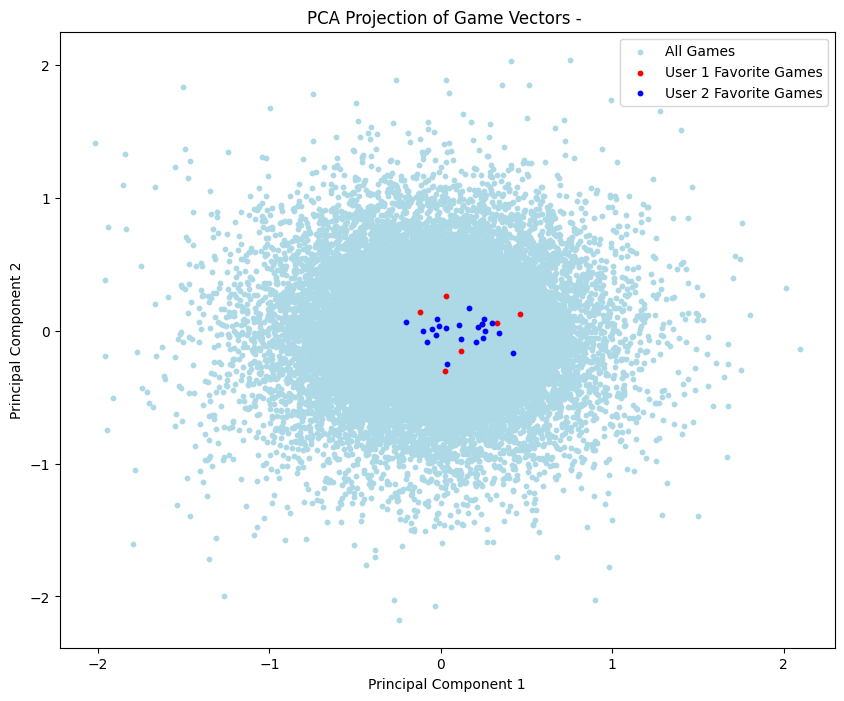

In [ ]:
# Real User's favorite games
user1_favorite_games = [8870, 570, 292030, 367520, 281990, 1145360, 381210]
user2_favorite_games = [
        381210, 289070, 1222680, 268910, 1426210, 413150, 728880, 1515210,
        332950, 424840, 365450, 1160220, 787480, 744190, 1625080, 588650,
        1740100, 567640, 2497610, 391540, 322330, 1888010]
# Visualize the vectors after compressing them to 2 dimensions.
plot_pca_by_user(user1_favorite_games, user2_favorite_games, word_vectors, spark, txt = '')

### 2.1.3 Construct user embeddings and game embeddings based on different training sets


#### 2.1.3.1 Full dataset: Sample 10,000 times

In [ ]:
games_embedding_map, users_embedding_map = build_embedding(spark_review_df, spark, sampling_times = 10000, walk_depth = 40, folder_path = "saved_data_full_data")
games_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_full_data/games_embedding_map.dill")
users_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_full_data/users_embedding_map.dill

#### 2.1.3.2 80% train data: Sample 10,000 times

In [ ]:
# games_embedding_map, users_embedding_map = build_embedding(spark_review_df, spark, sampling_times = 10000, walk_depth = 40, folder_path = "saved_data_train_data")
games_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_train_data/games_embedding_map.dill")
users_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_train_data/users_embedding_map.dill


#### 2.1.3.3 Top 10% training data: Sample 10,000 times

In [ ]:
# spark_high_10_active_review_df = spark.read.parquet('/content/drive/MyDrive/9727/spark_high_10_active_review_df.parquet')
games_embedding_map, users_embedding_map = build_embedding(spark_high_10_active_review_df, spark,sampling_times = 10000, walk_depth = 40, folder_path = "saved_data_top10_review")
# games_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_top10_review/games_embedding_map.dill")
# users_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_top10_review/users_embedding_map.dill

100%|██████████| 100/100 [54:30<00:00, 32.70s/it]


Data successfully saved to /content/drive/MyDrive/code/saved_data_top10_review/games_habits_top10_review.dill


#### 2.1.3.4 Top 10% training data: Sample 15,000 times


In [ ]:
# Top 10%: Collect interaction data from high-activity users 15,000 times
spark_high_10_active_review_df = spark.read.parquet('/content/drive/MyDrive/9727/spark_high_10_active_review_df.parquet')
games_embedding_map, users_embedding_map = build_embedding(spark_high_10_active_review_df, spark, sampling_times = 15000, walk_depth = 40, folder_path = "saved_data_top10_1w5sample")
# games_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_top10_1w5sample/games_embedding_map.dill")
# users_embedding_map = load_dill_file("/content/drive/MyDrive/9727/saved_data_top10_1w5sample/users_embedding_map.dill

100%|██████████| 150/150 [1:31:07<00:00, 36.45s/it]


Data successfully saved to ./saved_data_top10_3wsample/games_habits.dill


#### 2.1.3.5 Top 5: Sample 20,000 times, with the length of random walk sequences being 50, to collect general game behavior patterns.


In [ ]:
# Top 5: Sample 20,000 times, with the maximum length of random walk sequences being 50, to collect general game behavior patterns.
games_embedding_map, users_embedding_map = build_embedding(spark_high_10_active_review_df, spark, sampling_times = 20000, walk_depth = 50, folder_path = "saved_data_top5_2w5sample")

100%|██████████| 200/200 [1:54:32<00:00, 34.36s/it]


Data successfully saved to /content/drive/MyDrive/9727/saved_data_top5_1w5sample/games_habits_top10_review.dill


In [ ]:
# !cp -r /content/drive/MyDrive/code/saved_data_top10_review /content

<!-- # 采样10000次的情况下
# colab 0.8 数据(games_habits_train_1w.dill)+ 差的 model 参数【vectorSize=100, maxIter=15, windowSize=10, minCount=2, stepSize=0.025】
# 本地 全量数据(games_habits_1w.dill) + 好的model参数【vectorSize=100, maxIter=15, windowSize=10, minCount=2, stepSize=0.025】

# 评估
# 头部高活用户的推荐

# 10000次采样 =>
# 0.8 数据(games_habits_train_1w.dill) + 差的model参数vectorSize=100, maxIter=5, windowSize=10, minCount=2, stepSize=0.025
# 本地 全量数据(games_habits_1w.dill) + 好的model参数【vectorSize=100, maxIter=15, windowSize=10, minCount=2, stepSize=0.025】
 -->

### 2.1.4 Recommendations and Evaluation

#### 2.1.4.1 Implementation of Recommendation and Evaluation Methods

In [ ]:
def get_high_active_users_data(spark_high_active_review_df):
    collected_data = spark_high_active_review_df.groupBy("user_id") \
                                                .agg(F.collect_list("app_id").alias("app_ids")) \
                                                .collect()

    user_gameids_map = {row['user_id']: row['app_ids'] for row in collected_data}
    user_ids = [row['user_id'] for row in collected_data]
    return user_ids, user_gameids_map

spark_high_10_active_review_df = spark.read.parquet('/content/drive/MyDrive/9727/spark_high_10_active_review_df.parquet')
evaluate_user_ids, user_actual_games_map = get_high_active_users_data(spark_high_10_active_review_df)

spark_high_5_active_review_df = spark.read.parquet('/content/drive/MyDrive/9727/spark_high_5_active_review_df.parquet')
evaluate_top5user_ids, top5_user_actual_games_map = get_high_active_users_data(spark_high_5_active_review_df)

In [ ]:
import importlib
import lsh_tool
importlib.reload(lsh_tool)
from lsh_tool import get_lsh_instance


class EmbeddingRecSys:
    def __init__(self, lsh_instance, users_embedding_map, k):
        self.lsh_instance = lsh_instance
        self.users_embedding_map = users_embedding_map
        self.k = k

    def lsh_search_for_user(self, user_id, k=20):
        if user_id in self.users_embedding_map:
            user_embedding = self.users_embedding_map[user_id]
            recommended_ids = self.lsh_instance.search(user_embedding, search_num=k)
            return recommended_ids
        else:
            return []

    def generate_recommendations(self, user_ids):
        recommendations = {}
        for user_id in user_ids:
            user_id = str(user_id)
            recommendations[user_id] = self.lsh_search_for_user(user_id, self.k)
        return recommendations
    

# compute mean precision and recall
def evaluate_precision_recall(user_recommendations_map, user_actual_games_map, k):
      precision_scores = []
      recall_scores = []

      user_actual_games_map = {str(key): value for key, value in user_actual_games_map.items()}

      for user_id, recommended_games in user_recommendations_map.items():
          user_id = str(user_id)
          # Games that the user has actually played
          actual_games = set(map(str, user_actual_games_map.get(user_id, [])))
          # Recommended games
          recommended_games = set(map(str, recommended_games))

          correct_recommendations = recommended_games.intersection(actual_games)
          num_recommendations = min(len(recommended_games), k)
          precision = len(correct_recommendations) / num_recommendations if num_recommendations else 0
          recall = len(correct_recommendations) / len(actual_games) if actual_games else 0

          precision_scores.append(precision)
          recall_scores.append(recall)

      mean_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
      mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0
      print("Mean Precision:", mean_precision)
      print("Mean Recall:", mean_recall)
      return mean_precision, mean_recall


#### 2.1.4.2 Load the embedding data generated by sampling the full dataset 10,000 times, and evaluate the metrics for recommending 200 games.

In [ ]:
users_embedding_map_full = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_full_data/users_embedding_map.dill")
games_embedding_map_full = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_full_data/games_embedding_map.dill")
print(f"users number: {len(users_embedding_map_full)} games number: {len(games_embedding_map_full)}")
users_embedding_map_full = {str(key): value for key, value in users_embedding_map_full.items()}

users number: 9374706 games number: 8048


In [ ]:
lsh_instance_full = get_lsh_instance(games_embedding_map_full, nbits=256)
rec_sys_full = EmbeddingRecSys(lsh_instance_full, users_embedding_map_full, k=200)
user_recommendations_map_full = rec_sys_full.generate_recommendations(evaluate_user_ids)
mean_precision_full, mean_recall_full = evaluate_precision_recall(user_recommendations_map_full, user_actual_games_map, k=200)

LSH index added 8048 vectors with nbits=256 and bucketSize=50
Average Precision: 0.0006983042137365046
Average Recall: 0.010784328093814877


#### 2.1.4.3 Load the embedding data generated by sampling 80% of the full dataset 10,000 times, and evaluate the metrics for recommending 200 games.

In [ ]:
users_embedding_map_train = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_train_data/users_embedding_map.dill")
games_embedding_map_train = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_train_data/games_embedding_map.dill")
print(f"users number: {len(users_embedding_map_train)} games number: {len(games_embedding_map_train)}")
users_embedding_map_train = {str(key): value for key, value in users_embedding_map_train.items()}

lsh_instance_train = get_lsh_instance(games_embedding_map_train, nbits=256)
rec_sys_train = EmbeddingRecSys(lsh_instance_train, users_embedding_map_train, k=200)
user_recommendations_map_train = rec_sys_train.generate_recommendations(evaluate_user_ids)
avg_precision_train, avg_recall_train = evaluate_precision_recall(user_recommendations_map_train, user_actual_games_map, k=200)

users number: 6042616 games number: 21674
LSH index added 21674 vectors with nbits=256 and bucketSize=50
Average Precision: 0.01753776756615217
Average Recall: 0.38529685224438903


#### 2.1.4.4 Load the embedding data generated by sampling interaction data from the top 10% most active users 10,000 times, and evaluate the metrics for recommending 200 games.

In [ ]:
# top10 1wsamples
users_embedding_map_top10 = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_top10_review/users_embedding_map.dill")
games_embedding_map_top10 = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_top10_review/games_embedding_map.dill")
print(f"users number: {len(users_embedding_map_top10)} games number: {len(games_embedding_map_top10)}")

lsh_instance_top10 = get_lsh_instance(games_embedding_map_top10, nbits=256)
rec_sys_top10 = EmbeddingRecSys(lsh_instance_top10, users_embedding_map_top10, k=200)
user_recommendations_map_top10users = rec_sys_top10.generate_recommendations(evaluate_user_ids)
mean_precision_top10users, mean_recall_top10users = evaluate_precision_recall(user_recommendations_map_top10users, user_actual_games_map, k=200)


users number: 1472700 games number: 24554
LSH index added 24554 vectors with nbits=256 and bucketSize=50
Average Precision: 0.03141061173195774
Average Recall: 0.6102483522034078


#### 2.1.4.5 Load the embedding data generated by sampling interaction data from the top 10% most active users 15,000 times, and evaluate the metrics for recommending 200 games.

In [ ]:
# top10 1w5samples
users_embedding_map_top10_1w5 = load_dill_file(f"/content/drive/MyDrive/code/saved_data_top10_1w5sample/users_embedding_map.dill")
games_embedding_map_top10_1w5 = load_dill_file(f"/content/drive/MyDrive/code/saved_data_top10_1w5sample/games_embedding_map.dill")
print(f"users number: {len(users_embedding_map_top10_1w5)} games number: {len(games_embedding_map_top10_1w5)}")
lsh_instance_top10_1w5 = get_lsh_instance(games_embedding_map_top10_1w5, nbits=256)
rec_sys_top10users_1w5 = EmbeddingRecSys(lsh_instance_top10_1w5, users_embedding_map_top10_1w5, k=200)
user_recommendations_map_top10_1w5 = rec_sys_top10users_1w5.generate_recommendations(evaluate_user_ids)
mean_precision_top10users, mean_recall_top10users = evaluate_precision_recall(user_recommendations_map_top10_1w5, user_actual_games_map, k=200)

users number: 1472723 games number: 27078
LSH index added 27078 vectors with nbits=256 and bucketSize=50
Average Precision: 0.032654905834587133
Average Recall: 0.6309386206341011


#### 2.1.4.6 Metric Comparison

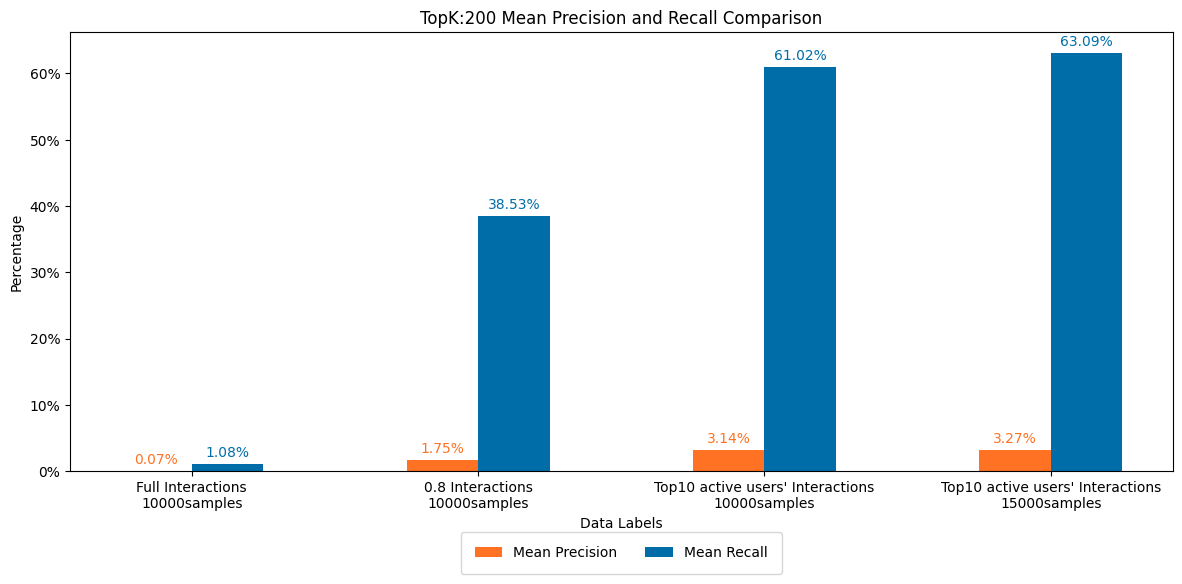

In [ ]:
import plot_tool
importlib.reload(plot_tool)
from plot_tool import plot_precision_recall_bar
data_labels = ['Full Interactions\n10000samples', '0.8 Interactions\n10000samples', 'Top10 active users\' Interactions\n10000samples', 'Top10 active users\' Interactions\n15000samples']
mean_precision = [0.0006983042137365046, 0.01753776756615217, 0.03141061173195774, 0.032654905834587133]
mean_recall = [0.010784328093814877, 0.38529685224438903, 0.6102483522034078,0.6309386206341011]

# plot chart
plot_precision_recall_bar(data_labels, mean_precision, mean_recall, "TopK:200 Mean Precision and Recall Comparison")


#### 2.1.4.7 Load the embedding data generated by sampling interaction data from the top 5% most active users 20,000 times, and evaluate the metrics for recommending 200 games.



In [ ]:
users_embedding_map_top5_2w = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_top5_2wsample/users_embedding_map.dill")
games_embedding_map_top5_2w = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_top5_2wsample/games_embedding_map.dill")
print(f"users number: {len(users_embedding_map_top5_2w)} games number: {len(games_embedding_map_top5_2w)}")
lsh_instance_top5_2w = get_lsh_instance(games_embedding_map_top5_2w, nbits=256)
rec_sys_top5users_2w = EmbeddingRecSys(lsh_instance_top5_2w, users_embedding_map_top5_2w, k=200)
user_recommendations_map_top5_2w_k200 = rec_sys_top5users_2w.generate_recommendations(evaluate_top5user_ids)
avg_precision_top5users, avg_recall_top5users = evaluate_precision_recall(user_recommendations_map_top5_2w_k200, top5_user_actual_games_map, k=200)

users number: 1472728 games number: 29598
LSH index added 29598 vectors with nbits=256 and bucketSize=50
Average Precision: 0.03964862579118432
Average Recall: 0.5335682049344127


In [ ]:
save_to_dill(user_recommendations_map_top5_2w_k200, 'user_recommendations_map_top5_2w_k200.dill', "./")

Data successfully saved to ./user_recommendations_map_top5_2w.dill


#### 2.1.4.8 Load the embedding data generated by sampling interaction data from the top 5% most active users 20,000 times, and evaluate the metrics for recommending 100 games.

In [ ]:
rec_sys_top5users_2w_k100 = EmbeddingRecSys(lsh_instance_top5_2w, users_embedding_map, k=100)
user_recommendations_map_top5_2w_k100 = rec_sys_top5users_2w_k100.generate_recommendations(evaluate_top5user_ids)
avg_precision_top5users_k100, avg_recall_top5users_k100 = evaluate_precision_recall(user_recommendations_map_top5_2w_k100, top5_user_actual_games_map, k=100)

Average Precision: 0.06642765506404251
Average Recall: 0.4637651204919839



#### 2.1.4.9 Load the embedding data generated by sampling interaction data from the top 5% most active users 20,000 times, and evaluate the metrics for recommending 300 games.

In [ ]:
users_embedding_map_top5_2w = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_top5_2wsample/users_embedding_map.dill")
games_embedding_map_top5_2w = load_dill_file(f"/content/drive/MyDrive/9727/saved_data_top5_2wsample/games_embedding_map.dill")
lsh_instance_top5_2w_300 = get_lsh_instance(games_embedding_map_top5_2w, nbits=256)
rec_sys_top5users_2w_k300 = EmbeddingRecSys(lsh_instance_top5_2w_300, users_embedding_map_top5_2w, k=300)
user_recommendations_map_top5_2w_k300 = rec_sys_top5users_2w_k300.generate_recommendations(evaluate_top5user_ids)
avg_precision_top5users_k300, avg_recall_top5users_k300 = evaluate_precision_recall(user_recommendations_map_top5_2w_k300, top5_user_actual_games_map, k=300)

LSH index added 29598 vectors with nbits=256 and bucketSize=50
Average Precision: 0.029148384155819274
Average Recall: 0.5750876352152569


In [ ]:
save_to_dill(user_recommendations_map_top5_2w_k300, 'user_recommendations_map_top5_2w_k300.dill', "/content/drive/MyDrive/9727/")

Data successfully saved to /content/drive/MyDrive/9727/user_recommendations_map_top5_2w_k300.dill


#### 2.1.4.10 Compare the metrics for recommending 100, 200, and 300 games.

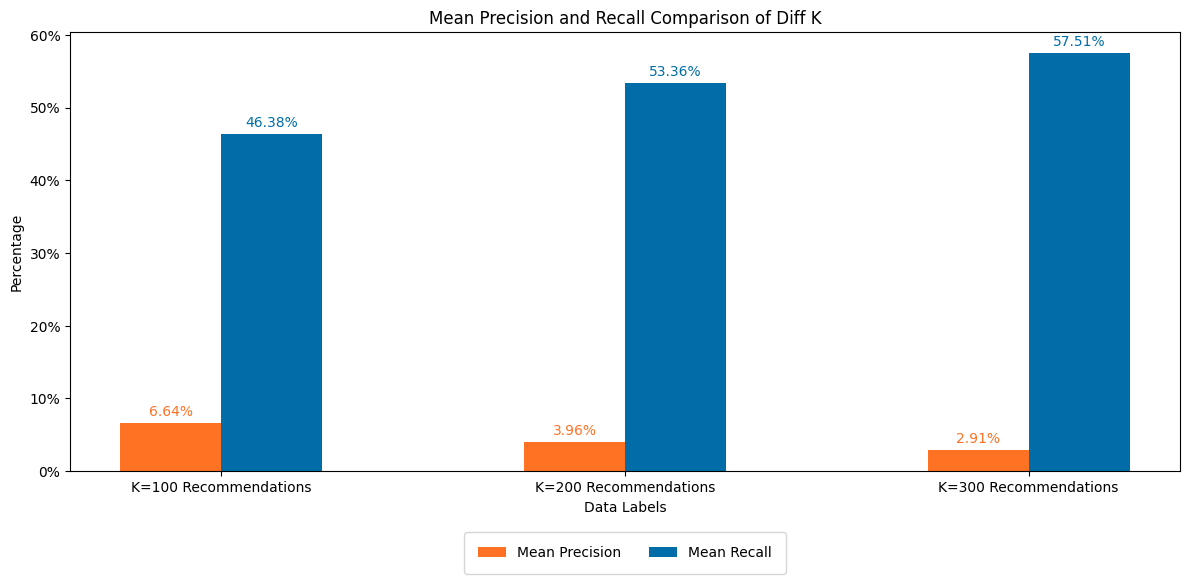

In [ ]:
from plot_tool import plot_precision_recall_bar

data_labels = ['K=100 Recommendations', 'K=200 Recommendations', 'K=300 Recommendations']
avg_precision = [0.06642765506404251, 0.03964862579118432, 0.029148384155819274]
avg_recall = [0.4637651204919839, 0.5335682049344127, 0.5750876352152569]


plot_precision_recall_bar(data_labels, avg_precision, avg_recall, "Mean Precision and Recall Comparison of Diff K")

Importing Essential Libraries and Modules

In [ ]:
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))


Loading Dataset Files into DataFrames

In [ ]:
DEFAULT_PATH = './dataset'
game_df = pd.read_csv(f'{DEFAULT_PATH}/games.csv', index_col='app_id')
review_df = pd.read_csv(f'{DEFAULT_PATH}/recommendations.csv')
game_info_df = pd.read_json(f'{DEFAULT_PATH}/games_metadata.json', lines=True)

Tag and Description Cleaning Functions

In [ ]:
# Function to clean tags by removing punctuation, converting to lowercase, and filtering out stopwords
def clean_tags(tags):
    stop_words = set(stopwords.words('english'))
    cleaned_tags = []
    for tag in tags:
        tag = tag.lower()  # Convert tag to lowercase
        tag = re.sub(r'[^\w\s]', '', tag)  # Remove punctuation and special characters
        if tag and tag not in stop_words:
            cleaned_tags.append(tag)  # Add tag to cleaned list if it's not empty or a stopword
    return cleaned_tags

# Function to clean descriptions by removing non-ASCII characters, punctuation, numbers, and optionally performing stemming
def clean_description(text, use_stemming=True):
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stop_words]  # Filter out stopwords
    if use_stemming:
        tokens = [ps.stem(word) for word in tokens]  # Apply stemming if specified
    return ' '.join(tokens)  # Return the cleaned and processed text as a single string

Tags-based approach

Identifying and Removing Empty Tags in Data

In [ ]:
print("Tags before cleaning:")
print(game_info_df['tags'])

# Perform cleaning operations
# 1. Identify rows where the 'tags' column is an empty list or contains only empty strings, and print them
empty_tags_df = game_info_df[game_info_df['tags'].apply(lambda x: all(tag.strip() == '' for tag in x))]
print("Rows with empty 'tags':")
print(empty_tags_df)
print(f"\n[{empty_tags_df.shape[0]} rows x {empty_tags_df.shape[1]} columns]\n")

# 2. Drop these rows
game_info_df = game_info_df.drop(empty_tags_df.index)

# 3. Check again for rows with empty 'tags' after cleaning, and print them
empCleaned_tags_df = game_info_df[game_info_df['tags'].apply(lambda x: all(tag.strip() == '' for tag in x))]
print("Rows with empty 'tags' after cleaning:")
print(empCleaned_tags_df)
print(f"\n[{empCleaned_tags_df.shape[0]} rows x {empCleaned_tags_df.shape[1]} columns]")

# Print 'tags' column after cleaning
print("Tags after cleaning:")
print(game_info_df['tags'])

Tags before cleaning:
0        [Action, Adventure, Parkour, Third Person, Gre...
1                                                 [Action]
2        [Co-op, Stealth, Indie, Heist, Local Co-Op, St...
3        [Zombies, Adventure, Survival, Action, Third P...
4        [Roguelike, Strategy, Tower Defense, Pixel Gra...
                               ...                        
50867                                                   []
50868                                                   []
50869                                                   []
50870    [Early Access, FPS, Action, Retro, First-Perso...
50871                                                   []
Name: tags, Length: 50872, dtype: object
Rows with empty 'tags':
        app_id description tags
33      371970               []
214    2277010               []
219    1600150               []
224     222573               []
287     919640               []
...        ...         ...  ...
50866  2362300               []
50867  2

Loading and Preprocessing Game Data

In [ ]:
def load_and_preprocess_data(default_path='./dataset'):
    game_info_df['filtered_tags'] = game_info_df['tags'].apply(clean_tags)
    game_info_df['cleaned_description'] = game_info_df['description'].apply(clean_description)

    return game_info_df

game_info_df = load_and_preprocess_data()

In [ ]:
def preprocess_tags(game_info_df):
    game_info_df['tags'] = game_info_df['tags'].apply(lambda x: clean_tags(x) if isinstance(x, list) else clean_tags(x.split(',')))
    return game_info_df

In [ ]:
def filter_and_deduplicate_tags(tags, selected_tags):
    return [tag for tag in set(tags) if tag in selected_tags]

Calculating Tag Frequency, Coverage, and Filtering Tags

In [ ]:
def calculate_tag_statistics(game_info_df, threshold=500):
    all_tags = [tag for sublist in game_info_df['tags'] for tag in sublist]
    tag_counter = Counter(all_tags)

    tag_freqs = pd.DataFrame(tag_counter.items(), columns=['Tag', 'Frequency'])
    tag_freqs['Percentage'] = tag_freqs['Frequency'] / tag_freqs['Frequency'].sum() * 100

    bins = [0, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000]
    tag_freqs['Frequency_Bin'] = pd.cut(tag_freqs['Frequency'], bins)
    bin_percentage = tag_freqs.groupby('Frequency_Bin', observed=False)['Percentage'].sum()

    selected_tags = {tag for tag, count in tag_counter.items() if count > threshold}
    selected_count = sum(tag_counter[tag] for tag in selected_tags)
    total_count = sum(tag_counter.values())
    coverage = selected_count / total_count

    game_info_df['filtered_tags'] = game_info_df['tags'].apply(lambda x: filter_and_deduplicate_tags(x, selected_tags))

    return game_info_df, tag_counter, tag_freqs, bin_percentage, coverage

In [ ]:
def plot_tag_distribution_comparison(original_tag_counter, filtered_tag_counter):
    plt.figure(figsize=(10, 12))

    # Plot original tags
    plt.subplot(2, 1, 1)
    plt.hist(original_tag_counter.values(), bins=50, log=True, color='blue', alpha=0.7)
    plt.xlabel('Frequency of Tags')
    plt.ylabel('Number of Tags')
    plt.title('Original Tag Frequencies')

    # Plot filtered tags
    plt.subplot(2, 1, 2)
    plt.hist(filtered_tag_counter.values(), bins=50, log=True, color='red', alpha=0.7)
    plt.xlabel('Frequency of Tags')
    plt.ylabel('Number of Tags')
    plt.title('Filtered Tag Frequencies')

    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess_game_data(game_info_df, threshold=500):
    # Clean the tags
    game_info_df = preprocess_tags(game_info_df)

    # Print the number of rows before cleaning tags
    original_row_count = game_info_df.shape[0]
    print(f"Original tags row count (before cleaning): {original_row_count}")

    # Remove rows with empty tags
    empty_tags_df = game_info_df[game_info_df['tags'].apply(lambda x: all(tag.strip() == '' for tag in x))]
    game_info_df = game_info_df.drop(empty_tags_df.index)

    # Calculate tag statistics and remove low-frequency tags
    game_info_df, original_tag_counter, tag_freqs, bin_percentage, coverage = calculate_tag_statistics(game_info_df, threshold)

    # Count the number of tags after filtering low-frequency tags
    filtered_tag_counter = Counter([tag for sublist in game_info_df['filtered_tags'] for tag in sublist])

    # Remove rows with empty tags after filtering
    empty_tags_df_after_filter = game_info_df[game_info_df['filtered_tags'].apply(lambda x: all(tag.strip() == '' for tag in x))]
    game_info_df = game_info_df.drop(empty_tags_df_after_filter.index)

    # Print coverage and tag frequency distribution information
    print(f"Coverage with threshold {threshold}: {coverage:.4f}")
    print("Percentage of tags in different frequency bins:")
    print(bin_percentage)

    # Print the number of tags before and after filtering
    print(f"Original tags count: {len(original_tag_counter)}")
    print(f"Filtered tags count: {len(filtered_tag_counter)}")

    # Print the number of rows after removing low-frequency tags
    filtered_row_count = game_info_df.shape[0]
    print(f"Tags row count after removing low frequency tags: {filtered_row_count}")

    # Plot the tag frequency distribution comparison
    plot_tag_distribution_comparison(original_tag_counter, filtered_tag_counter)

    return game_info_df, original_tag_counter, filtered_tag_counter

Applying Preprocessing and Converting Filtered Tags to String Format

Original tags row count (before cleaning): 49628
Coverage with threshold 500: 0.9286
Percentage of tags in different frequency bins:
Frequency_Bin
(0, 100]           0.658662
(100, 200]         1.315783
(200, 500]         5.162825
(500, 1000]        9.624881
(1000, 2000]      15.334081
(2000, 3000]      11.586830
(3000, 4000]       8.857527
(4000, 5000]       6.061125
(5000, 10000]     14.725743
(10000, 20000]    10.821701
(20000, 30000]    15.850843
Name: Percentage, dtype: float64
Original tags count: 441
Filtered tags count: 214
Tags row count after removing low frequency tags: 49583


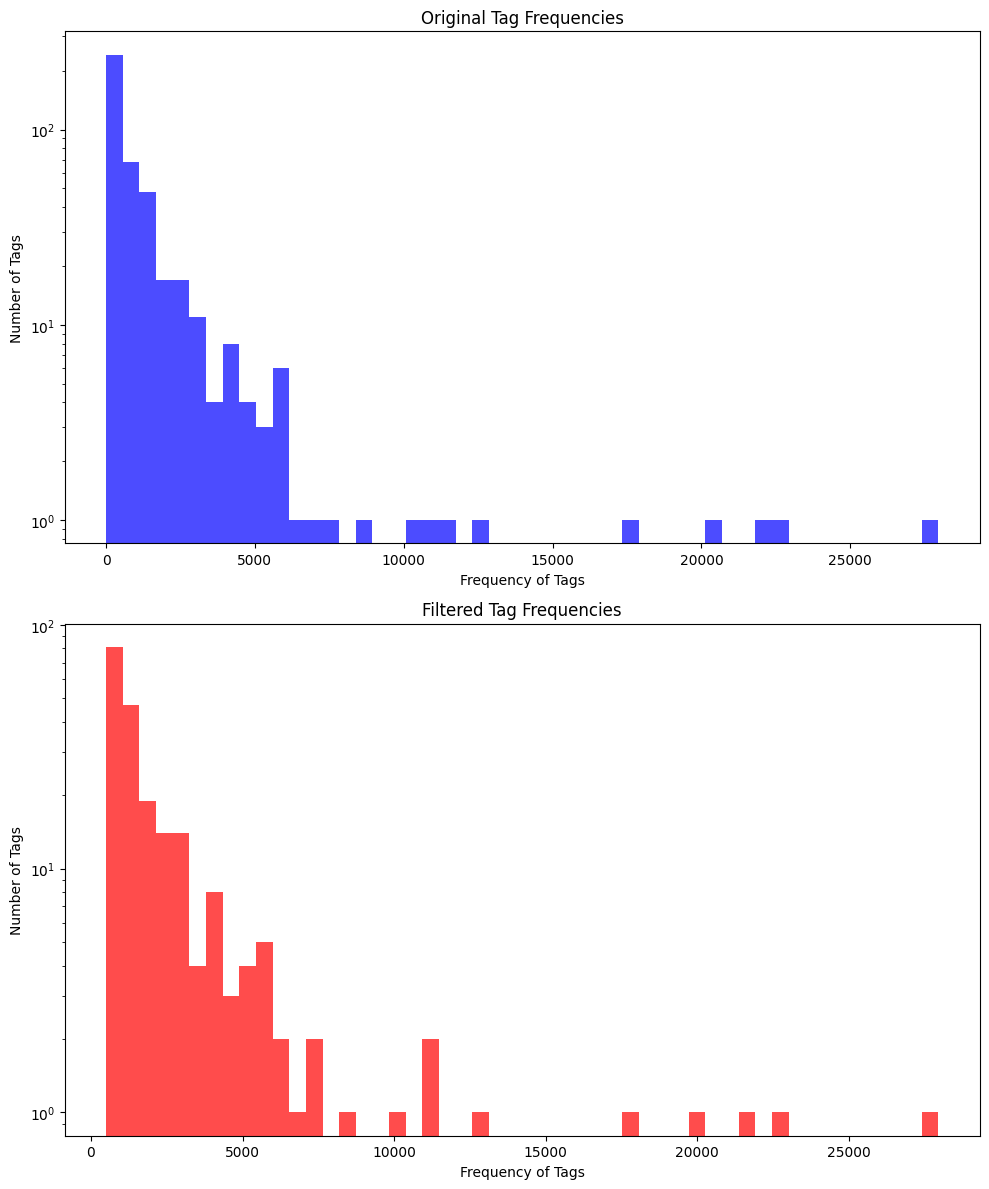

In [ ]:
threshold = 500
game_info_df, original_tag_counter, filtered_tag_counter = preprocess_game_data(game_info_df, threshold)

game_info_df['filtered_tags_str'] = game_info_df['filtered_tags'].apply(lambda x: ' '.join(x))

In [ ]:
print("Columns in game_info_df:", game_info_df.columns)

Columns in game_info_df: Index(['app_id', 'description', 'tags', 'filtered_tags', 'cleaned_description',
       'filtered_tags_str'],
      dtype='object')


Creating and Merging Recommended Games DataFrame

In [ ]:
# Filter review_df to only include app_id values that exist in game_info_df
filtered_review_df = review_df[(review_df['is_recommended'] == True) & (review_df['app_id'].isin(game_info_df['app_id']))][['user_id', 'app_id', 'is_recommended', 'hours']]

# Sort like_df by user_id and hours in descending order
like_df = filtered_review_df.sort_values(by=['user_id', 'hours'], ascending=[True, False])

# Merge like_df with game_info_df to add the filtered_tags_str column
like_df = like_df.merge(game_info_df[['app_id', 'filtered_tags_str']], on='app_id', how='left')

# Display the first few rows of the resulting DataFrame
print(like_df.head())

   user_id   app_id  is_recommended  hours  \
0        0  1454400            True  762.6   
1        0   222880            True  162.5   
2        0   402840            True  157.4   
3        0     8850            True   61.5   
4        0   214490            True   40.5   

                                   filtered_tags_str  
0  comedy clicker building economy singleplayer c...  
1  singleplayer atmospheric action tactical teamb...  
2  multiplayer rpg casual strategy clicker funny ...  
3  rpg dystopian singleplayer action atmospheric ...  
4  survival horror gore singleplayer action alien...  


Creating a TF-IDF Matrix for Game Tags

In [ ]:
def create_tfidf_matrix(game_info_df):
    vectorizer = TfidfVectorizer()
    tag_vectors = vectorizer.fit_transform(game_info_df['filtered_tags_str'])
    return tag_vectors, vectorizer

Generating User Profiles Based on Liked Games' TF-IDF Vectors

In [ ]:
def generate_user_profiles(unique_user_ids, like_df, game_info_df, tag_vectors, top_n_users=5):
    user_profiles = {}  # Initialize an empty dictionary to store user profiles

    count = 0
    for user_id in unique_user_ids:
        if count >= top_n_users:
            break  # Stop once the top N users are processed

        user_likes = like_df[like_df['user_id'] == user_id]  # Get liked games for the current user
        liked_games = user_likes['app_id'].tolist()  # Extract the list of liked game IDs
        liked_game_indices = game_info_df[game_info_df['app_id'].isin(liked_games)].index  # Get the indices of the liked games in game_info_df

        valid_indices = [i for i in liked_game_indices if i < tag_vectors.shape[0]]  # Ensure indices are valid within the tag_vectors matrix
        user_like_vectors = tag_vectors[valid_indices]  # Get the TF-IDF vectors for the liked games

        if user_like_vectors.shape[0] == 0:
            continue  # Skip to the next user if there are no valid game vectors

        user_profile = user_like_vectors.mean(axis=0)  # Compute the mean vector for the user's liked games
        user_profile = np.asarray(user_profile).flatten()  # Convert the result to a 1D numpy array
        user_profiles[user_id] = user_profile  # Store the user's profile in the dictionary
        count += 1  # Increment the processed user count

    return user_profiles  # Return the dictionary of user profiles

Generating Partial User Profiles Based on Selected Game Tags

In [ ]:
def generate_partial_user_profile(user_likes, tag_vectors, tag_names, max_tags=12):
    liked_game_indices = game_info_df[game_info_df['app_id'].isin(user_likes)].index  # Get indices of liked games in game_info_df
    user_like_vectors = tag_vectors[liked_game_indices]  # Get the TF-IDF vectors for the liked games

    if user_like_vectors.shape[0] == 0:
        return None, None  # Return None if there are no valid game vectors

    user_profile = user_like_vectors.mean(axis=0)  # Compute the mean vector for the user's liked games
    user_profile = np.asarray(user_profile).flatten()  # Convert the result to a 1D numpy array

    non_zero_indices = np.where(user_profile > 0)[0]  # Find indices where the profile has non-zero values
    num_tags = len(non_zero_indices)  # Count the number of tags with non-zero values

    if num_tags <= 4:
        portion = 1.0  # If few tags are non-zero, use all of them
    else:
        portion = 0.8  # Otherwise, use 80% of them

    # Randomly select indices for the partial profile, limiting to max_tags
    selected_indices = np.random.choice(non_zero_indices, size=min(int(num_tags * portion), max_tags), replace=False)
    partial_user_profile = np.zeros_like(user_profile)  # Initialize a zero vector for the partial profile
    partial_user_profile[selected_indices] = user_profile[selected_indices]  # Fill the partial profile with selected tags

    partial_tags = [tag_names[i] for i in selected_indices]  # Get the names of the selected tags
    return partial_user_profile, partial_tags  # Return the partial profile and its corresponding tags

In [ ]:
def generate_synthetic_likes_from_partial_profile(user_profiles, tag_vectors, game_info_df, num_likes=10):
    synthetic_likes = {}
    for user_id, partial_profile in user_profiles.items():
        similarities = cosine_similarity(partial_profile.reshape(1, -1), tag_vectors).flatten()
        top_indices = similarities.argsort()[-num_likes:][::-1]
        synthetic_likes[user_id] = game_info_df.iloc[top_indices][['app_id']]
    return synthetic_likes

Recommending Games Based on User Profile and Tag Similarities

In [ ]:
def recommend_games(user_profile, tag_vectors, game_info_df, top_n=10):
    similarities = cosine_similarity(user_profile.reshape(1, -1), tag_vectors).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    recommended_games = game_info_df.iloc[top_indices][['app_id', 'filtered_tags_str']]
    return recommended_games

Evaluating Recommendation Performance Using Precision, Recall, and F1 Score

In [ ]:
def evaluate_recommendations(full_user_profiles, synthetic_likes, tag_vectors, game_info_df, top_n=10):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for user_id, user_profile in full_user_profiles.items():
        recommended_games = recommend_games(user_profile, tag_vectors, game_info_df, top_n=top_n)  # Get top N recommended games for the user
        recommended_game_ids = recommended_games['app_id'].tolist()  # Extract the recommended game IDs
        actual_likes = synthetic_likes[user_id]['app_id'].tolist() if user_id in synthetic_likes else []  # Get the actual liked game IDs for the user

        relevant_recommendations = len(set(recommended_game_ids) & set(actual_likes))  # Count the number of relevant recommendations

        precision = relevant_recommendations / len(recommended_game_ids) if recommended_game_ids else 0  # Calculate precision
        recall = relevant_recommendations / len(actual_likes) if actual_likes else 0  # Calculate recall
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0  # Calculate F1 score

        precision_scores.append(precision)  # Store the precision score for the user
        recall_scores.append(recall)  # Store the recall score for the user
        f1_scores.append(f1)  # Store the F1 score for the user

    avg_precision = np.mean(precision_scores)  # Calculate the average precision score
    avg_recall = np.mean(recall_scores)  # Calculate the average recall score
    avg_f1 = np.mean(f1_scores)  # Calculate the average F1 score

    return avg_precision, avg_recall, avg_f1  # Return the average precision, recall, and F1 scores

Vectorizing Tags, Generating Full and Partial User Profiles, and Creating Synthetic Likes

In [ ]:
# Vectorize the 'filtered_tags_str' column
tag_vectors, vectorizer = create_tfidf_matrix(game_info_df)

# Generate user profiles for the top 100 users with tags
top_users_with_tags = like_df.dropna(subset=['filtered_tags_str'])['user_id'].unique()[:100]
full_user_profiles = generate_user_profiles(top_users_with_tags, like_df, game_info_df, tag_vectors)

# Generate partial user profiles
partial_user_profiles = {}
for user_id in top_users_with_tags:
    user_likes = like_df[like_df['user_id'] == user_id]['app_id'].tolist()  # Get the liked games for the user
    partial_profile, _ = generate_partial_user_profile(user_likes, tag_vectors, vectorizer.get_feature_names_out())  # Generate a partial user profile
    if partial_profile is not None:
        partial_user_profiles[user_id] = partial_profile  # Store the partial profile if it's valid

# Generate synthetic likes based on the partial user profiles
synthetic_likes = generate_synthetic_likes_from_partial_profile(partial_user_profiles, tag_vectors, game_info_df)

Evaluating Recommendation Performance Across Different Top-N Values

Top N = 5:
Average Precision: 0.5600
Average Recall: 0.2800
Average F1 Score: 0.3733
--------------------------------------------------
Top N = 10:
Average Precision: 0.5400
Average Recall: 0.5400
Average F1 Score: 0.5400
--------------------------------------------------
Top N = 15:
Average Precision: 0.3600
Average Recall: 0.5400
Average F1 Score: 0.4320
--------------------------------------------------
Top N = 20:
Average Precision: 0.2700
Average Recall: 0.5400
Average F1 Score: 0.3600
--------------------------------------------------


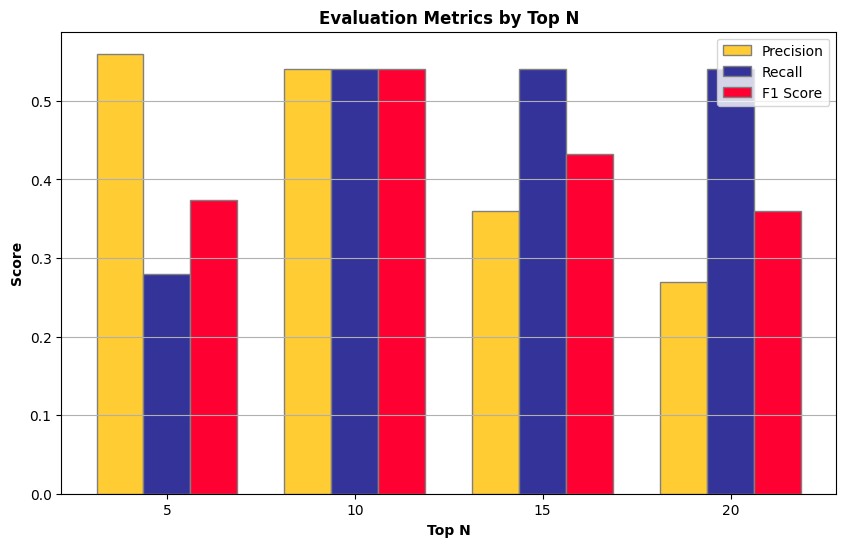

In [ ]:
# Define different top_n values for evaluation
top_n_values = [5, 10, 15, 20]

# Initialize lists to store evaluation results
precision_results = []
recall_results = []
f1_results = []

# Iterate over different top_n values
for top_n in top_n_values:
    # Evaluate recommendations based on the current top_n value
    precision, recall, f1 = evaluate_recommendations(full_user_profiles, synthetic_likes, tag_vectors, game_info_df, top_n=top_n)

    # Save the evaluation results
    precision_results.append(precision)
    recall_results.append(recall)
    f1_results.append(f1)

    # Print the evaluation results for each top_n value
    print(f"Top N = {top_n}:")
    print(f"Average Precision: {precision:.4f}")
    print(f"Average Recall: {recall:.4f}")
    print(f"Average F1 Score: {f1:.4f}")
    print("-" * 50)

# Plot the evaluation results
# Set bar width and positions
bar_width = 0.25
r1 = np.arange(len(top_n_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, precision_results, color='#FFCC33', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall_results, color='#333399', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_results, color='#FF0033', width=bar_width, edgecolor='grey', label='F1 Score')

# Add labels and title
plt.xlabel('Top N', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(top_n_values))], top_n_values)
plt.ylabel('Score', fontweight='bold')
plt.title('Evaluation Metrics by Top N', fontweight='bold')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

Tags and descriptions-based approach

Combining Descriptions and Tags into a Single Text Field

In [ ]:
def combine_description_tags(description, tags):
    return f"{description} {' '.join(tags)}"

game_info_df['combined_description_tags'] = game_info_df.apply(
    lambda row: combine_description_tags(row['cleaned_description'], row['filtered_tags']),
    axis=1
)

Generating Synthetic Likes Based on Partial User Profiles

In [ ]:
def generate_synthetic_likes_from_partial_profile(user_profiles, tag_vectors, game_info_df, num_likes=10):
    synthetic_likes = {}
    for user_id, partial_profile in user_profiles.items():
        similarities = cosine_similarity(partial_profile.reshape(1, -1), tag_vectors).flatten()
        top_indices = similarities.argsort()[-num_likes:][::-1]
        synthetic_likes[user_id] = game_info_df.iloc[top_indices][['app_id']]
    return synthetic_likes

Generating User Profiles Using Weighted Vectors from Descriptions and Tags

In [ ]:
def generate_user_profiles_with_description(unique_user_ids, like_df, game_info_df, weighted_vectors, top_n_users=100):
    user_profiles = {}
    count = 0
    for user_id in unique_user_ids:
        if count >= top_n_users:
            break

        user_likes = like_df[like_df['user_id'] == user_id]
        liked_games = user_likes['app_id'].tolist()
        liked_game_indices = game_info_df[game_info_df['app_id'].isin(liked_games)].index

        valid_indices = [i for i in liked_game_indices if i < weighted_vectors.shape[0]]
        user_like_vectors = weighted_vectors[valid_indices]

        if user_like_vectors.shape[0] == 0:
            continue

        user_profile = user_like_vectors.mean(axis=0)
        user_profile = np.asarray(user_profile).flatten()
        user_profiles[user_id] = user_profile
        count += 1

    return user_profiles

In [ ]:
def evaluate_recommendations_with_desc(user_profiles, synthetic_likes, weighted_vectors, game_info_df, top_n=10):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for user_id, user_profile in user_profiles.items():
        recommended_games = recommend_games(user_profile, weighted_vectors, game_info_df, top_n=top_n)  # Get top N recommended games for the user
        recommended_game_ids = recommended_games['app_id'].tolist()  # Extract the recommended game IDs
        actual_likes = synthetic_likes[user_id]['app_id'].tolist() if user_id in synthetic_likes else []  # Get the actual liked game IDs for the user

        relevant_recommendations = len(set(recommended_game_ids) & set(actual_likes))  # Count the number of relevant recommendations

        precision = relevant_recommendations / len(recommended_game_ids) if recommended_game_ids else 0  # Calculate precision
        recall = relevant_recommendations / len(actual_likes) if actual_likes else 0  # Calculate recall
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0  # Calculate F1 score

        precision_scores.append(precision)  # Store the precision score for the user
        recall_scores.append(recall)  # Store the recall score for the user
        f1_scores.append(f1)  # Store the F1 score for the user

    avg_precision = np.mean(precision_scores)  # Calculate the average precision score
    avg_recall = np.mean(recall_scores)  # Calculate the average recall score
    avg_f1 = np.mean(f1_scores)  # Calculate the average F1 score

    return avg_precision, avg_recall, avg_f1  # Return the average precision, recall, and F1 scores

Vectorizing Tags and Descriptions, Generating Weighted User Profiles, and Creating Synthetic Likes

In [ ]:
# Vectorize the 'filtered_tags_str' column
vectorizer = TfidfVectorizer()
tag_vectors = vectorizer.fit_transform(game_info_df['filtered_tags_str'])

# Combine the description and tags columns into a single text field
game_info_df['combined_description_tags'] = game_info_df.apply(
    lambda row: combine_description_tags(row['cleaned_description'], row['filtered_tags']),
    axis=1
)

# Vectorize the combined description and tags column
combined_vectors = vectorizer.fit_transform(game_info_df['combined_description_tags'])

# Set weights for descriptions and tags
tag_weight = 3.0  # Adjust weight for tags as needed
desc_weight = 1.0  # Adjust weight for descriptions as needed
desc_vectors = vectorizer.transform(game_info_df['cleaned_description'])  # Vectorize the cleaned descriptions
tag_vectors = vectorizer.transform(game_info_df['filtered_tags_str'])  # Vectorize the filtered tags
weighted_vectors = desc_weight * desc_vectors + tag_weight * tag_vectors  # Combine vectors with specified weights

# Generate user profiles for the top 100 users with tags
top_users_with_tags = like_df.dropna(subset=['filtered_tags_str'])['user_id'].unique()[:100]
full_user_profiles = generate_user_profiles_with_description(top_users_with_tags, like_df, game_info_df, weighted_vectors)

# Generate partial user profiles
partial_user_profiles = {}
for user_id in top_users_with_tags:
    user_likes = like_df[like_df['user_id'] == user_id]['app_id'].tolist()  # Get the liked games for the user
    partial_profile, _ = generate_partial_user_profile(user_likes, weighted_vectors, vectorizer.get_feature_names_out())  # Generate a partial user profile
    if partial_profile is not None:
        partial_user_profiles[user_id] = partial_profile  # Store the partial profile if it's valid

# Generate synthetic likes based on the partial user profiles
synthetic_likes = generate_synthetic_likes_from_partial_profile(partial_user_profiles, weighted_vectors, game_info_df)

Evaluating and Visualizing Optimal Weight Combinations for Game Recommendations

Testing with tag_weight=1, desc_weight=10
Testing with tag_weight=2, desc_weight=9
Testing with tag_weight=3, desc_weight=8
Testing with tag_weight=4, desc_weight=7
Testing with tag_weight=5, desc_weight=6
Testing with tag_weight=6, desc_weight=5
Testing with tag_weight=7, desc_weight=4
Testing with tag_weight=8, desc_weight=3
Testing with tag_weight=9, desc_weight=2
Testing with tag_weight=10, desc_weight=1
Best combination found:
Tag Weight: 1
Description Weight: 10
Top N: 10
Best F1 Score: 0.4270


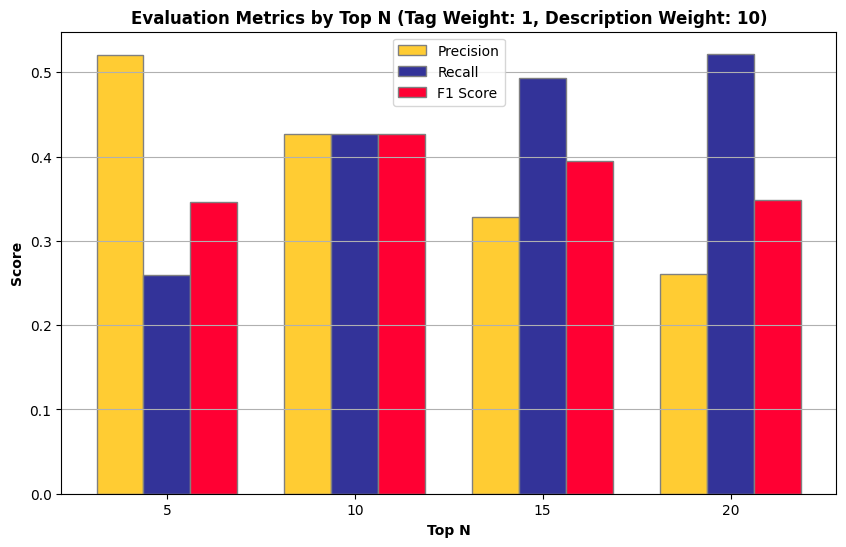

In [ ]:
# Initialize variables to store results
results = {}

# Test combinations of tag_weight from 1 to 10 and desc_weight from 10 to 1
for i in range(1, 11):
    tag_weight = i
    desc_weight = 11 - i  # Ensure the sum is 11 to compare the effect of weight changes
    print(f"Testing with tag_weight={tag_weight}, desc_weight={desc_weight}")

    # Recalculate the weighted vectors
    weighted_vectors = desc_weight * desc_vectors + tag_weight * tag_vectors

    # Generate user profiles
    full_user_profiles = generate_user_profiles_with_description(top_users_with_tags, like_df, game_info_df, weighted_vectors)

    # Generate partial user profiles
    partial_user_profiles = {}
    for user_id in top_users_with_tags:
        user_likes = like_df[like_df['user_id'] == user_id]['app_id'].tolist()
        partial_profile, _ = generate_partial_user_profile(user_likes, weighted_vectors, vectorizer.get_feature_names_out())
        if partial_profile is not None:
            partial_user_profiles[user_id] = partial_profile

    # Generate synthetic likes
    synthetic_likes = generate_synthetic_likes_from_partial_profile(partial_user_profiles, weighted_vectors, game_info_df)

    # Initialize variables to store evaluation results
    precision_results = []
    recall_results = []
    f1_results = []

    # Iterate over different top_n values
    for top_n in top_n_values:
        precision, recall, f1 = evaluate_recommendations_with_desc(
            full_user_profiles, synthetic_likes, weighted_vectors, game_info_df, top_n=top_n
        )
        precision_results.append(precision)
        recall_results.append(recall)
        f1_results.append(f1)

    # Save results
    results[(tag_weight, desc_weight)] = {
        'precision': precision_results,
        'recall': recall_results,
        'f1': f1_results
    }

# Initialize variables to store the best results
best_tag_weight = None
best_desc_weight = None
best_top_n = None
best_f1_score = -1  # Initialize to a very low value to find the highest F1 score

# Iterate over all results to find the best combination
for (tag_weight, desc_weight), metrics in results.items():
    for i, top_n in enumerate(top_n_values):
        if metrics['f1'][i] > best_f1_score:
            best_f1_score = metrics['f1'][i]
            best_tag_weight = tag_weight
            best_desc_weight = desc_weight
            best_top_n = top_n

# Print the best combination and its evaluation results
print(f"Best combination found:")
print(f"Tag Weight: {best_tag_weight}")
print(f"Description Weight: {best_desc_weight}")
print(f"Top N: {best_top_n}")
print(f"Best F1 Score: {best_f1_score:.4f}")

# Define the top_n values and corresponding evaluation results for the best combination
precision_results = results[(best_tag_weight, best_desc_weight)]['precision']
recall_results = results[(best_tag_weight, best_desc_weight)]['recall']
f1_results = results[(best_tag_weight, best_desc_weight)]['f1']

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(top_n_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(10, 6))

plt.bar(r1, precision_results, color='#FFCC33', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall_results, color='#333399', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_results, color='#FF0033', width=bar_width, edgecolor='grey', label='F1 Score')

# Add labels and title
plt.xlabel('Top N', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(top_n_values))], top_n_values)
plt.ylabel('Score', fontweight='bold')
plt.title(f'Evaluation Metrics by Top N (Tag Weight: {best_tag_weight}, Description Weight: {best_desc_weight})', fontweight='bold')
plt.legend()
plt.grid(axis='y')

# Display the chart
plt.show()

### 2.3.1 Dataset Review

In [ ]:
from EDA2 import game_review, rec_review

- review game dataset

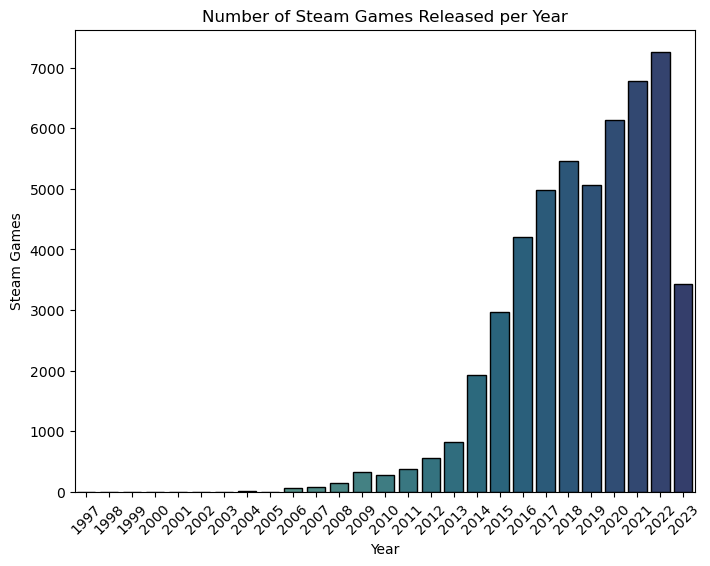

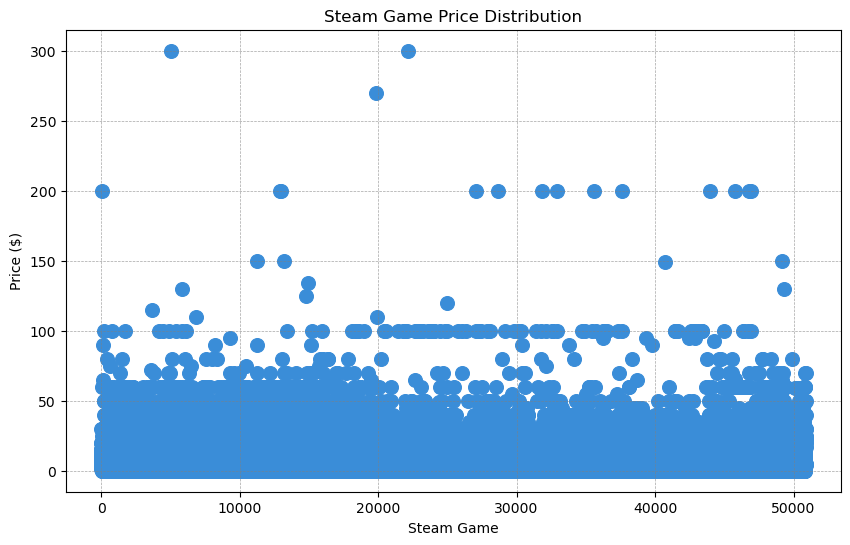

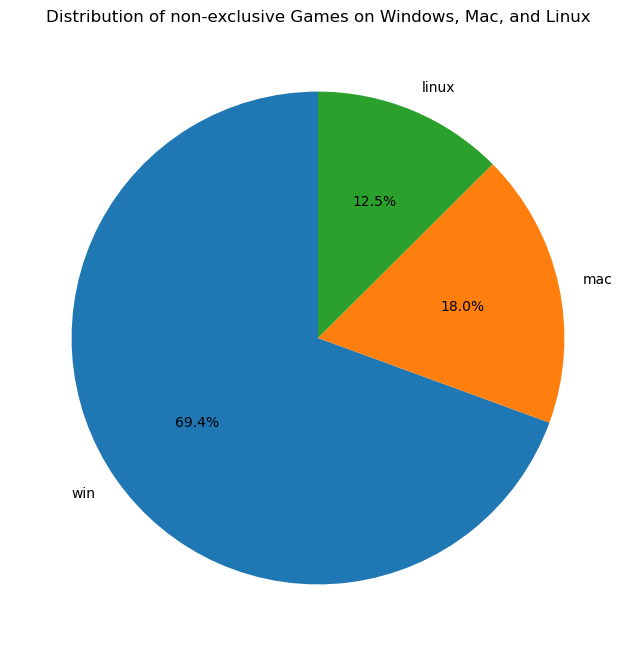

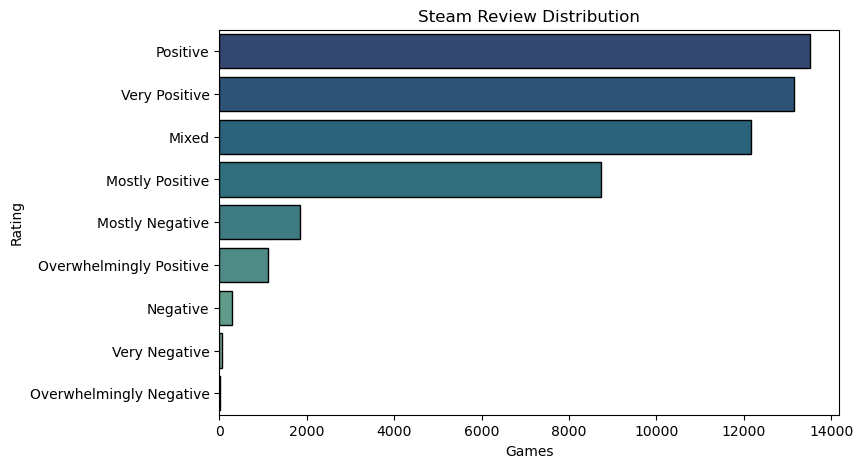

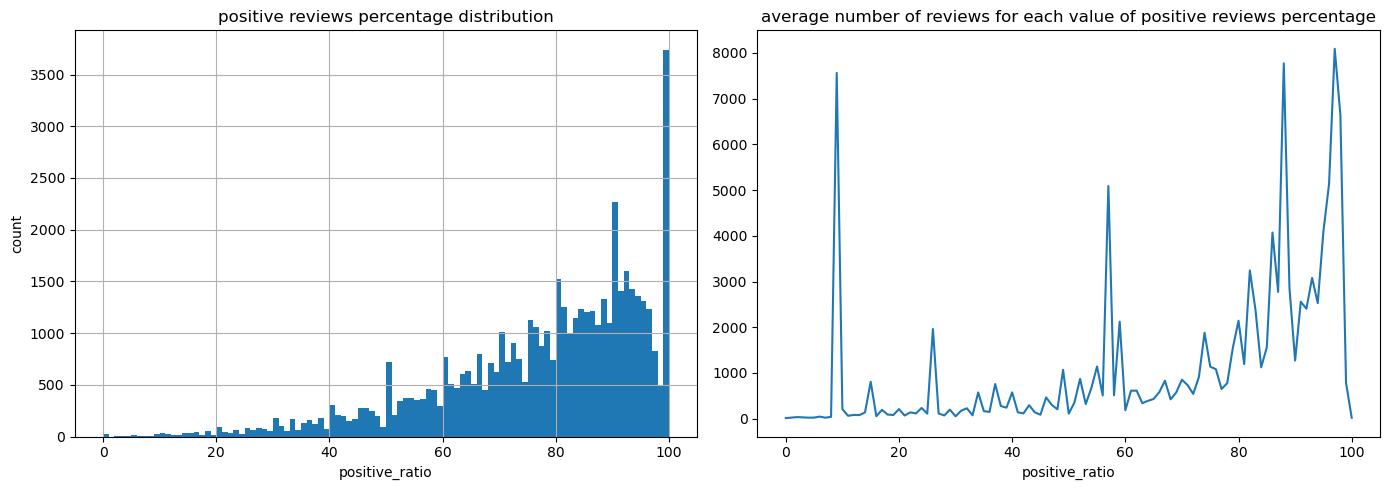

In [ ]:
game_review()

- review game dataset

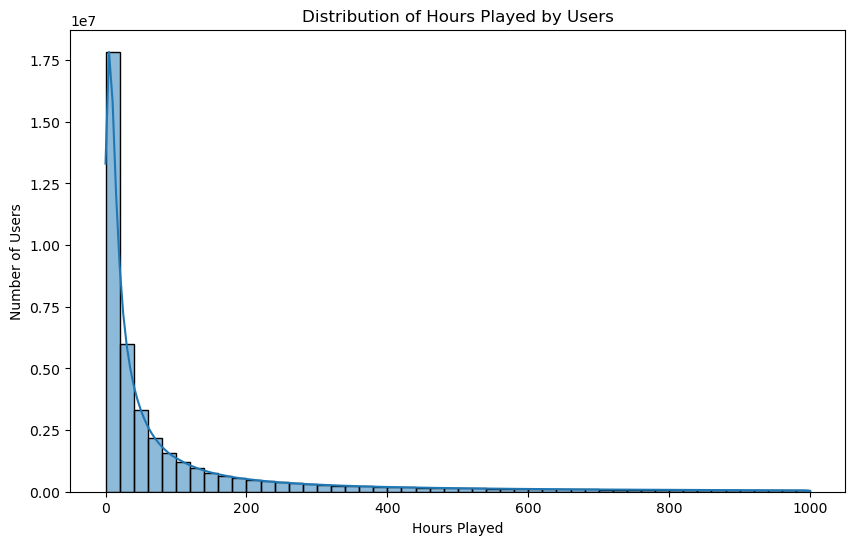

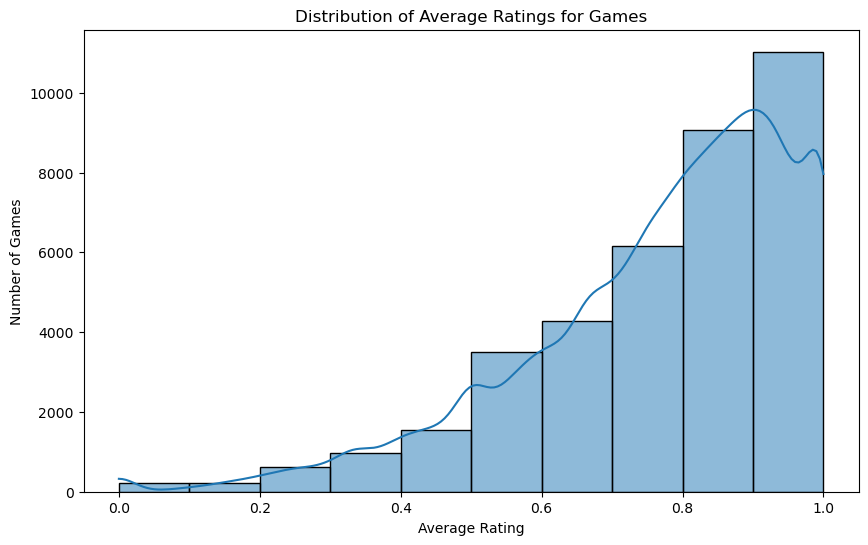

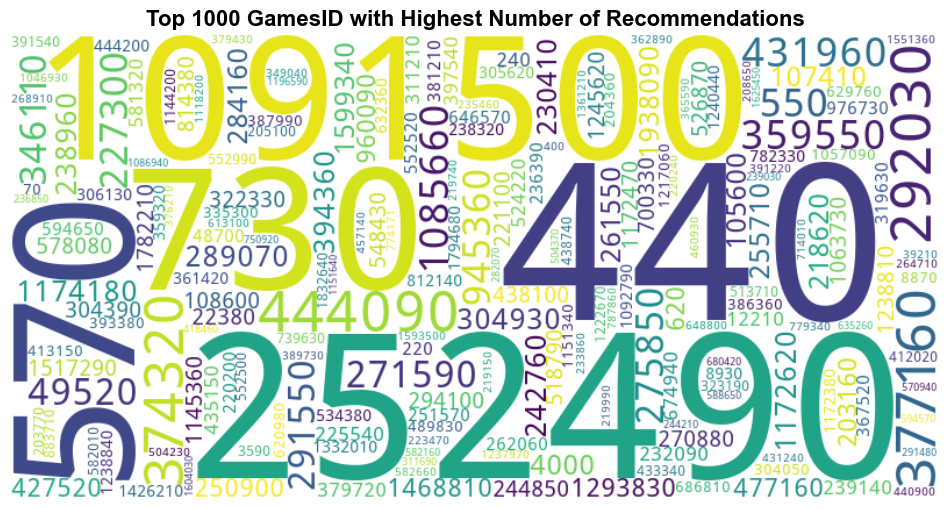

In [ ]:
rec_review()

### 2.3.2 Data Processing

In [ ]:
from DataProcess import process_data

In [ ]:
processed_data = process_data()
processed_data.head()

,app_id,title,rating,positive_ratio,user_reviews,helpful,is_recommended,user_id
0,13500,Prince of Persia: Warrior Within™,8,84,2199,2,1,3369378
1,13500,Prince of Persia: Warrior Within™,8,84,2199,4,0,11294916
2,13500,Prince of Persia: Warrior Within™,8,84,2199,13,1,4177110
3,13500,Prince of Persia: Warrior Within™,8,84,2199,2,0,1238024
4,13500,Prince of Persia: Warrior Within™,8,84,2199,2,0,7443530


### 2.3.3 CF

In [ ]:
from CF import filter_inactive_users_and_games, create_sparse_matrix, perform_svd, build_annoy_index, recommend_games, aggregate_user_ratings
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42)

# Filter training data
filtered_train_data = filter_inactive_users_and_games(train_data)

In [ ]:
# Create sparse matrix and perform SVD
sparse_matrix, user_indices, app_ids = create_sparse_matrix(filtered_train_data)
svd_features, svd_model = perform_svd(sparse_matrix)

# Build Annoy index for fast similarity lookup
annoy_index = build_annoy_index(svd_features)

user_ratings_dict = {uid: df for uid, df in train_data.groupby('user_id')}
user_ratings_dict = aggregate_user_ratings(filtered_train_data)
user_indices = {i: uid for i, uid in enumerate(filtered_train_data['user_id'])}

In [ ]:
# Generate recommendations
# Choose a user index to generate recommendations; here we assume we are using user index 1
# You can change this to another index to test with different users
user_index = 1  # Can be changed to another index for testing with different users

# Call the recommend_games function
recommended_games_list = recommend_games(
    user_index,       # User index
    annoy_index,      # Annoy index for fast approximate nearest neighbor search
    svd_features,     # SVD feature matrix
    user_indices,     # Mapping from indices to user IDs
    user_ratings_dict,# Dictionary of user ratings
    top_k=5           # Number of recommendations
)

# Print the recommended games
print("Recommended Games for User Index [{}]: {}".format(user_index, recommended_games_list))

Recommended Games for User Index [1]: [552520, 617290, 346110, 526870, 1455840]


In [ ]:
from CF import evaluate_top_n, create_annoy_index, plot_evaluation_results

# Define different values for n and top_k to evaluate
n_values = [5, 10]  # Different sample sizes of users
top_k_values = [5, 10, 20]  # Different lengths of recommendation lists
results = {}  # Dictionary to store results

# Test different numbers of SVD components
for n_components in [5, 10]:
    results[n_components] = {'Precision': [], 'Recall': []}  # Initialize result storage for this component count
    
    # Perform SVD
    svd_features, svd_model = perform_svd(sparse_matrix, n_components=n_components)
    
    # Create a new Annoy index for each set of SVD features
    annoy_index = create_annoy_index(svd_features)

    print(f"Evaluating for SVD components = {n_components}")
    # Loop through different values of n
    for n in n_values:
        print(f"  Evaluating for n = {n}")
        # Loop through different values of top_k
        for top_k in top_k_values:
            precision, recall = evaluate_top_n(
                recommend_games,      # Recommendation function
                test_data,            # Test data
                user_indices,         # User index mapping
                annoy_index,          # Annoy index for fast approximate nearest neighbor search
                svd_features,         # SVD features
                user_ratings_dict,    # User ratings dictionary
                top_k=top_k,          # Current iteration top_k value
                n=n                   # Current iteration n value
            )
            results[n_components]['Precision'].append(precision)
            results[n_components]['Recall'].append(recall)
            print(f"    Top-K: {top_k} -> Precision: {precision:.4f}, Recall: {recall:.4f}")
        print("\n")  # Add a blank line to separate results for different n values
    print("\n")


Evaluating for SVD components = 5
  Evaluating for n = 5
    Top-K: 5 -> Precision: 0.0176, Recall: 0.0026
    Top-K: 10 -> Precision: 0.0189, Recall: 0.0056
    Top-K: 20 -> Precision: 0.0203, Recall: 0.0121


  Evaluating for n = 10
    Top-K: 5 -> Precision: 0.0176, Recall: 0.0026
    Top-K: 10 -> Precision: 0.0189, Recall: 0.0056
    Top-K: 20 -> Precision: 0.0203, Recall: 0.0121




Evaluating for SVD components = 10
  Evaluating for n = 5
    Top-K: 5 -> Precision: 0.0165, Recall: 0.0025
    Top-K: 10 -> Precision: 0.0182, Recall: 0.0054
    Top-K: 20 -> Precision: 0.0200, Recall: 0.0119


  Evaluating for n = 10
    Top-K: 5 -> Precision: 0.0165, Recall: 0.0025
    Top-K: 10 -> Precision: 0.0182, Recall: 0.0054
    Top-K: 20 -> Precision: 0.0200, Recall: 0.0119






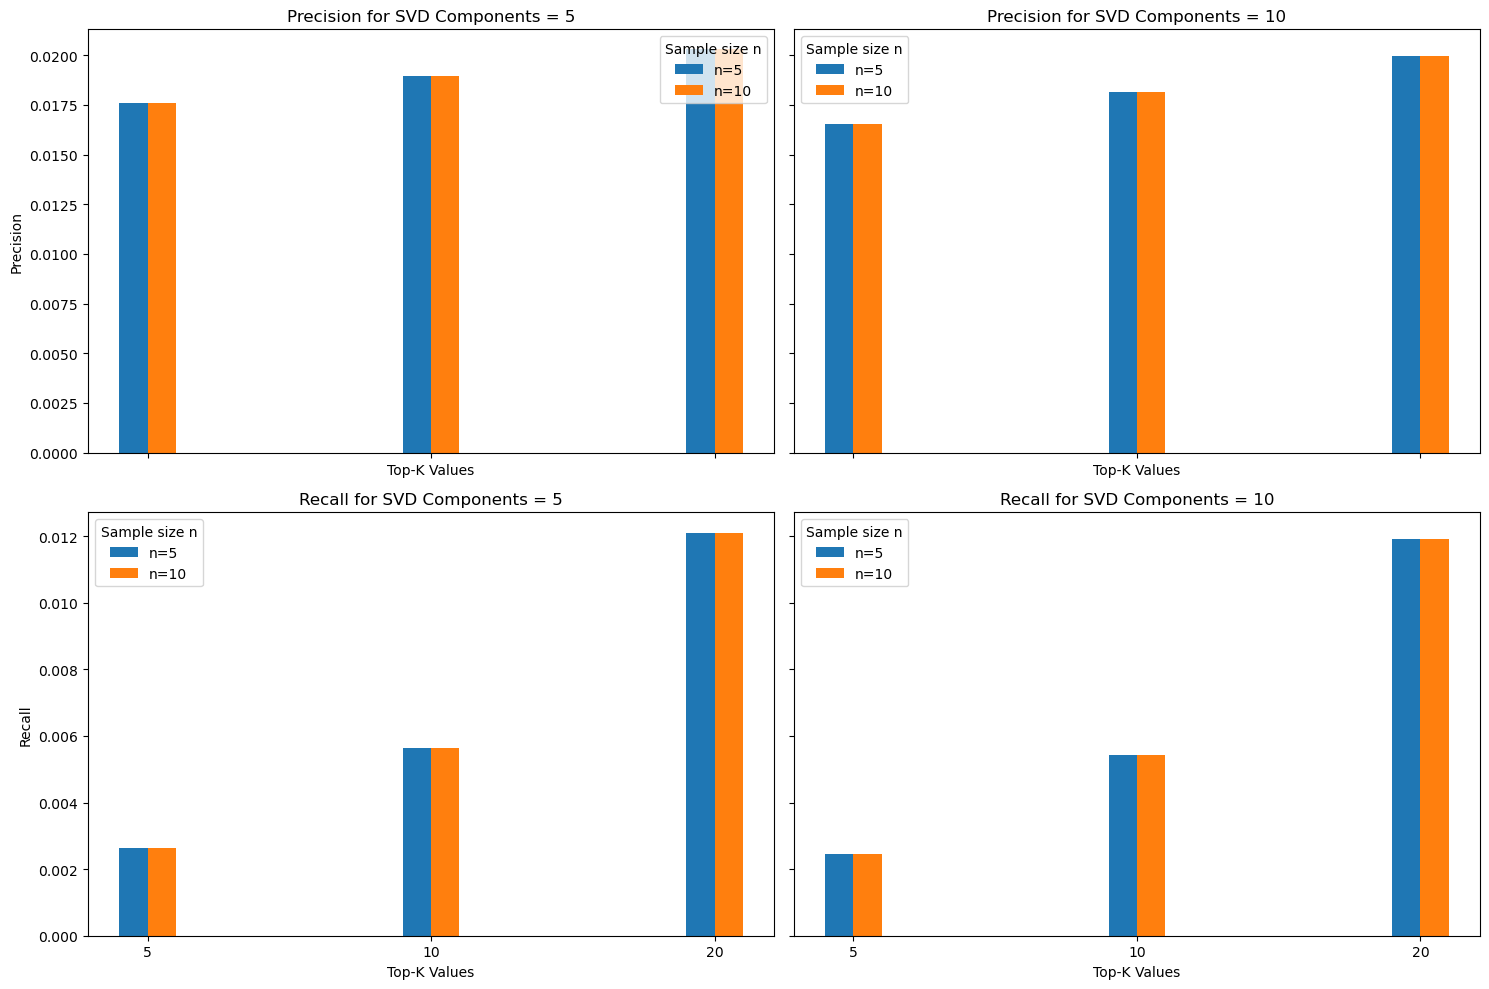

In [ ]:
# Result visualization
plot_evaluation_results(results, top_k_values, n_values)

Download NLTK resources and load the game data

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import json
import nltk

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load games.csv
games_df = pd.read_csv('../dataset/games.csv')

# Initialize a list to hold the metadata
metadata = []

# Read the JSON file line by line
with open('../dataset/games_metadata.json', encoding='utf-8') as f:
    for line in f:
        try:
            metadata.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Convert the metadata list to a DataFrame
metadata_df = pd.json_normalize(metadata)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a2822\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a2822\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a2822\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drop games with missing description or tags

In [ ]:
# Drop rows where 'description' or 'tags' are NaN
metadata_df = metadata_df.dropna(subset=['description', 'tags'])

# Ensure 'description' is not an empty string
metadata_df['description'] = metadata_df['description'].str.strip()

# Remove rows with empty 'description'
metadata_df = metadata_df[metadata_df['description'] != '']

# Ensure 'tags' is not an empty list and remove rows with empty 'tags'
metadata_df = metadata_df[metadata_df['tags'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

metadata_df.reset_index(drop=True, inplace=True)

Conduct a unicode analysis in preparation for preprocessing

In [ ]:
# Importing necessary libraries for unicode analysis
from collections import Counter
import itertools

# Perform unicode analysis to find special characters
special_chars = metadata_df['description'].str.findall(r'[^a-zA-Z0-9\s]').tolist()
special_chars = list(itertools.chain.from_iterable(special_chars))

# Count occurrences of each special character and sort in descending order
sc_counter = Counter(special_chars)
sorted_sc_counter = sorted(sc_counter.items(), key=lambda i: i[1], reverse=True)

# Print the sorted special characters and their counts
for i, (char, count) in enumerate(sorted_sc_counter):
    print(f"{i} {char} {count}")


0 . 74847
1 , 63222
2 - 26820
3 ! 18761
4 ' 9101
5 " 4481
6 ? 4400
7 : 3949
8 ’ 3188
9 ， 2756
10 的 2495
11 ) 1395
12 ( 1358
13 & 1240
14 。 1221
15 / 1126
16 一 1003
17 ” 759
18 “ 728
19 游 689
20 戏 652
21 、 639
22 – 617
23 是 601
24 … 584
25 ; 529
26 人 506
27 — 476
28 在 460
29 + 431
30 《 396
31 》 396
32 中 378
33 ！ 373
34 作 368
35 你 349
36 了 345
37 玩 336
38 大 323
39 为 306
40 战 305
41 * 305
42 款 296
43 不 296
44 以 290
45 有 283
46 家 278
47 ™ 269
48 个 269
49 事 251
50 自 250
51 和 234
52 时 230
53 与 227
54 之 226
55 世 226
56 ‘ 224
57 这 223
58 成 222
59 国 221
60 о 221
61 生 220
62 可 204
63 将 203
64 来 199
65 三 196
66 の 196
67 主 194
68 界 194
69 ® 191
70 同 189
71 多 189
72 能 188
73 е 185
74 上 183
75 开 182
76 到 182
77 ー 181
78 地 176
79 年 175
80 合 175
81 女 173
82 角 170
83 色 169
84 法 168
85 天 167
86 系 164
87 本 164
88 を 161
89 а 158
90 情 155
91 发 154
92 故 154
93 下 153
94 新 152
95 и 152
96 出 152
97 神 148
98 过 147
99 由 144
100 é 142
101 н 141
102 小 141
103 种 138
104 风 136
105 т 136
106 们 134
107 险 133
108 要 133

Remove non-English description games

In [ ]:
# Define a function to check if a text is predominantly non-English
def is_non_english(text, threshold=0.2):
    non_ascii_count = sum(1 for char in text if ord(char) > 127)
    return non_ascii_count / len(text) > threshold

# Apply the function to remove non-English descriptions
metadata_df = metadata_df.loc[metadata_df['description'].apply(lambda x: not is_non_english(x))]
metadata_df.reset_index(drop=True, inplace=True)

# Perform another unicode analysis after the removal
cleaned_chars = metadata_df['description'].str.findall(r'[^a-zA-Z0-9\s]').tolist()
cleaned_chars = list(itertools.chain.from_iterable(cleaned_chars))

# Count occurrences of each special character and sort in descending order
cleaned_sc_counter = Counter(cleaned_chars)
sorted_cleaned_sc_counter = sorted(cleaned_sc_counter.items(), key=lambda i: i[1], reverse=True)

# Print the sorted special characters and their counts
for i, (char, count) in enumerate(sorted_cleaned_sc_counter):
    print(f"{i} {char} {count}")

0 . 74588
1 , 63118
2 - 26746
3 ! 18733
4 ' 9092
5 " 4466
6 ? 4391
7 : 3935
8 ’ 3185
9 ) 1382
10 ( 1345
11 & 1237
12 / 1121
13 ” 646
14 “ 617
15 – 615
16 ; 525
17 … 422
18 + 400
19 — 341
20 ™ 269
21 ‘ 221
22 ® 191
23 * 163
24 é 142
25 ​ 115
26 % 105
27 [ 94
28 ] 93
29 ~ 76
30 # 75
31 《 74
32 》 74
33 | 50
34 á 44
35 _ 42
36 ̷ 42
37 ` 37
38 ㅤ 37
39 ， 36
40 ️ 32
41 ° 31
42 « 31
43 » 30
44 ö 29
45 ！ 29
46 • 28
47 ♂ 28
48 ´ 25
49 = 23
50 「 23
51 」 23
52 ̶ 23
53 、 23
54 $ 21
55 í 21
56 · 20
57 ² 19
58 ü 19
59 @ 17
60 а 17
61 ō 16
62 ^ 16
63 ñ 15
64 ä 14
65 【 14
66 】 14
67 ♥ 13
68 ç 13
69  12
70 ‏ 12
71 ‎ 12
72 ★ 11
73 。 11
74 > 10
75 \ 10
76 ─ 10
77 × 9
78 à 9
79 С 9
80 『 9
81 』 9
82 с 9
83 ï 8
84 ¡ 8
85 ł 8
86 „ 8
87 è 8
88 ê 8
89 ： 8
90 █ 8
91 ı 8
92 ó 8
93 ） 7
94 ř 7
95 🚀 7
96 ë 6
97 ☠ 6
98 î 6
99 ン 6
100 Ⅱ 6
101 （ 5
102 ∇ 5
103 ≠ 5
104 ă 5
105 ？ 5
106 𝐢 5
107 š 5
108 ｅ 5
109 𝗿 5
110 𝗲 5
111 ̕ 5
112 е 5
113 н 5
114 о 5
115 р 5
116 ě 5
117 ☜ 5
118 👑 4
119 ― 4
120 ❤ 4
121 ­ 4
122 ș 4
123 🃏

TODO: ANALYSIS EXPLANATION

Preprocess the metadata

1. unidecode everything
2. lowercase everything
3. replace all "%" with "percentage"
4. replace all hyphen and dashes r'[-—–]' with whitespace
5. remove all r'[\'’]\w{1,2}' cases
6. Remove all r'[^a-zA-Z0-9\s]' characters
7. Tokenize all words using nltk.tokenize module
8. Stopword removal using NLTK stopwords
9.  Lemmatization using WordNetLemmatizer from NLTK (Stemming keep producing invalid words and I dont think its great for the model)

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode

# Initialize lemmatizer and stopwords
wl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_text(text):
    text = unidecode(text)
    text = text.lower()
    text = re.sub(r'%', 'percentage', text)
    text = re.sub(r'[-—–]', ' ', text)
    text = re.sub(r'[\'’]\w{1,2}', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [wl.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to descriptions
metadata_df['processed_description'] = metadata_df['description'].apply(preprocess_text)

print(f'Number of games in metadata_df: {metadata_df.shape[0]}')

# Print the first few rows to check the result
metadata_df[['description', 'processed_description']].head()

Number of games in metadata_df: 39724


,description,processed_description
0,Enter the dark underworld of Prince of Persia ...,enter dark underworld prince persia warrior wi...
1,Monaco: What's Yours Is Mine is a single playe...,monaco mine single player co op heist game ass...
2,Escape Dead Island is a Survival-Mystery adven...,escape dead island survival mystery adventure ...
3,Dungeon of the Endless is a Rogue-Like Dungeon...,dungeon endless rogue like dungeon defense gam...
4,"“METAL SLUG 3”, the masterpiece in SNK’s emble...",metal slug 3 masterpiece snk emblematic 2d run...


Save metadata_df

In [ ]:
import pickle

# Save metadata_df to a file
with open('metadata_df.pkl', 'wb') as f:
    pickle.dump(metadata_df, f)

Load metadata_df if needed

In [ ]:
import pickle

# Load metadata_df from a file
with open('metadata_df.pkl', 'rb') as f:
    metadata_df = pickle.load(f)

Define function for similarity calculation (cosine, euclidean and manhattan)

In [ ]:
import torch
from tqdm import tqdm

# Function to calculate similarity in batches with progress bar
def calculate_similarity_in_batches(tensor, metric='cosine', batch_size=1000):
    num_samples = tensor.size(0)
    similarity_matrix = torch.zeros((num_samples, num_samples), device='cuda')

    for i in tqdm(range(0, num_samples, batch_size), desc="Outer Loop"):
        end_i = min(i + batch_size, num_samples)
        for j in tqdm(range(0, num_samples, batch_size), desc="Inner Loop", leave=False):
            end_j = min(j + batch_size, num_samples)
            if metric == 'cosine':
                similarity_matrix[i:end_i, j:end_j] = torch.mm(tensor[i:end_i].float(), tensor[j:end_j].float().t())
            elif metric == 'euclidean':
                similarity_matrix[i:end_i, j:end_j] = torch.cdist(tensor[i:end_i].float(), tensor[j:end_j].float(), p=2)
            elif metric == 'manhattan':
                similarity_matrix[i:end_i, j:end_j] = torch.cdist(tensor[i:end_i].float(), tensor[j:end_j].float(), p=1)

    if metric != 'cosine':
        similarity_matrix = 1 / (1 + similarity_matrix)
        
    return similarity_matrix

Tags One-Hot Encoding

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix, hstack

# One-Hot Encoding for tags
mlb = MultiLabelBinarizer()
tags_matrix = mlb.fit_transform(metadata_df['tags'])

# Save the one-hot encoded tags matrix
with open('tags_matrix.pkl', 'wb') as f:
    pickle.dump(tags_matrix, f)

# Ensure tags_matrix is in sparse format
tags_matrix_sparse = csr_matrix(tags_matrix)

Count vectorization similarity measure

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
import torch
from tqdm import tqdm

# Count Vectorization
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(metadata_df['processed_description'])

# Save the count matrix
with open('count_matrix.pkl', 'wb') as f:
    pickle.dump(count_matrix, f)

# Ensure count_matrix is in sparse format
count_matrix_sparse = csr_matrix(count_matrix)

# Define weighting schemes
weight_schemes = {
    'no_tags': (1.0, 0.0),
    'count_dominant': (0.75, 0.25),
    'equal': (0.5, 0.5),
    'tags_dominant': (0.25, 0.75)
}

# Calculate and save similarity matrices for Count Vector
for scheme_name, (vector_weight, tags_weight) in weight_schemes.items():
    if scheme_name == 'no_tags':
        combined_tensor = torch.tensor(count_matrix_sparse.toarray()).float().cuda()
    else:
        weighted_vector_matrix = count_matrix_sparse * vector_weight
        weighted_tags_matrix = tags_matrix_sparse * tags_weight
        combined_matrix = hstack([weighted_vector_matrix, weighted_tags_matrix]).toarray()
        combined_tensor = torch.tensor(combined_matrix).float().cuda()

    # Calculate and save similarity matrices
    for metric in ['cosine', 'euclidean', 'manhattan']:
        print(f'Calculating {metric} similarity matrix for count_{scheme_name}...')
        similarity_matrix = calculate_similarity_in_batches(combined_tensor, metric)
        sim_file_name = f'{metric}_count_{scheme_name}.pt'
        torch.save(similarity_matrix, sim_file_name)
        
        # Free up memory for similarity matrix
        del similarity_matrix
        torch.cuda.empty_cache()
        print(f'Saved {metric} similarity matrix for count_{scheme_name}.')

    # Free up memory for combined tensor
    del combined_tensor
    torch.cuda.empty_cache()

    if scheme_name != 'no_tags':
        del combined_matrix
        torch.cuda.empty_cache()

# Free up memory for count_matrix
del count_matrix
del count_matrix_sparse
torch.cuda.empty_cache()



Calculating cosine similarity matrix for count_no_tags...


Outer Loop: 100%|██████████| 40/40 [00:01<00:00, 20.67it/s]


Saved cosine similarity matrix for count_no_tags.
Calculating euclidean similarity matrix for count_no_tags...


Outer Loop: 100%|██████████| 40/40 [00:07<00:00,  5.15it/s]


Saved euclidean similarity matrix for count_no_tags.
Calculating manhattan similarity matrix for count_no_tags...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 223.41it/s]


Saved manhattan similarity matrix for count_no_tags.
Calculating cosine similarity matrix for count_count_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 161.87it/s]


Saved cosine similarity matrix for count_count_dominant.
Calculating euclidean similarity matrix for count_count_dominant...


Outer Loop: 100%|██████████| 40/40 [00:07<00:00,  5.48it/s]


Saved euclidean similarity matrix for count_count_dominant.
Calculating manhattan similarity matrix for count_count_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 191.34it/s]


Saved manhattan similarity matrix for count_count_dominant.
Calculating cosine similarity matrix for count_equal...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 171.63it/s]


Saved cosine similarity matrix for count_equal.
Calculating euclidean similarity matrix for count_equal...


Outer Loop: 100%|██████████| 40/40 [00:06<00:00,  5.74it/s]


Saved euclidean similarity matrix for count_equal.
Calculating manhattan similarity matrix for count_equal...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 218.53it/s]


Saved manhattan similarity matrix for count_equal.
Calculating cosine similarity matrix for count_tags_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 163.90it/s]


Saved cosine similarity matrix for count_tags_dominant.
Calculating euclidean similarity matrix for count_tags_dominant...


Outer Loop: 100%|██████████| 40/40 [00:07<00:00,  5.61it/s]


Saved euclidean similarity matrix for count_tags_dominant.
Calculating manhattan similarity matrix for count_tags_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 212.95it/s]


Saved manhattan similarity matrix for count_tags_dominant.


TF-IDF vectorization similarity measure

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
import torch
from tqdm import tqdm

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(metadata_df['processed_description'])

# Save the TF-IDF matrix
with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

# Ensure tfidf_matrix is in sparse format
tfidf_matrix_sparse = csr_matrix(tfidf_matrix)

# Define weighting schemes
weight_schemes = {
    'no_tags': (1.0, 0.0),
    'tfidf_dominant': (0.75, 0.25),
    'equal': (0.5, 0.5),
    'tags_dominant': (0.25, 0.75)
}

# Calculate and save similarity matrices for TF-IDF Vector
for scheme_name, (vector_weight, tags_weight) in weight_schemes.items():
    if scheme_name == 'no_tags':
        combined_tensor = torch.tensor(tfidf_matrix_sparse.toarray()).float().cuda()
    else:
        weighted_vector_matrix = tfidf_matrix_sparse * vector_weight
        weighted_tags_matrix = tags_matrix_sparse * tags_weight
        combined_matrix = hstack([weighted_vector_matrix, weighted_tags_matrix]).toarray()
        combined_tensor = torch.tensor(combined_matrix).float().cuda()

    # Calculate and save similarity matrices
    for metric in ['cosine', 'euclidean', 'manhattan']:
        print(f'Calculating {metric} similarity matrix for tfidf_{scheme_name}...')
        similarity_matrix = calculate_similarity_in_batches(combined_tensor, metric)
        sim_file_name = f'{metric}_tfidf_{scheme_name}.pt'
        torch.save(similarity_matrix, sim_file_name)
        
        # Free up memory for similarity matrix
        del similarity_matrix
        torch.cuda.empty_cache()
        print(f'Saved {metric} similarity matrix for tfidf_{scheme_name}.')

    # Free up memory for combined tensor
    del combined_tensor
    torch.cuda.empty_cache()

    if scheme_name != 'no_tags':
        del combined_matrix
        torch.cuda.empty_cache()

# Free up memory for tfidf_matrix
del tfidf_matrix
del tfidf_matrix_sparse
torch.cuda.empty_cache()


Calculating cosine similarity matrix for tfidf_no_tags...


Outer Loop: 100%|██████████| 40/40 [00:01<00:00, 21.44it/s]


Saved cosine similarity matrix for tfidf_no_tags.
Calculating euclidean similarity matrix for tfidf_no_tags...


Outer Loop: 100%|██████████| 40/40 [00:07<00:00,  5.68it/s]


Saved euclidean similarity matrix for tfidf_no_tags.
Calculating manhattan similarity matrix for tfidf_no_tags...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 200.22it/s]


Saved manhattan similarity matrix for tfidf_no_tags.
Calculating cosine similarity matrix for tfidf_tfidf_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 163.23it/s]


Saved cosine similarity matrix for tfidf_tfidf_dominant.
Calculating euclidean similarity matrix for tfidf_tfidf_dominant...


Outer Loop: 100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


Saved euclidean similarity matrix for tfidf_tfidf_dominant.
Calculating manhattan similarity matrix for tfidf_tfidf_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 211.59it/s]


Saved manhattan similarity matrix for tfidf_tfidf_dominant.
Calculating cosine similarity matrix for tfidf_equal...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 179.33it/s]


Saved cosine similarity matrix for tfidf_equal.
Calculating euclidean similarity matrix for tfidf_equal...


Outer Loop: 100%|██████████| 40/40 [00:07<00:00,  5.60it/s]


Saved euclidean similarity matrix for tfidf_equal.
Calculating manhattan similarity matrix for tfidf_equal...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 205.08it/s]


Saved manhattan similarity matrix for tfidf_equal.
Calculating cosine similarity matrix for tfidf_tags_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 176.95it/s]


Saved cosine similarity matrix for tfidf_tags_dominant.
Calculating euclidean similarity matrix for tfidf_tags_dominant...


Outer Loop: 100%|██████████| 40/40 [00:07<00:00,  5.62it/s]


Saved euclidean similarity matrix for tfidf_tags_dominant.
Calculating manhattan similarity matrix for tfidf_tags_dominant...


Outer Loop: 100%|██████████| 40/40 [00:00<00:00, 220.94it/s]


Saved manhattan similarity matrix for tfidf_tags_dominant.


Load Recommendation csv for evaluation

In [ ]:
# Load recommendations.csv
recommendations_df = pd.read_csv('../dataset/recommendations.csv')

# Filter out invalid app_ids from recommendations_df
valid_app_ids = set(metadata_df['app_id'].unique())
recommended_df = recommendations_df[recommendations_df['app_id'].isin(valid_app_ids)]

# Group by user_id to get a list of recommended games for each user
user_recommendations = recommended_df.groupby('user_id')['app_id'].apply(list).reset_index()

Find out recommendation stat of each user in our dataset

Average user only recommend 2.7 games which makes it hard for us to evaluate their interest, and perhaps inaccurate to measure user(with low recommendation amount)'s interest since at the moment I only have two evaluation scheme: 
- If we evaluate based on whether the recommended game exist as an exact match to user's recommendation, it is highly unlikely to hit as it is similar to a 1 in 40k chance to find exact match.
- If we evaluate based on number of the recommended game's tags hit the user's recommendation's games' tags, it would be too easy since our mixed matrix contain tags one-hot encoding so we naturally match games with similar tags. And when the train set is small, the evaluation would consider a total hit too easily.

I set a minimum recommendation threshold to 10 to only include user with above 10 recommendations to our recommendation evaluation

In [ ]:
# Calculate the average number of recommendations per user
user_recommendations['num_recommendations'] = user_recommendations['app_id'].apply(len)
average_recommendations = user_recommendations['num_recommendations'].mean()

print(f'Average number of recommendations per user: {average_recommendations}')

# Display the distribution of recommendations
print(user_recommendations['num_recommendations'].describe())

# Define a threshold for the minimum number of recommendations per user
min_rec_threshold = 10

# Filter out users with fewer than the threshold number of recommendations
filtered_user_recommendations = user_recommendations[user_recommendations['num_recommendations'] >= min_rec_threshold]

# Display the number of users remaining after filtering
print(f'Number of users after filtering: {filtered_user_recommendations.shape[0]}')

# Save filtered_user_recommendations to a file
with open('filtered_user_recommendations.pkl', 'wb') as f:
    pickle.dump(filtered_user_recommendations, f)


Average number of recommendations per user: 2.7098103791691734
count    7.449498e+06
mean     2.709810e+00
std      9.009576e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.915000e+03
Name: num_recommendations, dtype: float64
Number of users after filtering: 297062


Display the stats on the filtered user's profile

The average recommendation is now 23, which is sufficient for our our evaluation task

In [ ]:
# Display statistics of the filtered user recommendations
print("Statistics of the filtered user recommendations:")
print(filtered_user_recommendations['num_recommendations'].describe())

Statistics of the filtered user recommendations:
count    297062.000000
mean         23.040274
std          39.330329
min          10.000000
25%          12.000000
50%          15.000000
75%          23.000000
max        5915.000000
Name: num_recommendations, dtype: float64


Reload files and libraries if needed (I restart my notebook from this point for faster memory clear and evaluation)

In [ ]:
import pandas as pd
import numpy as np
import torch
import pickle
from tqdm import tqdm

# Load metadata_df from a file
with open('metadata_df.pkl', 'rb') as f:
    metadata_df = pickle.load(f)

# Load filtered_user_recommendations from a file
with open('filtered_user_recommendations.pkl', 'rb') as f:
    filtered_user_recommendations = pickle.load(f)

Consider an evaluation method of calculating precision/recall/f1 by do a k-fold split of each user's game recommendation. Then use the training set to recommend a list of top-n games, then checking recommended games' tags against test set games' tags. This is calculated by collect all recommended games' tag as a set, then match against the training set's game tags, which is a set as well. This is much more generous but considering we dont have an objective measure in the dataset to what are all the games the user like (not just recommend), this is a compromising evaluation method. Many user may like or purchased games but dont necessarily "recommend" (since it require writing a review and often considered an effort) of them on steam.

Test with tf-idf and count vectorization with cosine, euclidean and manhattan as similarity measure with top-10 recommendation, testing with a sample user size of 500 as this computaion is very time consuming and 500 is around a reasonble time for me to run and test the code. I experiment with higher user size later and the result have been similar.

In [ ]:
from sklearn.model_selection import KFold

# Define functions for recommendation and evaluation
def get_recommendations_by_ids(app_ids, sim, n=10):
    sim_scores = torch.zeros(sim.shape[0], device='cuda')
    
    for app_id in app_ids:
        try:
            idx = metadata_df.index[metadata_df['app_id'] == app_id].tolist()[0]
            sim_scores += sim[idx]
        except IndexError:
            continue
    
    sim_scores = sim_scores / len(app_ids)  # Average similarity
    sim_scores = sim_scores.cpu().numpy()  # Move to CPU for sorting
    
    # Exclude known relevant app_ids from recommendations
    game_indices = np.argsort(-sim_scores)
    recommended_game_indices = [idx for idx in game_indices if metadata_df['app_id'].iloc[idx] not in app_ids]
    
    # Return the top n recommendations
    return metadata_df['app_id'].iloc[recommended_game_indices[:n]].tolist()

def tag_precision_recall_f1(recommended, relevant_tags):
    hits = 0
    recommended_tags = set()
    
    # Collect all tags from the recommended games
    for app_id in recommended:
        tags = set(metadata_df[metadata_df['app_id'] == app_id]['tags'].values[0])
        recommended_tags.update(tags)
    
    # Calculate hits
    hits = len(recommended_tags.intersection(relevant_tags))
    
    precision = hits / len(recommended_tags) if len(recommended_tags) > 0 else 0
    recall = hits / len(relevant_tags) if len(relevant_tags) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return precision, recall, f1

# Sample 500 users from the filtered dataset
sampled_users = filtered_user_recommendations.sample(n=500, random_state=42)

# Define top-N value to evaluate
top_n_value = 10

# List of similarity matrices and their corresponding names
similarity_matrices = {
    'cosine_count_count_dominant.pt': 'Cosine - Count - Count Dominant',
    'cosine_tfidf_tfidf_dominant.pt': 'Cosine - TF-IDF - TF-IDF Dominant',
    'euclidean_count_count_dominant.pt': 'Euclidean - Count - Count Dominant',
    'euclidean_tfidf_tfidf_dominant.pt': 'Euclidean - TF-IDF - TF-IDF Dominant',
    'manhattan_count_count_dominant.pt': 'Manhattan - Count - Count Dominant',
    'manhattan_tfidf_tfidf_dominant.pt': 'Manhattan - TF-IDF - TF-IDF Dominant'
}

# Dictionary to store results for each similarity matrix
all_results = {}

# Initialize k-fold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate for each similarity matrix
for sim_file, sim_name in similarity_matrices.items():
    # Load the similarity matrix
    sim = torch.load(sim_file).cuda()

    # Store results
    results = {
        'top_n': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    # Using tqdm to show progress bar
    for index, row in tqdm(sampled_users.iterrows(), desc=f"Evaluating Users using {sim_name}", total=sampled_users.shape[0]):
        user_id = row['user_id']
        relevant = row['app_id']
        relevant = relevant if isinstance(relevant, list) else [relevant]  # Ensure relevant is a list
        
        if len(relevant) < 5:  # Ensure at least 5 games for k-fold
            continue

        user_kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for train_index, test_index in user_kf.split(relevant):
            train_games = [relevant[i] for i in train_index]
            test_games = [relevant[i] for i in test_index]

            relevant_tags = set()
            for app_id in test_games:
                relevant_tags.update(metadata_df[metadata_df['app_id'] == app_id]['tags'].values[0])

            recommended = get_recommendations_by_ids(train_games, sim, n=top_n_value)
            precision, recall, f1 = tag_precision_recall_f1(recommended, relevant_tags)
            
            results['precision'].append(precision)
            results['recall'].append(recall)
            results['f1'].append(f1)

    # Calculate average precision, recall, and F1 score for top-N value
    avg_precision = np.mean(results['precision']) if results['precision'] else 0
    avg_recall = np.mean(results['recall']) if results['recall'] else 0
    avg_f1 = np.mean(results['f1']) if results['f1'] else 0

    # Store the results
    all_results[sim_name] = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

    # Free up memory
    del sim
    torch.cuda.empty_cache()

print("Evaluation completed and results saved.")

Evaluating Users using Cosine - Count - Count Dominant: 100%|██████████| 500/500 [09:24<00:00,  1.13s/it]
Evaluating Users using Cosine - TF-IDF - TF-IDF Dominant: 100%|██████████| 500/500 [09:47<00:00,  1.18s/it]
Evaluating Users using Euclidean - Count - Count Dominant: 100%|██████████| 500/500 [09:51<00:00,  1.18s/it]
Evaluating Users using Euclidean - TF-IDF - TF-IDF Dominant: 100%|██████████| 500/500 [09:22<00:00,  1.13s/it]
Evaluating Users using Manhattan - Count - Count Dominant: 100%|██████████| 500/500 [09:39<00:00,  1.16s/it]
Evaluating Users using Manhattan - TF-IDF - TF-IDF Dominant: 100%|██████████| 500/500 [09:23<00:00,  1.13s/it]

Evaluation completed and results saved.


Plot the result

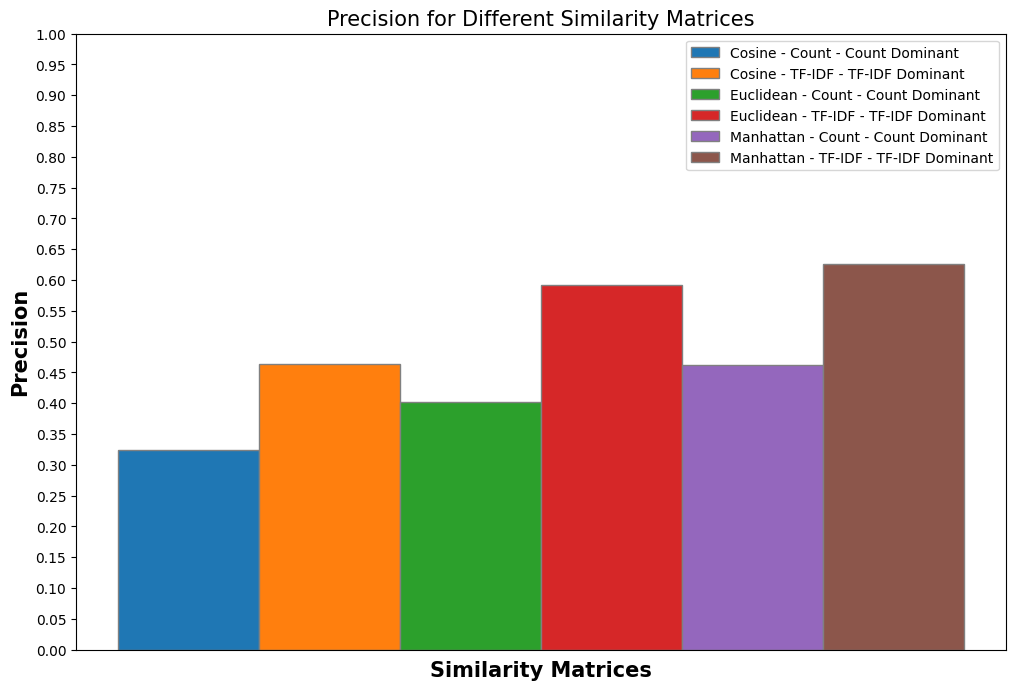

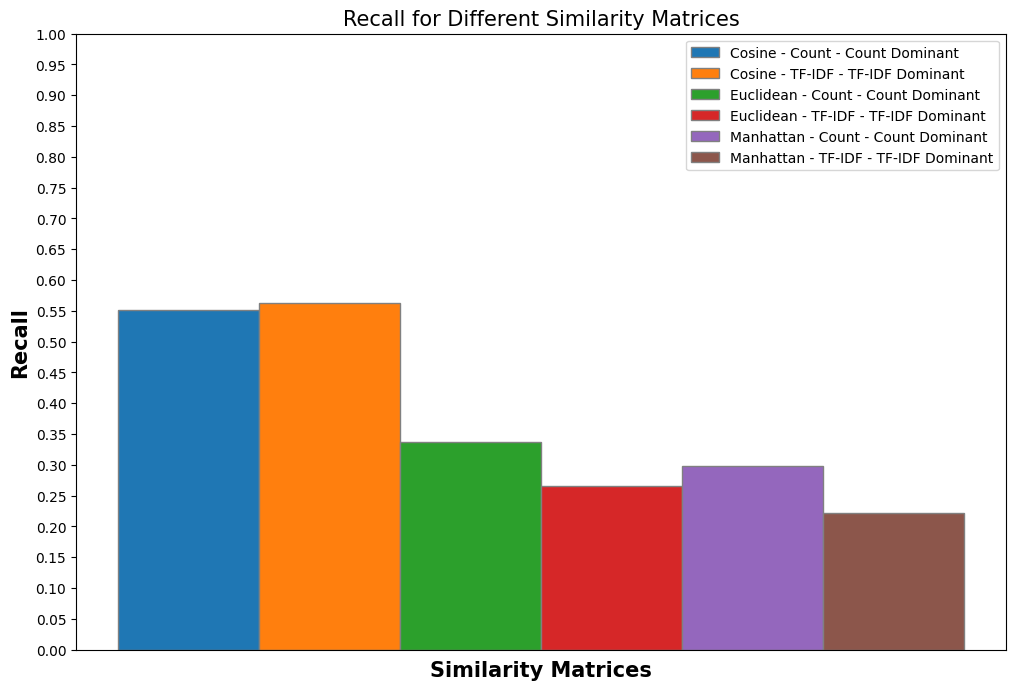

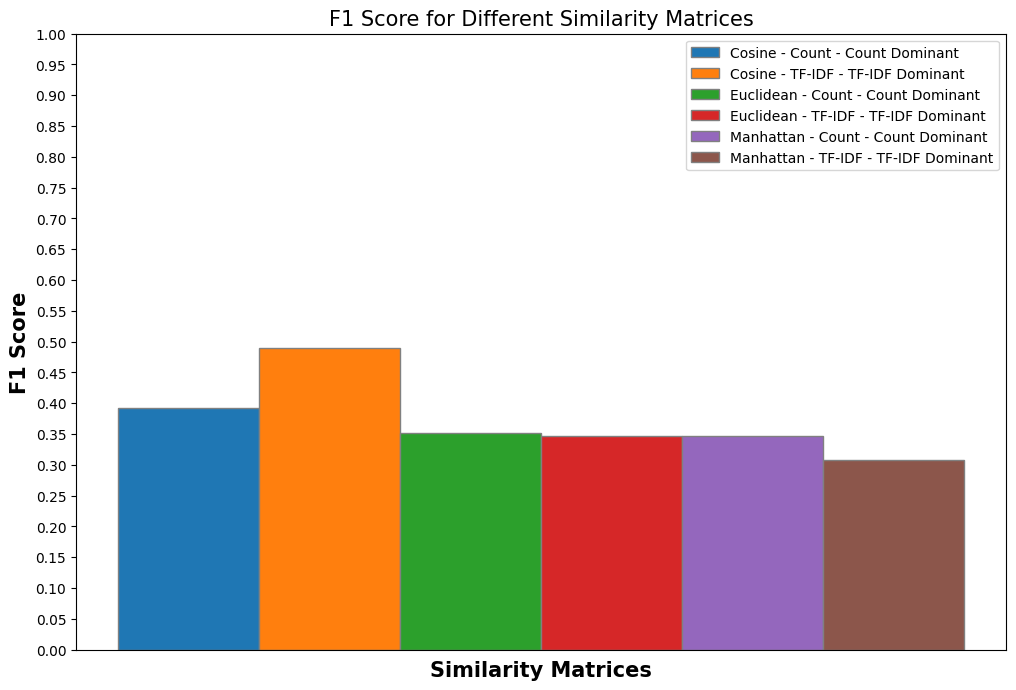

In [ ]:
import matplotlib.pyplot as plt

# Define top-N values
top_n_values = [10]  # since we're only evaluating top-10

# Function to plot metrics
def plot_metrics(metric_name, ylabel):
    barWidth = 0.2
    fig, ax = plt.subplots(figsize=(12, 8))

    br1 = np.arange(len(top_n_values))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]
    br6 = [x + barWidth for x in br5]

    ax.bar(br1, [all_results['Cosine - Count - Count Dominant'][metric_name]], width=barWidth, edgecolor='grey', label='Cosine - Count - Count Dominant')
    ax.bar(br2, [all_results['Cosine - TF-IDF - TF-IDF Dominant'][metric_name]], width=barWidth, edgecolor='grey', label='Cosine - TF-IDF - TF-IDF Dominant')
    ax.bar(br3, [all_results['Euclidean - Count - Count Dominant'][metric_name]], width=barWidth, edgecolor='grey', label='Euclidean - Count - Count Dominant')
    ax.bar(br4, [all_results['Euclidean - TF-IDF - TF-IDF Dominant'][metric_name]], width=barWidth, edgecolor='grey', label='Euclidean - TF-IDF - TF-IDF Dominant')
    ax.bar(br5, [all_results['Manhattan - Count - Count Dominant'][metric_name]], width=barWidth, edgecolor='grey', label='Manhattan - Count - Count Dominant')
    ax.bar(br6, [all_results['Manhattan - TF-IDF - TF-IDF Dominant'][metric_name]], width=barWidth, edgecolor='grey', label='Manhattan - TF-IDF - TF-IDF Dominant')

    plt.title(f'{ylabel} for Different Similarity Matrices', fontsize=15)
    plt.xlabel('Similarity Matrices', fontweight='bold', fontsize=15)
    plt.ylabel(ylabel, fontweight='bold', fontsize=15)
    plt.xticks([r + barWidth for r in range(len(results['top_n']))], results['top_n'])
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.legend()
    plt.show()

# Plot precision, recall, and F1 score
plot_metrics('precision', 'Precision')
plot_metrics('recall', 'Recall')
plot_metrics('f1', 'F1 Score')


Since tf-idf with cosine performs with the best f1, we experiment with some more ti-idf&cosine related matrix and with more top-n.

In [ ]:
from sklearn.model_selection import KFold

def get_recommendations_by_ids(app_ids, sim, n_values):
    sim_scores = torch.zeros(sim.shape[0], device='cuda')
    
    for app_id in app_ids:
        try:
            idx = metadata_df.index[metadata_df['app_id'] == app_id].tolist()[0]
            sim_scores += sim[idx]
        except IndexError:
            continue
    
    sim_scores = sim_scores / len(app_ids)  # Average similarity
    sim_scores = sim_scores.cpu().numpy()  # Move to CPU for sorting
    
    # Exclude known relevant app_ids from recommendations
    game_indices = np.argsort(-sim_scores)
    recommended_game_indices = [idx for idx in game_indices if metadata_df['app_id'].iloc[idx] not in app_ids]
    
    recommendations = {}
    for n in n_values:
        recommendations[n] = metadata_df['app_id'].iloc[recommended_game_indices[:n]].tolist()
    
    return recommendations

def tag_precision_recall_f1(recommended, relevant_tags):
    precision_recall_f1 = {}
    
    for n, recs in recommended.items():
        hits = 0
        recommended_tags = set()
        
        # Collect all tags from the recommended games
        for app_id in recs:
            tags = set(metadata_df[metadata_df['app_id'] == app_id]['tags'].values[0])
            recommended_tags.update(tags)
        
        # Calculate hits
        hits = len(recommended_tags.intersection(relevant_tags))
        
        precision = hits / len(recommended_tags) if len(recommended_tags) > 0 else 0
        recall = hits / len(relevant_tags) if len(relevant_tags) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        
        precision_recall_f1[n] = (precision, recall, f1)
    
    return precision_recall_f1

# Sample 500 users from the filtered dataset
sampled_users = filtered_user_recommendations.sample(n=500, random_state=42)

# Define a range of top-N values to evaluate
top_n_values = [5, 10, 15, 20]

# List of similarity matrices and their corresponding names
similarity_matrices = {
    'cosine_tfidf_no_tags.pt': 'No Tags',
    'cosine_tfidf_equal.pt': 'Equal Weights',
    'cosine_tfidf_tfidf_dominant.pt': 'TF-IDF Dominant',
    'cosine_tfidf_tags_dominant.pt': 'Tags Dominant'
}

# Dictionary to store results for each similarity matrix
tfidf_results = {}

# Initialize k-fold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate for each similarity matrix
for sim_file, sim_name in similarity_matrices.items():
    # Load the similarity matrix
    cosine_sim = torch.load(sim_file).cuda()

    # Store results for each top-N value
    results = {n: {'precision': [], 'recall': [], 'f1': []} for n in top_n_values}

    # Evaluate tag precision, recall, and F1 score for each top-N value
    for index, row in tqdm(sampled_users.iterrows(), desc=f"Evaluating Users using {sim_name}", total=sampled_users.shape[0]):
        user_id = row['user_id']
        relevant = row['app_id']
        relevant = relevant if isinstance(relevant, list) else [relevant]  # Ensure relevant is a list
        
        if len(relevant) < 5:  # Ensure at least 5 games for k-fold
            continue

        user_kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for train_index, test_index in user_kf.split(relevant):
            train_games = [relevant[i] for i in train_index]
            test_games = [relevant[i] for i in test_index]

            relevant_tags = set()
            for app_id in test_games:
                relevant_tags.update(metadata_df[metadata_df['app_id'] == app_id]['tags'].values[0])

            recommended = get_recommendations_by_ids(train_games, cosine_sim, n_values=top_n_values)
            precision_recall_f1 = tag_precision_recall_f1(recommended, relevant_tags)
            
            for n in top_n_values:
                precision, recall, f1 = precision_recall_f1[n]
                results[n]['precision'].append(precision)
                results[n]['recall'].append(recall)
                results[n]['f1'].append(f1)

    # Calculate and store the average precision, recall, and F1 score for each top-N value
    for n in top_n_values:
        avg_precision = np.mean(results[n]['precision']) if results[n]['precision'] else 0
        avg_recall = np.mean(results[n]['recall']) if results[n]['recall'] else 0
        avg_f1 = np.mean(results[n]['f1']) if results[n]['f1'] else 0
        
        results[n] = {
            'precision': avg_precision,
            'recall': avg_recall,
            'f1': avg_f1
        }

    # Store the results for the current similarity matrix
    tfidf_results[sim_name] = results

    # Free up memory
    del cosine_sim
    torch.cuda.empty_cache()

print("Evaluation completed and results saved.")


Evaluating Users using Tags Dominant: 100%|██████████| 500/500 [09:31<00:00,  1.14s/it]

Evaluation completed and results saved.


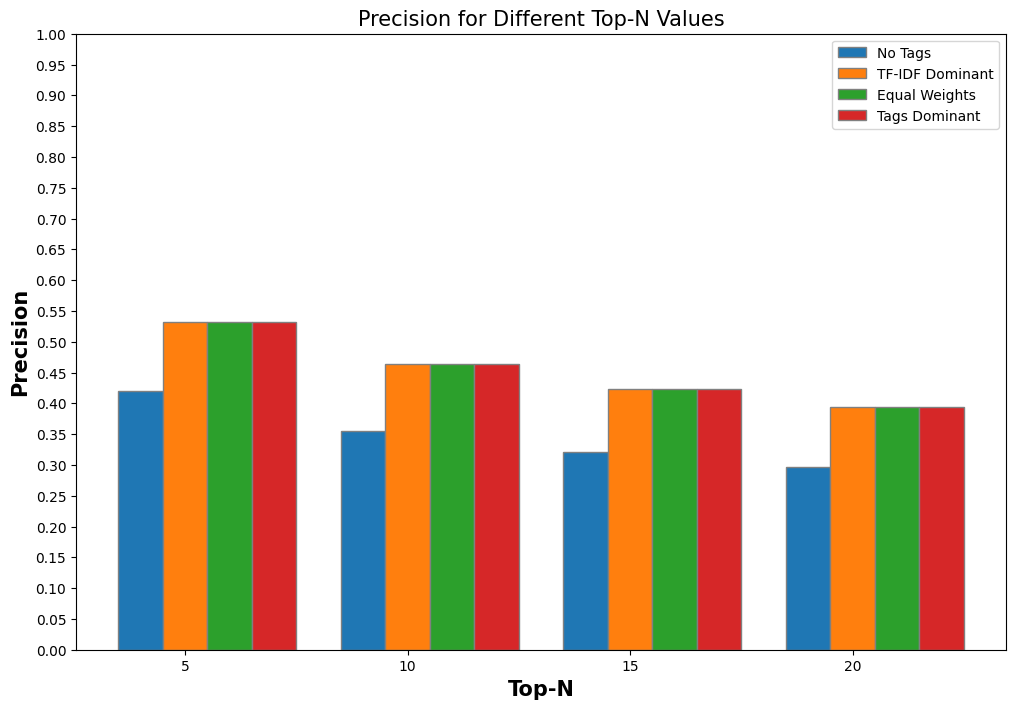

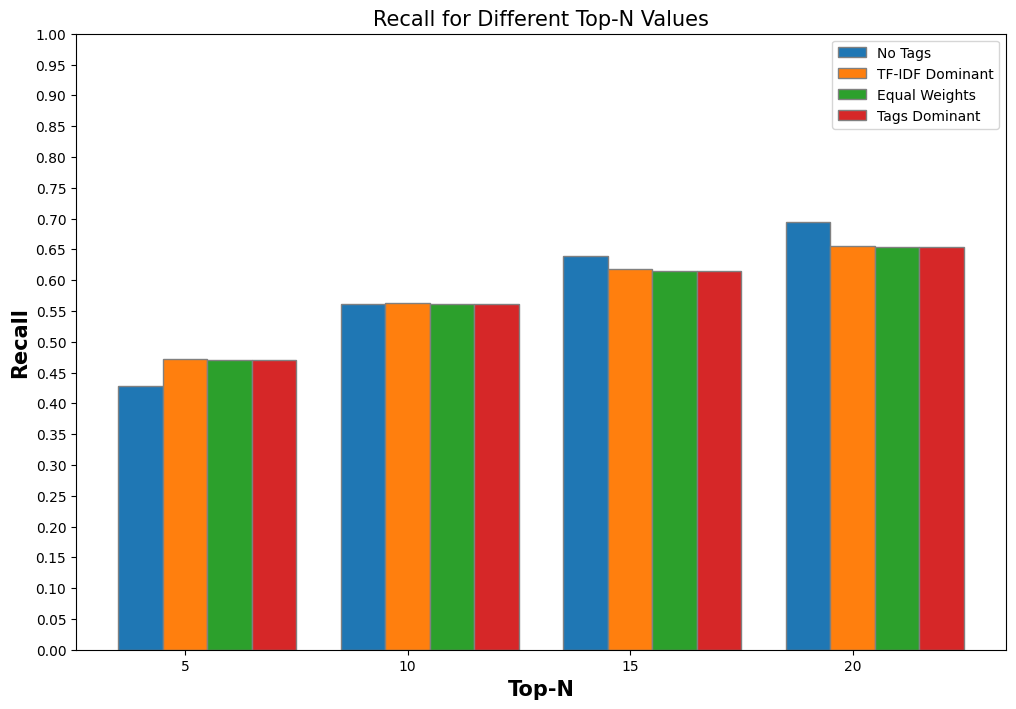

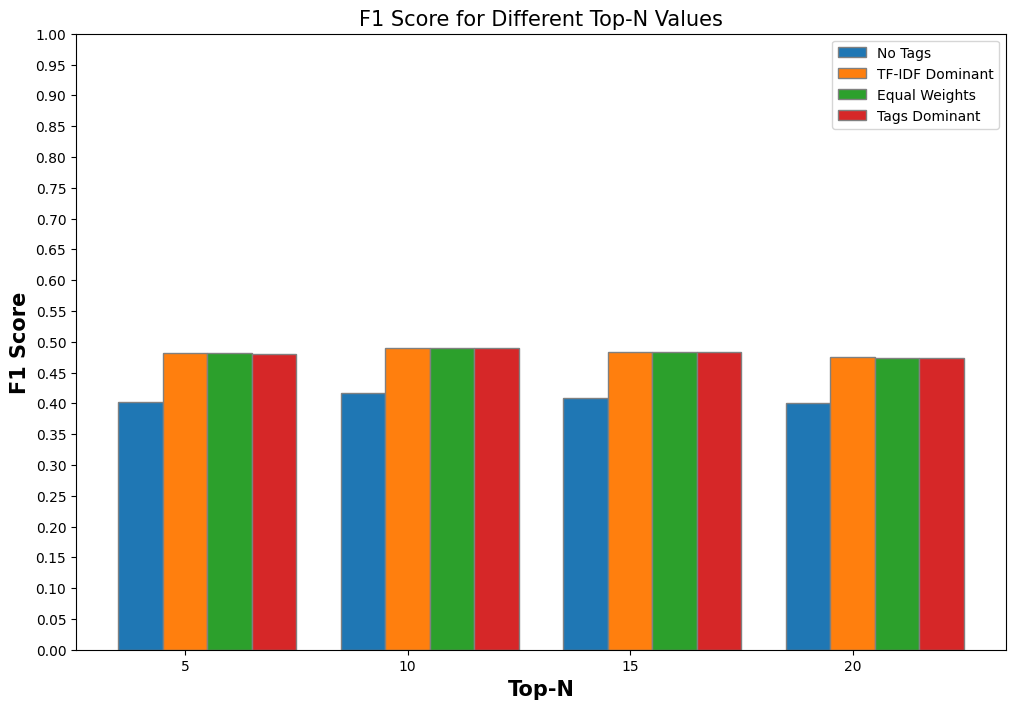

In [ ]:
import matplotlib.pyplot as plt

# Load the evaluation results
with open('evaluation_results.pkl', 'rb') as f:
    all_results = pickle.load(f)

# Define top-N values
top_n_values = [5, 10, 15, 20]

# Function to plot metrics
def plot_metrics(metric_name, ylabel):
    barWidth = 0.2
    fig, ax = plt.subplots(figsize=(12, 8))

    br1 = np.arange(len(top_n_values))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    ax.bar(br1, [tfidf_results['No Tags'][n][metric_name] for n in top_n_values], width=barWidth, edgecolor='grey', label='No Tags')
    ax.bar(br2, [tfidf_results['TF-IDF Dominant'][n][metric_name] for n in top_n_values], width=barWidth, edgecolor='grey', label='TF-IDF Dominant')
    ax.bar(br3, [tfidf_results['Equal Weights'][n][metric_name] for n in top_n_values], width=barWidth, edgecolor='grey', label='Equal Weights')
    ax.bar(br4, [tfidf_results['Tags Dominant'][n][metric_name] for n in top_n_values], width=barWidth, edgecolor='grey', label='Tags Dominant')

    plt.title(f'{ylabel} for Different Top-N Values', fontsize=15)
    plt.xlabel('Top-N', fontweight='bold', fontsize=15)
    plt.ylabel(ylabel, fontweight='bold', fontsize=15)
    plt.xticks([r + barWidth for r in range(len(top_n_values))], top_n_values)
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.legend()
    plt.show()

# Plot precision, recall, and F1 score
plot_metrics('precision', 'Precision')
plot_metrics('recall', 'Recall')
plot_metrics('f1', 'F1 Score')

Overall it follows the general trend of higher n lowers precision but raises recall, and a rough sweet spot is at n=10.

Evaluate precision recall and f1 at top n if we only consider hit if the recommended game is in the user's recommendation

In [ ]:
from sklearn.model_selection import KFold

# Clear GPU cache
torch.cuda.empty_cache()
# Load the precomputed similarity matrix and move to GPU
cosine_sim = torch.load('cosine_tfidf_tfidf_dominant.pt').cuda()

# Define functions for precision, recall, F1 score, and recommendation retrieval
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum(1 for item in recommended_k if item in relevant_set)
    return hits / k

def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum(1 for item in recommended_k if item in relevant_set)
    return hits / len(relevant)

def f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def get_recommendations_by_ids(app_ids, sim, n_values):
    sim_scores = torch.zeros(sim.shape[0], device='cuda')
    
    for app_id in app_ids:
        try:
            idx = metadata_df.index[metadata_df['app_id'] == app_id].tolist()[0]
            sim_scores += sim[idx]
        except IndexError:
            continue
    
    sim_scores = sim_scores / len(app_ids)  # Average similarity
    sim_scores = sim_scores.cpu().numpy()  # Move to CPU for sorting
    
    # Exclude known relevant app_ids from recommendations
    game_indices = np.argsort(-sim_scores)
    recommended_game_indices = [idx for idx in game_indices if metadata_df['app_id'].iloc[idx] not in app_ids]
    
    recommendations = {}
    for n in n_values:
        recommendations[n] = metadata_df['app_id'].iloc[recommended_game_indices[:n]].tolist()
    
    return recommendations

# Sample 500 users from the filtered dataset
sampled_users = filtered_user_recommendations.sample(n=500, random_state=42)

# Define a range of top-N values to evaluate
top_n_values = [5, 10, 15, 20]

# Initialize k-fold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables to store precision, recall, and F1 scores for plotting
precision_results = {n: [] for n in top_n_values}
recall_results = {n: [] for n in top_n_values}
f1_results = {n: [] for n in top_n_values}

# Evaluate for each user
for index, row in tqdm(sampled_users.iterrows(), desc="Evaluating Users", total=sampled_users.shape[0]):
    user_id = row['user_id']
    relevant = row['app_id']
    relevant = relevant if isinstance(relevant, list) else [relevant]  # Ensure relevant is a list
    
    if len(relevant) < 5:  # Ensure at least 5 games for k-fold
        continue

    user_kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in user_kf.split(relevant):
        train_games = [relevant[i] for i in train_index]
        test_games = [relevant[i] for i in test_index]

        recommended = get_recommendations_by_ids(train_games, cosine_sim, n_values=top_n_values)
        
        for n in top_n_values:
            precision = precision_at_k(recommended[n], test_games, n)
            recall = recall_at_k(recommended[n], test_games, n)
            f1 = f1_score(precision, recall)

            precision_results[n].append(precision)
            recall_results[n].append(recall)
            f1_results[n].append(f1)

# Calculate average precision, recall, and F1 score for each top-N value
avg_precision = {n: np.mean(precision_results[n]) for n in top_n_values}
avg_recall = {n: np.mean(recall_results[n]) for n in top_n_values}
avg_f1 = {n: np.mean(f1_results[n]) for n in top_n_values}

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)

# Store the results in a DataFrame for plotting
results_df = pd.DataFrame({
    'N': top_n_values,
    'Precision': [avg_precision[n] for n in top_n_values],
    'Recall': [avg_recall[n] for n in top_n_values],
    'F1 Score': [avg_f1[n] for n in top_n_values]
})

print("Evaluation completed and results saved.")


Evaluating Users: 100%|██████████| 500/500 [08:41<00:00,  1.04s/it]

Average Precision: {5: 0.02008, 10: 0.016, 15: 0.013173333333333336, 20: 0.011680000000000001}
Average Recall: {5: 0.026957936192462506, 10: 0.043732928270216194, 15: 0.05353210068844124, 20: 0.06332232015318702}
Average F1 Score: {5: 0.02151142002500949, 10: 0.022055926435792874, 15: 0.019946261472262333, 20: 0.01872863813903565}
Evaluation completed and results saved.


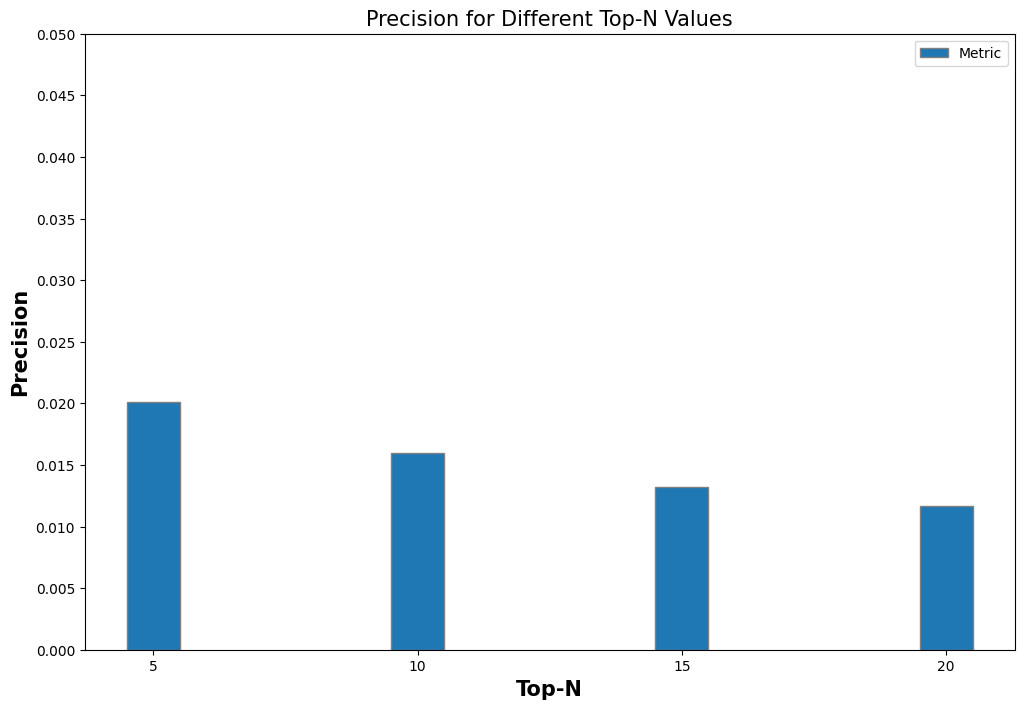

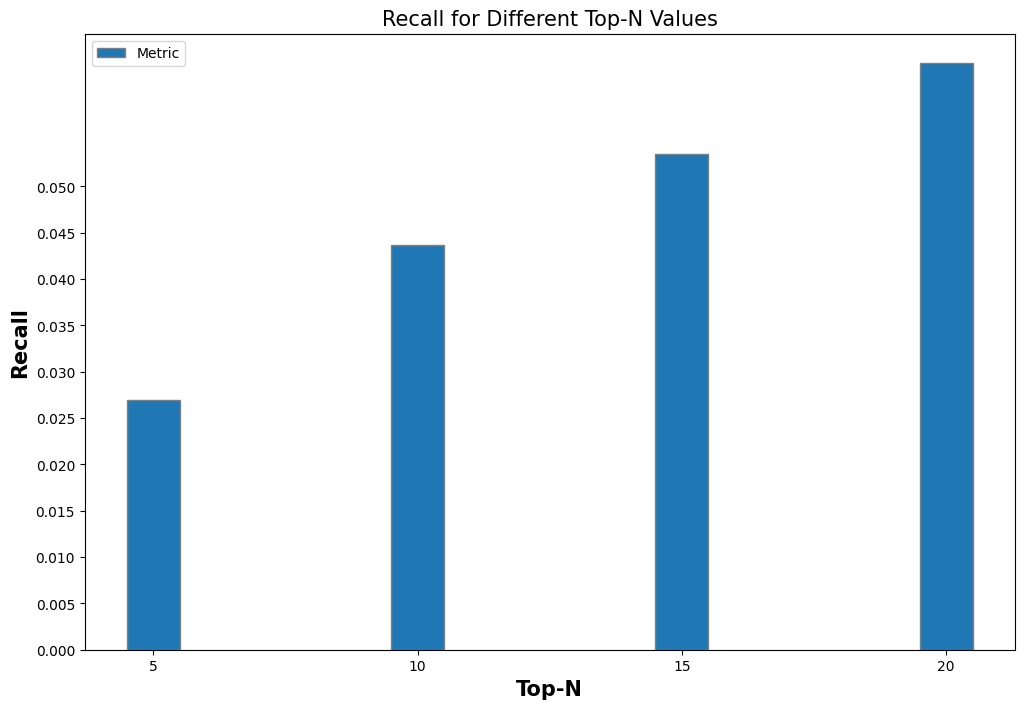

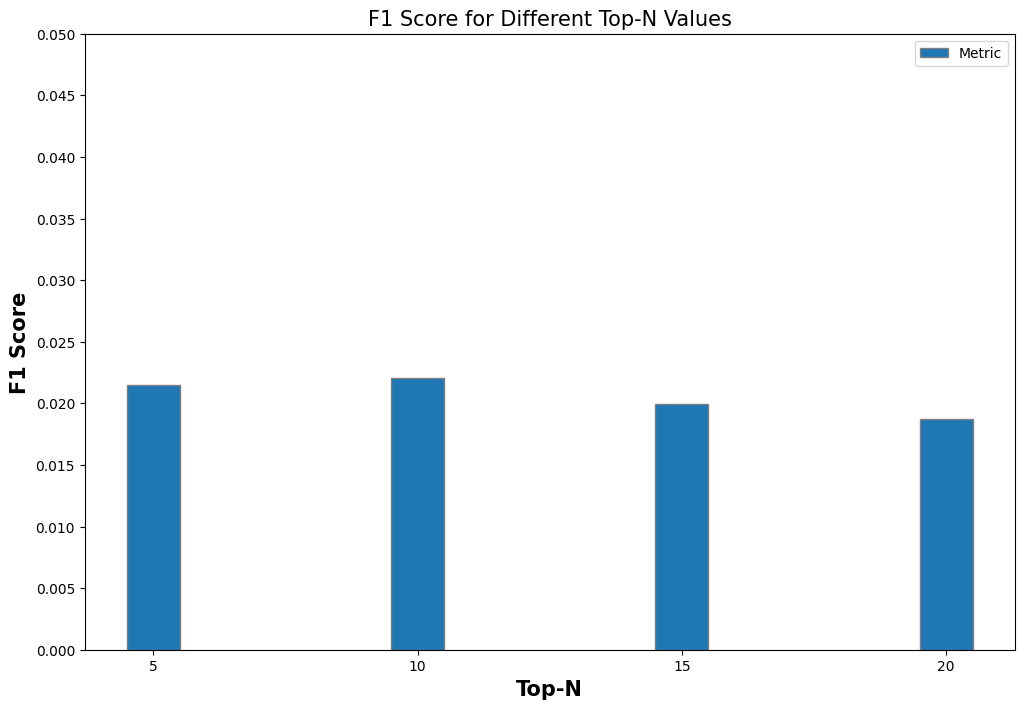

In [ ]:
import matplotlib.pyplot as plt

# Define top-N values
top_n_values = results_df['N'].tolist()

# Function to plot metrics
def plot_metrics(metric_name, ylabel):
    barWidth = 0.2
    fig, ax = plt.subplots(figsize=(12, 8))

    br1 = np.arange(len(top_n_values))

    ax.bar(br1, results_df[metric_name], width=barWidth, edgecolor='grey', label='Metric')

    plt.title(f'{ylabel} for Different Top-N Values', fontsize=15)
    plt.xlabel('Top-N', fontweight='bold', fontsize=15)
    plt.ylabel(ylabel, fontweight='bold', fontsize=15)
    plt.xticks([r for r in range(len(top_n_values))], top_n_values)
    plt.yticks(np.arange(0, 0.055, 0.005))
    plt.legend()
    plt.show()

# Plot precision, recall, and F1 score
plot_metrics('Precision', 'Precision')
plot_metrics('Recall', 'Recall')
plot_metrics('F1 Score', 'F1 Score')


Overall, the f1 is around 0.023 with this evaluation method, this is very underwhelming and likely not a realistic representation of user's interest to the recommended games. Therefore, even though the previous method may have a biased interest with tags, it would have perhaps still be more realistic than this rigid exact matching style of evaluation.

Lastly, test with an increased sample user size from 500 to 5000 to check if there are any noticeable difference

In [ ]:
import torch
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.model_selection import KFold

def get_recommendations_by_ids(app_ids, sim, n_values):
    sim_scores = torch.zeros(sim.shape[0], device='cuda')
    
    for app_id in app_ids:
        try:
            idx = metadata_df.index[metadata_df['app_id'] == app_id].tolist()[0]
            sim_scores += sim[idx]
        except IndexError:
            continue
    
    sim_scores = sim_scores / len(app_ids)  # Average similarity
    sim_scores = sim_scores.cpu().numpy()  # Move to CPU for sorting
    
    # Exclude known relevant app_ids from recommendations
    game_indices = np.argsort(-sim_scores)
    recommended_game_indices = [idx for idx in game_indices if metadata_df['app_id'].iloc[idx] not in app_ids]
    
    recommendations = {}
    for n in n_values:
        recommendations[n] = metadata_df['app_id'].iloc[recommended_game_indices[:n]].tolist()
    
    return recommendations

def tag_precision_recall_f1(recommended, relevant_tags):
    precision_recall_f1 = {}
    
    for n, recs in recommended.items():
        hits = 0
        recommended_tags = set()
        
        # Collect all tags from the recommended games
        for app_id in recs:
            tags = set(metadata_df[metadata_df['app_id'] == app_id]['tags'].values[0])
            recommended_tags.update(tags)
        
        # Calculate hits
        hits = len(recommended_tags.intersection(relevant_tags))
        
        precision = hits / len(recommended_tags) if len(recommended_tags) > 0 else 0
        recall = hits / len(relevant_tags) if len(relevant_tags) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        
        precision_recall_f1[n] = (precision, recall, f1)
    
    return precision_recall_f1

# Define the top-N value to evaluate
top_n_values = [10]

# Load metadata_df from a file
with open('metadata_df.pkl', 'rb') as f:
    metadata_df = pickle.load(f)

# Load filtered_user_recommendations from a file
with open('filtered_user_recommendations.pkl', 'rb') as f:
    filtered_user_recommendations = pickle.load(f)

# Sample 500 users from the filtered dataset
sampled_users = filtered_user_recommendations.sample(n=5000, random_state=42)

# Load the best-performing similarity matrix
sim_file = 'cosine_tfidf_tfidf_dominant.pt'
sim_name = 'TF-IDF Dominant'
cosine_sim = torch.load(sim_file).cuda()

# Store results for each top-N value
results = {n: {'precision': [], 'recall': [], 'f1': []} for n in top_n_values}

# Evaluate tag precision, recall, and F1 score for each top-N value
for index, row in tqdm(sampled_users.iterrows(), desc=f"Evaluating Users using {sim_name}", total=sampled_users.shape[0]):
    user_id = row['user_id']
    relevant = row['app_id']
    relevant = relevant if isinstance(relevant, list) else [relevant]  # Ensure relevant is a list
    
    if len(relevant) < 5:  # Ensure at least 5 games for k-fold
        continue

    user_kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in user_kf.split(relevant):
        train_games = [relevant[i] for i in train_index]
        test_games = [relevant[i] for i in test_index]

        relevant_tags = set()
        for app_id in test_games:
            relevant_tags.update(metadata_df[metadata_df['app_id'] == app_id]['tags'].values[0])

        recommended = get_recommendations_by_ids(train_games, cosine_sim, n_values=top_n_values)
        precision_recall_f1 = tag_precision_recall_f1(recommended, relevant_tags)
        
        for n in top_n_values:
            precision, recall, f1 = precision_recall_f1[n]
            results[n]['precision'].append(precision)
            results[n]['recall'].append(recall)
            results[n]['f1'].append(f1)

# Calculate and store the average precision, recall, and F1 score for each top-N value
for n in top_n_values:
    avg_precision = np.mean(results[n]['precision']) if results[n]['precision'] else 0
    avg_recall = np.mean(results[n]['recall']) if results[n]['recall'] else 0
    avg_f1 = np.mean(results[n]['f1']) if results[n]['f1'] else 0
    
    results[n] = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

# Print the results for the selected top-N value
for n in top_n_values:
    print(f"Top-{n} Results for {sim_name}:")
    print(f"Precision: {results[n]['precision']}")
    print(f"Recall: {results[n]['recall']}")
    print(f"F1 Score: {results[n]['f1']}")

# Free up memory
del cosine_sim
torch.cuda.empty_cache()


Evaluating Users using TF-IDF Dominant: 100%|██████████| 5000/5000 [1:39:48<00:00,  1.20s/it]

Top-10 Results for TF-IDF Dominant:
Precision: 0.467543801344799
Recall: 0.5541325052163518
F1 Score: 0.48529643178632687


As this test with higher sample user indicates an increase in data size does not influence the result by much and is indicative that our previous evaluation would have been mostly valid with the full filtered user size as well

# 3.Rank Layer

## 3.1 Feature Engineering


In [ ]:
# Merge `spark_game_df` and `spark_game_info_df` to create `spark_completed_game_df` after processing.
spark_game_df.show(2)
print("======= after processing =======")
spark_completed_game_df = process_game_df(spark_game_df, spark_game_info_df)
spark_completed_game_df.show(2)

+-------+--------------------+------------+----+-----+-----+-------------+--------------+------------+-----------+--------------+--------+----------+
| app_id|               title|date_release| win|  mac|linux|       rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+-------+--------------------+------------+----+-----+-----+-------------+--------------+------------+-----------+--------------+--------+----------+
|1541020|Kakele Online - M...|  2021-04-15|true| true| true|Very Positive|            84|         158|        0.0|           0.0|     0.0|      true|
|1566230|Turn on all the l...|  2021-03-31|true|false| true|Very Positive|            93|          60|       0.99|          0.99|     0.0|      true|
+-------+--------------------+------------+----+-----+-----+-------------+--------------+------------+-----------+--------------+--------+----------+
only showing top 2 rows

======= after processing =======
+-------+--------------------+------------

In [ ]:
# Process the review information to extract useful data.
spark_review_df.show(2)
print("======= after processing =======")
# User Feature Processing
spark_review_df = process_review_df(spark_review_df)
spark_review_df.show(2)

+--------------+-------+------+----------+-----+
|is_recommended|user_id|app_id|      date|hours|
+--------------+-------+------+----------+-----+
|         false|6473513|213610|2021-09-30|  3.0|
|          true|2185259|213610|2021-03-29| 81.5|
+--------------+-------+------+----------+-----+
only showing top 2 rows

======= after processing =======
+--------------+-------+------+-----------+-----+----------+-----+
|is_recommended|user_id|app_id|review_date|hours| review_ts|label|
+--------------+-------+------+-----------+-----+----------+-----+
|         false|6473513|213610| 2021-09-30|  3.0|1632960000|    0|
|          true|2185259|213610| 2021-03-29| 81.5|1616976000|    1|
+--------------+-------+------+-----------+-----+----------+-----+
only showing top 2 rows



In [ ]:
# Merge user features and game features to create `user_item_interactions_df`, the user interaction table.
user_item_interactions_df = generate_interactions_df(
    spark_review_df, spark_completed_game_df
)
# user_item_interactions_df.tail(5).show()
user_item_interactions_df.orderBy(F.desc("tags")).limit(5).show()

+-------+--------------+--------+-----------+-----+----------+-----+--------------+---+---+-----+--------------+--------------+------------+----------+--------+----------+--------------------+
| app_id|is_recommended| user_id|review_date|hours| review_ts|label|app_release_ts|win|mac|linux|numeric_rating|positive_ratio|user_reviews|price_diff|discount|steam_deck|                tags|
+-------+--------------+--------+-----------+-----+----------+-----+--------------+---+---+-----+--------------+--------------+------------+----------+--------+----------+--------------------+
|1499540|         false|11695280| 2021-08-26|  0.1|1629936000|    0|    1635811200|  1|  0|    0|             5|            63|          19|       0.0|     0.0|         1|[eSports, Real Ti...|
|1499540|          true| 9283098| 2021-11-04|  6.6|1635984000|    1|    1635811200|  1|  0|    0|             5|            63|          19|       0.0|     0.0|         1|[eSports, Real Ti...|
|1499540|         false|13086459| 2

In [ ]:
# Process user preference interactions (label = 1) with the top 50 most liked tags and time window `review_ts` to create `liked_interactions_df`.
from pyspark.sql.window import Window
from collections import Counter
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql import functions as F

# sort by review_ts
windowSpec = Window\
            .partitionBy('user_id')\
            .orderBy('review_ts').rowsBetween(Window.unboundedPreceding, Window.currentRow)

user_recommended_filter = lambda colname: F.when(F.col('label') == 1, F.col(colname)).otherwise(F.lit(None))

@F.udf(ArrayType(StringType()))
def topN_liked_tags(tags_nested, topN=50):
    flat_tags = [tag for sublist in tags_nested for tag in sublist]
    tag_counts = Counter(flat_tags)
    most_common_tags = tag_counts.most_common(topN)
    return [tag for tag, _ in most_common_tags]

liked_interactions_df = user_item_interactions_df \
    .withColumn('user_review_count', F.count(F.lit(1)).over(windowSpec)) \
    .withColumn('user_hours_mean', F.round(F.mean(F.col('hours')).over(windowSpec), 2)) \
    .withColumn('user_hours_std', F.round(F.stddev(F.col('hours')).over(windowSpec), 2)) \
    .withColumn('user_liked_release_ts_mean',
                F.round(F.mean(user_recommended_filter('app_release_ts')).over(windowSpec),0))\
    .withColumn("collected_tags", F.collect_list(user_recommended_filter('tags')).over(windowSpec))\
    .withColumn("top50_liked_tags",topN_liked_tags('collected_tags', F.lit(50)))

# liked_interactions_df = liked_interactions_df.drop('collected_tags')
liked_interactions_df.show(5)

+------+--------------+-------+-----------+-----+----------+-----+--------------+---+---+-----+--------------+--------------+------------+----------+--------+----------+--------------------+-----------------+---------------+--------------+--------------------------+--------------------+--------------------+
|app_id|is_recommended|user_id|review_date|hours| review_ts|label|app_release_ts|win|mac|linux|numeric_rating|positive_ratio|user_reviews|price_diff|discount|steam_deck|                tags|user_review_count|user_hours_mean|user_hours_std|user_liked_release_ts_mean|      collected_tags|    top50_liked_tags|
+------+--------------+-------+-----------+-----+----------+-----+--------------+---+---+-----+--------------+--------------+------------+----------+--------+----------+--------------------+-----------------+---------------+--------------+--------------------------+--------------------+--------------------+
|872200|          true|     26| 2021-09-02| 12.4|1630540800|    1|    162

In [ ]:
# Normalize game feature values using Min-Max scaling.
item_features2minmax = [
    'numeric_rating',
    'positive_ratio',
    'user_reviews',
    'price_diff',
    'discount',
    'app_release_ts',
]

# Normalize user feature values using Min-Max scaling.
user_features2minmax = [
    'user_review_count',
    'user_hours_mean',
    'user_hours_std',
    'user_liked_release_ts_mean',
]

user_minmax_scaler = NumMinMaxScaler(user_features2minmax)
item_minmax_scaler = NumMinMaxScaler(item_features2minmax)

item_minmax_scaler.fit(liked_interactions_df)
user_minmax_scaler.fit(liked_interactions_df)

liked_interactions_df = item_minmax_scaler.transform(liked_interactions_df)
liked_interactions_df = user_minmax_scaler.transform(liked_interactions_df)

item_tags_encoder = TagEncoder('tags')
item_tags_encoder.fit(liked_interactions_df, spark)
liked_interactions_df = item_tags_encoder.transform(liked_interactions_df)

liked_tags_encoder = TagEncoder('top50_liked_tags')
liked_tags_encoder.fit(liked_interactions_df, spark)
liked_interactions_df = liked_tags_encoder.transform(liked_interactions_df)

# liked_interactions_df.write.parquet('/content/drive/MyDrive/9727/liked_interactions_df', mode='overwrite')
liked_interactions_df = spark.read.parquet("/content/drive/MyDrive/9727/liked_interactions_df")
liked_interactions_df.show(5)

+-------+--------------+-------+-----------+-----+----------+-----+--------------+---+---+-----+--------------+--------------+------------+----------+--------+----------+--------------------+-----------------+---------------+--------------+--------------------------+--------------------+--------------------+---------------------+---------------------+-------------------+-----------------+---------------+---------------------+------------------------+----------------------+---------------------+---------------------------------+--------------------+-------------------------+
| app_id|is_recommended|user_id|review_date|hours| review_ts|label|app_release_ts|win|mac|linux|numeric_rating|positive_ratio|user_reviews|price_diff|discount|steam_deck|                tags|user_review_count|user_hours_mean|user_hours_std|user_liked_release_ts_mean|      collected_tags|    top50_liked_tags|numeric_rating_scaled|positive_ratio_scaled|user_reviews_scaled|price_diff_scaled|discount_scaled|app_release_

In [ ]:
# Fetch data to compute user features and item features for predictions.
full_user_features_df = spark.read.parquet("/content/drive/MyDrive/9727/liked_interactions_df")
full_user_features_df.show(2)
spark_high_5_active_review_df = spark.read.parquet('/content/drive/MyDrive/9727/spark_high_5_active_review_df.parquet')
spark_high_5_active_review_df.show(2)

+-------+--------------+-------+-----------+-----+----------+-----+--------------+---+---+-----+--------------+--------------+------------+----------+--------+----------+----+-----------------+---------------+--------------+--------------------------+--------------+----------------+---------------------+---------------------+-------------------+-----------------+---------------+---------------------+------------------------+----------------------+---------------------+---------------------------------+--------------------+-------------------------+
| app_id|is_recommended|user_id|review_date|hours| review_ts|label|app_release_ts|win|mac|linux|numeric_rating|positive_ratio|user_reviews|price_diff|discount|steam_deck|tags|user_review_count|user_hours_mean|user_hours_std|user_liked_release_ts_mean|collected_tags|top50_liked_tags|numeric_rating_scaled|positive_ratio_scaled|user_reviews_scaled|price_diff_scaled|discount_scaled|app_release_ts_scaled|user_review_count_scaled|user_hours_mean_s

In [ ]:
# Features for predictions: Game features for the top 5 most active users' preferred games.
unique_app_active_review_df = spark_high_5_active_review_df.select("app_id").distinct()

item_features = [
    'app_id',
    'win',
    'mac',
    'linux',
    'steam_deck',
    'numeric_rating_scaled',
    'positive_ratio_scaled',
    'user_reviews_scaled',
    'price_diff_scaled',
    'discount_scaled',
    'app_release_ts_scaled',
    'tags_multihot'
]

top5liked_game_feature_df = unique_app_active_review_df.join(
    full_user_features_df,
    on="app_id",
    how="inner"
).select(item_features)

top5liked_game_feature_df = top5liked_game_feature_df.dropDuplicates()
top5liked_game_feature_df.show(2)
top5liked_game_feature_df.write.mode('overwrite').parquet('/content/drive/MyDrive/9727/rank_mlp/top5liked_game_feature_df.parquet')


+------+---+---+-----+----------+---------------------+---------------------+-------------------+-----------------+---------------+---------------------+--------------------+
|app_id|win|mac|linux|steam_deck|numeric_rating_scaled|positive_ratio_scaled|user_reviews_scaled|price_diff_scaled|discount_scaled|app_release_ts_scaled|       tags_multihot|
+------+---+---+-----+----------+---------------------+---------------------+-------------------+-----------------+---------------+---------------------+--------------------+
|  3800|  1|  0|    0|         1|                 0.88|                  0.8|                0.0|              0.4|            0.0|                 0.35|[1, 1, 0, 0, 0, 0...|
| 11190|  1|  0|    0|         1|                 0.62|                 0.78|                0.0|              0.4|            0.0|                 0.48|[1, 0, 1, 0, 0, 1...|
+------+---+---+-----+----------+---------------------+---------------------+-------------------+-----------------+----------

In [ ]:
# Features for predictions: User features for the top 5 most active users.
from pyspark.sql import SparkSession
from pyspark.sql.functions import broadcast
unique_top5user_review_df = spark_high_5_active_review_df.select("user_id").distinct()

# Optimize join operations using broadcast variables.
broadcast_unique_user_ids = broadcast(unique_top5user_review_df)

try:
    latest_top5_user_features_df = full_user_features_df.join(
    broadcast_unique_user_ids,
    on="user_id",
    how="inner").select(
    "user_id",
    "review_ts",
    'user_hours_mean_scaled',
    'user_hours_std_scaled',
    'user_liked_release_ts_mean_scaled',
    'top50_liked_tags_multihot')

    # Create temporary views and use SQL queries.
    latest_top5_user_features_df.createOrReplaceTempView("user_features")

    # Use SQL queries to select the most recent record for each user.
    query = """
    SELECT *
    FROM (
        SELECT user_id, review_ts, user_hours_mean_scaled, user_hours_std_scaled,
              user_liked_release_ts_mean_scaled, top50_liked_tags_multihot,
              ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY review_ts DESC) as row_num
        FROM user_features
    ) tmp
    WHERE row_num = 1
    """

    latest_top5_user_features_df = spark.sql(query)

    # save
    latest_top5_user_features_df.write.mode('overwrite').parquet('./latest_top5_user_features_df.parquet')

except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
latest_top5_user_features_df.show(10)

+-------+----------+----------------------+---------------------+---------------------------------+-------------------------+-------+
|user_id| review_ts|user_hours_mean_scaled|user_hours_std_scaled|user_liked_release_ts_mean_scaled|top50_liked_tags_multihot|row_num|
+-------+----------+----------------------+---------------------+---------------------------------+-------------------------+-------+
|    191|1672185600|                  0.05|                  0.1|                             0.67|     [1, 1, 1, 1, 1, 1...|      1|
|   1840|1606435200|                  0.05|                 0.09|                              0.7|     [1, 1, 1, 1, 1, 1...|      1|
|   2040|1640131200|                  0.07|                 0.16|                             0.77|     [1, 1, 1, 1, 1, 1...|      1|
|  13452|1658534400|                  0.11|                 0.25|                             0.86|     [1, 0, 0, 1, 1, 0...|      1|
|  15221|1635724800|                  0.03|                 0.

In [ ]:
latest_top5_user_features_df.write.mode('overwrite').parquet('/content/drive/MyDrive/9727/rank_mlp/latest_top5_user_features_df.parquet')


In [ ]:
latest_top5_user_features_df.show(2)

+-------+-------+--------------+-----------+-----+----------+
|user_id| app_id|is_recommended|review_date|hours| review_ts|
+-------+-------+--------------+-----------+-----+----------+
|      0| 627690|          true| 2022-03-06|103.3|1646524800|
|    191|1961460|         false| 2022-12-28|  8.4|1672185600|
+-------+-------+--------------+-----------+-----+----------+
only showing top 2 rows



In [ ]:
# Filter features of high-activity users from the full dataset based on their IDs.
def collect_part_features_from_full(review_df, full_features_df):
    high_active_user_ids_df = review_df.select("user_id").distinct()

    filtered_features_df = full_features_df.join(
      high_active_user_ids_df,
      on="user_id",
      how="inner"
  )
    return filtered_features_df

high_5_active_user_features_df = collect_part_features_from_full(spark_high_5_active_review_df, full_user_features_df)
# high_5_active_user_features_df.write.parquet('/content/drive/MyDrive/9727/high_5_active_user_features_df.parquet', mode='overwrite')
# high_5_active_user_features_df = spark.read.parquet("/content/drive/MyDrive/9727/high_5_active_user_features_df.parquet")
high_5_active_user_features_df.show(2)

### 3.1.1 Prepare the feature data for the preferences of the top 5% most active users for model training

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from tqdm import tqdm
def collect_training_features(df):
    # Ensure all numeric columns are of numeric type.
    item_features_num = [
        'win', 'mac', 'linux', 'steam_deck', 'numeric_rating_scaled', 'positive_ratio_scaled',
        'user_reviews_scaled', 'price_diff_scaled', 'discount_scaled', 'app_release_ts_scaled'
    ]
    user_features_num = [
        'user_hours_mean_scaled', 'user_hours_std_scaled', 'user_liked_release_ts_mean_scaled'
    ]

    for col_name in item_features_num + user_features_num:
        df = df.withColumn(
            col_name,
            when(col(col_name).isNull(), lit(0.0)).otherwise(col(col_name).cast(DoubleType()))
        )

    # Directly convert multi-hot encoded label columns to integer type arrays.
    feat_tags_multihot = np.array(df.select("tags_multihot").rdd.map(lambda row: np.array(row[0], dtype=np.int32)).collect())
    feat_liked_tags_multihot = np.array(df.select("top50_liked_tags_multihot").rdd.map(lambda row: np.array(row[0], dtype=np.int32)).collect())
    feat_item = np.array(df.select(*item_features_num).rdd.map(lambda row: list(row)).collect())
    feat_user = np.array(df.select(*user_features_num).rdd.map(lambda row: list(row)).collect())
    feat_user = np.nan_to_num(feat_user, nan=0.0)
    feat_item = np.nan_to_num(feat_item, nan=0.0)

    return feat_tags_multihot, feat_liked_tags_multihot, feat_item, feat_user


def collect_labels(df):
    return np.array(df.select("label").rdd.map(lambda row: row[0]).collect())


def collect_features_in_batches(df, batch_size=2000000):
    total_rows = df.count()
    num_batches = (total_rows + batch_size - 1) // batch_size
    all_results = []

    # Use tqdm to display progress bar
    for i in tqdm(range(num_batches), desc="Processing Batches"):
        # Calculate the start and end index for the current batch
        start_idx = i * batch_size
        end_idx = start_idx + batch_size if (start_idx + batch_size) < total_rows else total_rows

        # Get the current batch of data from the DataFrame
        # Use `rdd`'s `zipWithIndex` to split the data
        df_rdd = df.rdd.zipWithIndex()
        df_batch_rdd = df_rdd.filter(lambda x: start_idx <= x[1] < end_idx).map(lambda x: x[0])
        df_batch = spark.createDataFrame(df_batch_rdd, df.schema)

        # Process the current batch of data
        results = collect_training_features(df_batch)
        all_results.append(results)

    return all_results

# process data
results = collect_features_in_batches(high_5_active_user_features_df, batch_size=2000000)
# save_to_dill(results, 'mlp_high_5_active_user_features.dill', '/content/drive/MyDrive/9727/mlp_high_5_active_user_features/')
# combine features
feat_tags_multihot = np.concatenate([result[0] for result in results], axis=0)
feat_liked_tags_multihot = np.concatenate([result[1] for result in results], axis=0)
feat_item = np.concatenate([result[2] for result in results], axis=0)
feat_user = np.concatenate([result[3] for result in results], axis=0)

Processing Batches: 100%|██████████| 8/8 [1:09:53<00:00, 524.14s/it]


In [ ]:
spark.sparkContext.setLogLevel("DEBUG")
print(np.any(np.isnan(feat_tags_multihot)))
print(np.any(np.isnan(feat_liked_tags_multihot)))
print(np.any(np.isnan(feat_item)))
print(np.any(np.isnan(feat_user)))

False
False
False
False


In [ ]:
actual_label = collect_labels(high_5_active_user_features_df)
print(np.any(np.isnan(actual_label)))

False


In [ ]:
user_recommendations_map_top5_2w = load_dill_file("/content/user_recommendations_map_top5_2w.dill")

In [ ]:
!cp -r /content/drive/MyDrive/9727/rank_mlp/top5liked_game_feature_df.parquet ./


In [ ]:
latest_top5_user_features_df = spark.read.parquet("/content/drive/MyDrive/9727/rank_mlp/latest_top5_user_features_df.parquet")
top5liked_game_feature_df = spark.read.parquet("/content/drive/MyDrive/9727/rank_mlp/top5liked_game_feature_df.parquet")

In [ ]:
top5liked_game_feature_df.show(10)

+------+---+---+-----+----------+---------------------+---------------------+-------------------+-----------------+---------------+---------------------+--------------------+
|app_id|win|mac|linux|steam_deck|numeric_rating_scaled|positive_ratio_scaled|user_reviews_scaled|price_diff_scaled|discount_scaled|app_release_ts_scaled|       tags_multihot|
+------+---+---+-----+----------+---------------------+---------------------+-------------------+-----------------+---------------+---------------------+--------------------+
|  1670|  1|  0|    0|         1|                  0.5|                 0.63|                0.0|              0.4|            0.0|                 0.35|[1, 0, 0, 0, 0, 0...|
|  2320|  1|  0|    0|         1|                 0.88|                 0.94|                0.0|             0.35|            0.0|                 0.39|[0, 0, 0, 0, 0, 0...|
|  2540|  1|  0|    0|         1|                  0.5|                 0.64|                0.0|              0.4|          

In [ ]:
latest_top5_user_features_df.show(2)


+-------+----------+----------------------+---------------------+---------------------------------+-------------------------+-------+
|user_id| review_ts|user_hours_mean_scaled|user_hours_std_scaled|user_liked_release_ts_mean_scaled|top50_liked_tags_multihot|row_num|
+-------+----------+----------------------+---------------------+---------------------------------+-------------------------+-------+
|    680|1669161600|                  0.01|                 0.03|                             0.71|     [1, 1, 1, 1, 1, 0...|      1|
|   2042|1657065600|                  0.08|                 0.13|                             0.83|     [1, 0, 1, 0, 1, 1...|      1|
+-------+----------+----------------------+---------------------+---------------------------------+-------------------------+-------+
only showing top 2 rows



In [ ]:
item_features_num = [
        'win', 'mac', 'linux', 'steam_deck', 'numeric_rating_scaled', 'positive_ratio_scaled',
        'user_reviews_scaled', 'price_diff_scaled', 'discount_scaled', 'app_release_ts_scaled']

user_features_num = [
        'user_hours_mean_scaled', 'user_hours_std_scaled', 'user_liked_release_ts_mean_scaled']

def get_user_features(user_id):
    user_row = latest_top5_user_features_df.filter(latest_top5_user_features_df.user_id == user_id).collect()

    if not user_row:
        raise ValueError(f"User ID {user_id} not found in the dataset")

    user_row = user_row[0]

    feat_liked_tags_multihot = np.array(user_row["top50_liked_tags_multihot"], dtype=np.int32)
    feat_user = np.array([user_row[feature] for feature in user_features_num], dtype=np.float32)
    feat_user = np.nan_to_num(feat_user, nan=0.0)

    return feat_liked_tags_multihot, feat_user

def get_games_features(app_ids):
    game_rows = top5liked_game_feature_df.filter(top5liked_game_feature_df.app_id.isin(app_ids)).collect()
    if not game_rows:
        raise ValueError(f"App IDs {app_ids} not found in the dataset")

    feat_tags_multihot_list = []
    feat_game_list = []

    for game_row in game_rows:
        feat_tags_multihot = np.array(game_row["tags_multihot"], dtype=np.int32)
        feat_game = np.array([game_row[feature] for feature in item_features_num], dtype=np.float32)
        feat_game = np.nan_to_num(feat_game, nan=0.0)
        feat_tags_multihot_list.append(feat_tags_multihot)
        feat_game_list.append(feat_game)

    return np.array(feat_tags_multihot_list), np.array(feat_game_list)

numpy.ndarray

In [ ]:
mlp_high_5_active_user_features = load_dill_file("/content/mlp_high_5_active_user_features.dill")


((array([[0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
  array([[0, 1, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
  array([[1.        , 0.        , 0.        , ..., 0.40000001, 0.        ,
          0.85000002],
         [1.        , 0.        , 0.        , ..., 0.1       , 0.        ,
          0.81      ],
         [1.        , 0.        , 0.        , ..., 0.15000001, 0.        ,
          0.77999997],
         ...,
         [1.        , 0.        , 0.        , ..., 0.2       , 0.        ,
          0.88      ],
         [1.        , 1.        , 1.        , ..., 0.40000001, 0.        ,
          0.81      ],
         [1.        , 1.      

In [ ]:
# !cp -r /content/drive/MyDrive/9727/rank_mlp/model_MLP_train_test_split ./
# !cp -r /content/drive/MyDrive/9727/rank_mlp/model_MLP_full ./

### 3.1.2 Prepare feature data for training the model using the holdout method, specifically for the top 5% of high-activity users' preferences.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def prepare_data(user_features, actual_label):
    # Extract results
    feat_tags_multihot = np.concatenate([result[0] for result in user_features], axis=0)
    feat_liked_tags_multihot = np.concatenate([result[1] for result in user_features], axis=0)
    feat_item = np.concatenate([result[2] for result in user_features], axis=0)
    feat_user = np.concatenate([result[3] for result in user_features], axis=0)

    # Check that all data shapes are consistent
    assert feat_tags_multihot.shape[0] == len(actual_label)
    assert feat_liked_tags_multihot.shape[0] == len(actual_label)
    assert feat_item.shape[0] == len(actual_label)
    assert feat_user.shape[0] == len(actual_label)

    # Split the data into training and testing sets (80:20 ratio)
    train_idx, test_idx = train_test_split(np.arange(len(actual_label)), test_size=0.2, random_state=42, stratify=actual_label)

    train_feats = [
        feat_tags_multihot[train_idx],
        feat_liked_tags_multihot[train_idx],
        feat_item[train_idx],
        feat_user[train_idx]
    ]
    test_feats = [
        feat_tags_multihot[test_idx],
        feat_liked_tags_multihot[test_idx],
        feat_item[test_idx],
        feat_user[test_idx]
    ]

    train_labels = actual_label[train_idx]
    test_labels = actual_label[test_idx]

    return train_feats, test_feats, train_labels, test_labels

def collect_labels(df):
    return np.array(df.select("label").rdd.map(lambda row: row[0]).collect())

actual_label = collect_labels(high_5_active_user_features_df)
train_feats, test_feats, train_labels, test_labels = prepare_data(mlp_high_5_active_user_features, actual_label)

print("Train features:", [feat.shape for feat in train_feats])
print("Test features:", [feat.shape for feat in test_feats])
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features: [(12559100, 441), (12559100, 441), (12559100, 10), (12559100, 3)]
Test features: [(3139776, 441), (3139776, 441), (3139776, 10), (3139776, 3)]
Train labels shape: (12559100,)
Test labels shape: (3139776,)


## 3.2 Build MLP Model

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, concatenate

def build_model(x1_shape, x2_shape, x3_shape, x4_shape):
    # Input layers
    x1_input = Input(shape=(x1_shape,))
    x2_input = Input(shape=(x2_shape,))
    x3_input = Input(shape=(x3_shape,))
    x4_input = Input(shape=(x4_shape,))

    # Compression layers
    compact_x1 = Dense(40, activation='relu')(x1_input)
    compact_x2 = Dense(40, activation='relu')(x2_input)

    # Merge all input layers
    merge = concatenate([compact_x1, compact_x2, x3_input, x4_input])

    # Hidden layers
    h = Dense(256, activation='relu')(merge)
    h = Dense(128, activation='relu')(h)
    h = Dense(64, activation='relu')(h)

    # Output layer
    output = Dense(1, activation='sigmoid')(h)

    # Define the model
    model = Model(inputs=[x1_input, x2_input, x3_input, x4_input], outputs=output)

    # Compile the model
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model

## 3.3 Train the model using the feature data from section 3.1.1

In [ ]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping

hparams = {
    'learning_rate': 0.001
}

def run_model(feat_tags_multihot, feat_liked_tags_multihot, feat_item, feat_user, actual_label, log_filename):
  model = build_model(feat_tags_multihot.shape[1], feat_liked_tags_multihot.shape[1], feat_item.shape[1], feat_user.shape[1])

  log_dir = os.path.join("logs/hparams", log_filename)
  tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        update_freq=10,
        profile_batch=0
    )

  hparams_callback = hp.KerasCallback(log_dir, hparams)
  early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  model.fit(
        [feat_tags_multihot, feat_liked_tags_multihot, feat_item, feat_user],
        actual_label,
        validation_split=0.2,
        batch_size=128,
        epochs=100,
        callbacks=[tensorboard_callback, hparams_callback, early_stopping_callback])
  model.save('mlp_model')

run_model(feat_tags_multihot, feat_liked_tags_multihot, feat_item, feat_user, actual_label, "MLP-full")


Epoch 1/100
98118/98118 [==============================] - 469s 5ms/step - loss: 0.3177 - accuracy: 0.8754 - val_loss: 0.2962 - val_accuracy: 0.8835
Epoch 2/100
98118/98118 [==============================] - 467s 5ms/step - loss: 0.2954 - accuracy: 0.8829 - val_loss: 0.2881 - val_accuracy: 0.8866
Epoch 3/100
98118/98118 [==============================] - 457s 5ms/step - loss: 0.2891 - accuracy: 0.8851 - val_loss: 0.2840 - val_accuracy: 0.8877
Epoch 4/100
98118/98118 [==============================] - 465s 5ms/step - loss: 0.2854 - accuracy: 0.8863 - val_loss: 0.2816 - val_accuracy: 0.8884
Epoch 5/100
98118/98118 [==============================] - 461s 5ms/step - loss: 0.2829 - accuracy: 0.8871 - val_loss: 0.2803 - val_accuracy: 0.8889
Epoch 6/100
98118/98118 [==============================] - 467s 5ms/step - loss: 0.2809 - accuracy: 0.8877 - val_loss: 0.2792 - val_accuracy: 0.8893
Epoch 7/100
98118/98118 [==============================] - 453s 5ms/step - loss: 0.2794 - accuracy: 0.8883

## 3.4 Train the model using the feature data from section 3.1.2

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping

hparams = {
    'learning_rate': 0.001
}

def run_model(train_feats, train_labels, log_filename):
  feat_tags_multihot = train_feats[0]
  feat_liked_tags_multihot = train_feats[1]
  feat_item = train_feats[2]
  feat_user = train_feats[3]

  model = build_model(feat_tags_multihot.shape[1], feat_liked_tags_multihot.shape[1], feat_item.shape[1], feat_user.shape[1])

  log_dir = os.path.join("logs/hparams", log_filename)
  tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        update_freq=10,
        profile_batch=0
    )

  hparams_callback = hp.KerasCallback(log_dir, hparams)
  early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  model.fit(
        [feat_tags_multihot, feat_liked_tags_multihot, feat_item, feat_user],
        actual_label,
        validation_split=0.2,
        batch_size=128,
        epochs=100,
        callbacks=[tensorboard_callback, hparams_callback, early_stopping_callback])
  model.save(f'model_{log_filename}')
  return model


mlp_model = run_model(train_feats, train_labels, "MLP_train_test_split")


Epoch 1/100
78495/78495 [==============================] - 351s 4ms/step - loss: 0.4453 - accuracy: 0.8367 - val_loss: 0.4409 - val_accuracy: 0.8395
Epoch 2/100
78495/78495 [==============================] - 340s 4ms/step - loss: 0.4451 - accuracy: 0.8368 - val_loss: 0.4407 - val_accuracy: 0.8395
Epoch 3/100
78495/78495 [==============================] - 344s 4ms/step - loss: 0.4451 - accuracy: 0.8368 - val_loss: 0.4406 - val_accuracy: 0.8395
Epoch 4/100
78495/78495 [==============================] - 342s 4ms/step - loss: 0.4451 - accuracy: 0.8368 - val_loss: 0.4408 - val_accuracy: 0.8395
Epoch 5/100
78495/78495 [==============================] - 343s 4ms/step - loss: 0.4450 - accuracy: 0.8368 - val_loss: 0.4406 - val_accuracy: 0.8395
Epoch 6/100
78495/78495 [==============================] - 339s 4ms/step - loss: 0.4450 - accuracy: 0.8368 - val_loss: 0.4407 - val_accuracy: 0.8395
Epoch 7/100
78495/78495 [==============================] - 336s 4ms/step - loss: 0.4449 - accuracy: 0.8368

In [ ]:
test_loss, test_accuracy = mlp_model.evaluate(test_feats, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

98118/98118 [==============================] - 136s 1ms/step - loss: 0.4426 - accuracy: 0.8380
Test Loss: 0.442577987909317
Test Accuracy: 0.8379607200622559


## 3.5 Show the model structure

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# load have trained model
loaded_mlp_train_test_split_model = load_model('model_MLP_train_test_split')
loaded_mlp_full_model = load_model('model_MLP_full')


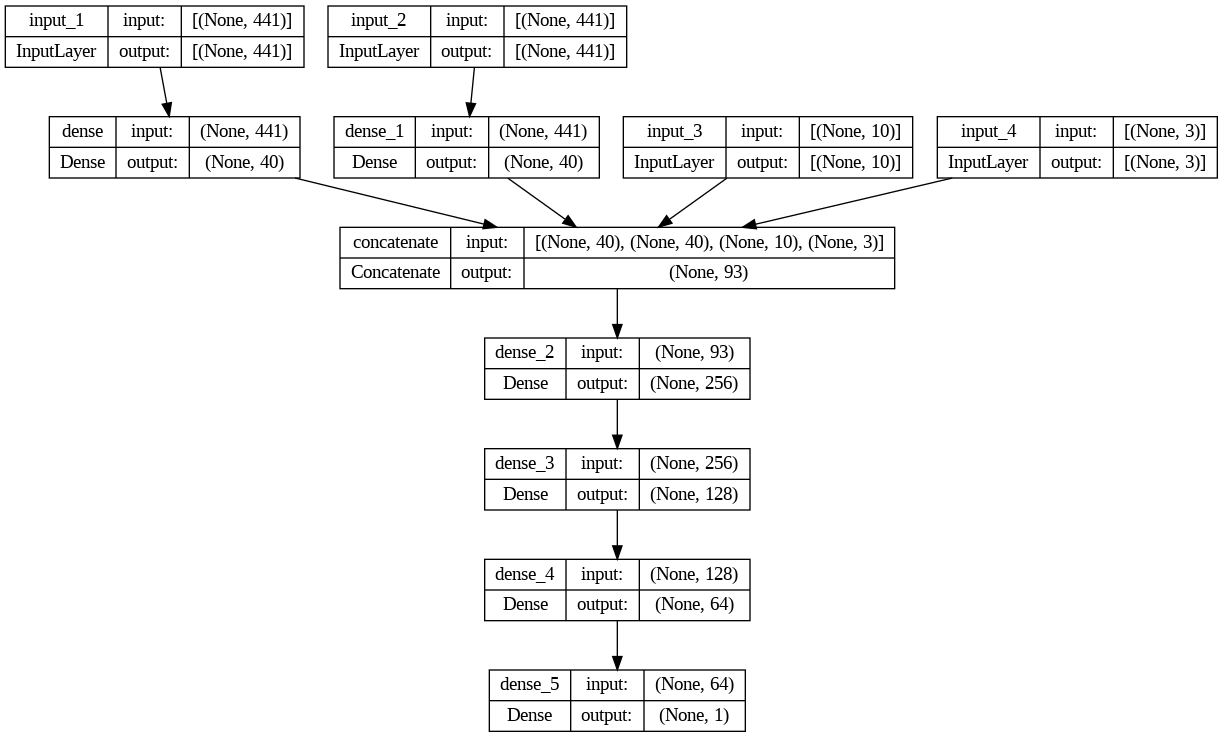

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(loaded_mlp_train_test_split_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

## 3.6 Use the trained model to rank recommendations from the embedding-based method and evaluate the results

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

def rank_evaluate_recommendations(user_recommendations_map, actual_games_map, loaded_model, k=150, max_users=20):
    all_precisions = []
    all_recalls = []
    all_average_precisions = []

    for idx, (user_id, recommended_app_ids) in enumerate(user_recommendations_map.items()):
        if idx >= max_users:
            break

        feat_liked_tags_multihot, feat_user = get_user_features(user_id)
        feat_tags_multihot_list, feat_item_list = get_games_features(recommended_app_ids)
        predict_feats = [
            feat_tags_multihot_list,
            np.tile(feat_liked_tags_multihot, (len(recommended_app_ids), 1)),
            feat_item_list,
            np.tile(feat_user, (len(recommended_app_ids), 1))
        ]
        predictions = loaded_model.predict(predict_feats).flatten()
        true_labels = [1 if int(app_id) in actual_games_map[int(user_id)] else 0 for app_id in recommended_app_ids]
        # Sort according to prediction scores
        sorted_indices = np.argsort(predictions)[::-1]
        sorted_true_labels = np.array(true_labels)[sorted_indices]
        # select the top K ranked recommendations
        top_k_true_labels = sorted_true_labels[:k]
        # compute Precision and Recall
        precision = np.sum(top_k_true_labels) / k
        recall = np.sum(top_k_true_labels) / len(actual_games_map[int(user_id)])
        all_precisions.append(precision)
        all_recalls.append(recall)
        # compute AP
        ap = average_precision(true_labels, sorted_indices)
        all_average_precisions.append(ap)

    # compute mean Precision、Recall and MAP
    mean_precision = np.mean(all_precisions)
    mean_recall = np.mean(all_recalls)
    mean_average_precision = np.mean(all_average_precisions)

    return mean_precision, mean_recall, mean_average_precision



## 3.7 Compare the metrics

In [ ]:
# user_recommendations_map_top5_k300
mean_precision, mean_recall, mean_average_precision = rank_evaluate_recommendations(
    user_recommendations_map_top5_2w_k300,
    top5_user_actual_games_map,
    loaded_mlp_train_test_split_model,
    k=250,
    max_users=10
)

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean Average Precision (MAP): {mean_average_precision}")


10/10 [==============================] - 0s 2ms/step
Mean Precision: 0.032799999999999996
Mean Recall: 0.5517295747730531
Mean Average Precision (MAP): 0.062035239041017175


In [ ]:
# user_recommendations_map_top5_2w_k300

mean_precision, mean_recall, mean_average_precision = rank_evaluate_recommendations(
    user_recommendations_map_top5_2w_k300,
    top5_user_actual_games_map,
    loaded_mlp_full_model,
    k=250,
    max_users=10
)

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean Average Precision (MAP): {mean_average_precision}")

10/10 [==============================] - 0s 2ms/step
Mean Precision: 0.0316
Mean Recall: 0.5332186653925785
Mean Average Precision (MAP): 0.04947795164337776


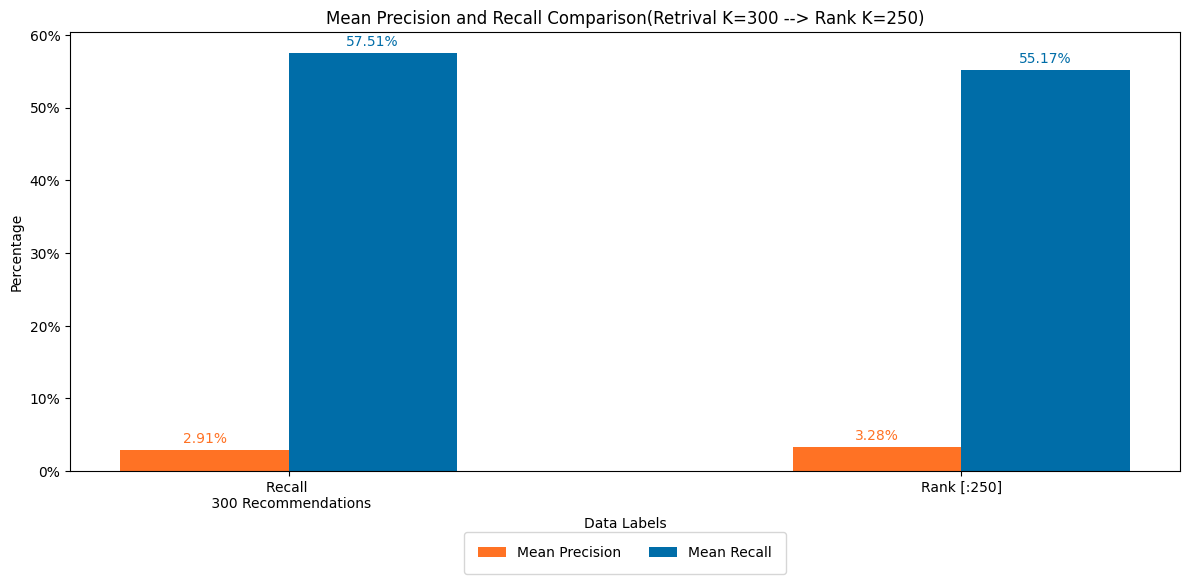

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

data_labels = ['Recall \n 300 Recommendations', 'Rank [:250]']
mean_precision = [0.029148384155819274, 0.032799999999999996]
mean_recall = [0.5750876352152569, 0.5517295747730531]
plot_precision_recall_bar(data_labels,mean_precision,  mean_recall, "Mean Precision and Recall Comparison(Retrival K=300 --> Rank K=250)")

In [ ]:
# user_recommendations_map_top5_2w_k200
mean_precision, mean_recall, mean_average_precision = rank_evaluate_recommendations(
    user_recommendations_map_top5_2w,
    top5_user_actual_games_map,
    loaded_mlp_train_test_split_model,
    k=150,
    max_users=10
)

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean Average Precision (MAP): {mean_average_precision}")

7/7 [==============================] - 0s 2ms/step
Mean Precision: 0.04866666666666667
Mean Recall: 0.48437808568243346
Mean Average Precision (MAP): 0.0708044085817487


In [ ]:
mean_precision, mean_recall, mean_average_precision = rank_evaluate_recommendations(
    user_recommendations_map_top5_2w,
    top5_user_actual_games_map,
    loaded_mlp_full_model,
    k=150,
    max_users=10
)

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean Average Precision (MAP): {mean_average_precision}")

7/7 [==============================] - 0s 2ms/step
Mean Precision: 0.049999999999999996
Mean Recall: 0.5065270478313957
Mean Average Precision (MAP): 0.07616338559817573


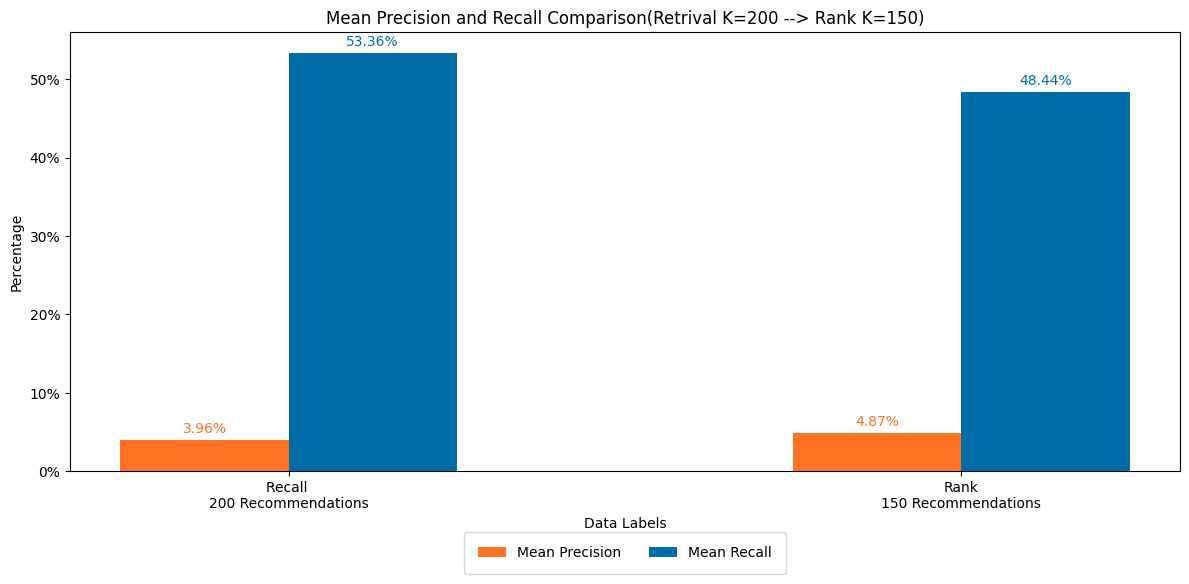

In [ ]:
from plot_tool import plot_precision_recall_bar

data_labels = ['Recall \n200 Recommendations', 'Rank\n150 Recommendations']
avg_precision = [0.03964862579118432, 0.04866666666666667]
avg_recall = [0.5335682049344127, 0.48437808568243346]

plot_precision_recall_bar(data_labels, avg_precision, avg_recall, "Mean Precision and Recall Comparison(Retrival K=200 --> Rank K=150)")

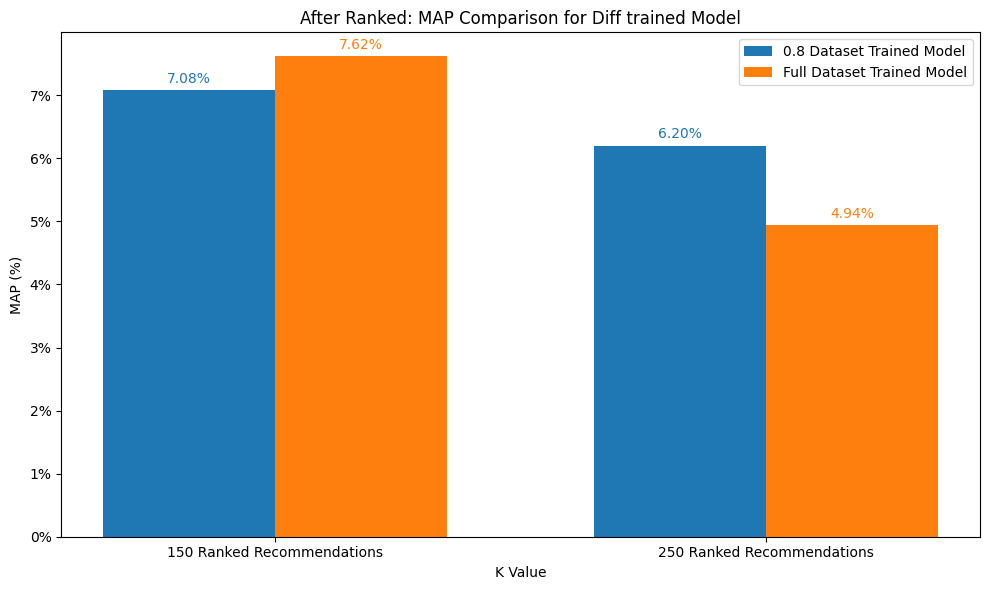

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import plot_tool
importlib.reload(plot_tool)
from plot_tool import plot_map_comparison

data_labels = ['150 Ranked Recommendations', '250 Ranked Recommendations']

map_0_8_training = [0.0708044085817487, 0.062035239041017175]
map_full_training = [0.07616338559817573, 0.04947795164337776]

plot_map_comparison(data_labels, map_0_8_training, map_full_training, title='After Ranked: MAP Comparison for Diff trained Model')